In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [4]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [5]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [6]:
balance_method = "weight"
#balance_method = "bagging"

DEFAULT_PARAMS = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'bagging_freq': 1,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,

    #'boosting':'dart',

    #'max_bin': 63,
    #'num_leaves': 7,
    
    #'pos_bagging_fraction': 1,
    #'neg_bagging_fraction': 0.21218074656188604,
    
    #'feature_fraction': 0.75,
    #'lambda_l1': 0.00020196676966216634,
    #'lambda_l2': 2.3627262174517976e-09,
    #'min_data_in_leaf': 13,
    #'min_gain_to_split': 0.0007626326850799573,
    #'num_iterations': 1591,
    #'path_smooth': 2.652521741711401e-09,
}

if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(DEFAULT_PARAMS)

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'scale_pos_weight': 4.712962962962963}

In [7]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        2000 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = lgb.Dataset(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"Class"].values,
                free_raw_data=False
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 5, 8) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 5) - 1,
        num_iterations = trial.suggest_int("num_iterations", 1000, 3000),
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.4, 0.95, step=0.05),
        bagging_fraction = trial.suggest_float("bagging_fraction", 0.8, 1.0, step=0.01),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 30),
        
        lambda_l1 = trial.suggest_float("lambda_l1", 1e-10, 1e1, log=True),
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-10, 1e1, log=True),
        path_smooth = trial.suggest_float("path_smooth", 1e-10, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-10, 1e1, log=True),
        
        # dart
        #drop_rate = trial.suggest_float("drop_rate", 0.05, 0.3, step=0.01),
        #max_drop = trial.suggest_int("max_drop", 10, 100, 5),
        #skip_drop = trial.suggest_float("skip_drop", 0.2, 0.8, step=0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 15min 27s, sys: 9.57 s, total: 15min 36s
Wall time: 1min 57s


(0.37617453321870076, 0.12919305675032572)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-gbrt-weight-balanced",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-gbrt-weight-balanced.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=50400, # 14 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-06-20 00:06:17,893] Using an existing study with name 'iarc-lgbm-gbrt-weight-balanced' instead of creating a new one.


[I 2023-06-20 00:07:45,677] Trial 2 finished with value: 0.3217003270675328 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 4.467275378580813e-06, 'lambda_l2': 3.080342582965572e-10, 'max_bin_exp': 8, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.4384108042596668e-05, 'num_iterations': 2291, 'num_leaves_exp': 5, 'path_smooth': 7.130580292730276}. Best is trial 0 with value: 0.2870950456377675.


[I 2023-06-20 00:08:25,516] Trial 3 finished with value: 0.3110783169098671 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.04203653433152291, 'lambda_l2': 4.143104761192969e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.1069466155565147e-10, 'num_iterations': 1187, 'num_leaves_exp': 5, 'path_smooth': 1.0731918732195364e-09}. Best is trial 0 with value: 0.2870950456377675.


[I 2023-06-20 00:10:27,877] Trial 4 finished with value: 0.3053843508134191 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.95, 'lambda_l1': 3.965197347118958e-09, 'lambda_l2': 1.7241089308843833, 'max_bin_exp': 7, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.3045669922043706e-09, 'num_iterations': 2865, 'num_leaves_exp': 5, 'path_smooth': 8.613060439240085e-10}. Best is trial 0 with value: 0.2870950456377675.


[I 2023-06-20 00:11:02,094] Trial 5 finished with value: 0.282579382483402 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'lambda_l1': 0.0006373907664890319, 'lambda_l2': 1.1987940639842567e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.23421098428928763, 'num_iterations': 1639, 'num_leaves_exp': 5, 'path_smooth': 5.375106241192966e-06}. Best is trial 5 with value: 0.282579382483402.


[I 2023-06-20 00:11:44,432] Trial 6 finished with value: 0.26601339192481527 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.02314930078374566, 'lambda_l2': 1.6451040510928983, 'max_bin_exp': 7, 'min_data_in_leaf': 5, 'min_gain_to_split': 0.0011564524198277987, 'num_iterations': 1577, 'num_leaves_exp': 3, 'path_smooth': 7.020942500845548e-06}. Best is trial 6 with value: 0.26601339192481527.


[I 2023-06-20 00:13:10,375] Trial 7 finished with value: 0.3320862166356171 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.00010581358956672363, 'lambda_l2': 0.000448222580489631, 'max_bin_exp': 8, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.124845951140193e-05, 'num_iterations': 2391, 'num_leaves_exp': 5, 'path_smooth': 0.10528124230960406}. Best is trial 6 with value: 0.26601339192481527.


[I 2023-06-20 00:13:47,715] Trial 8 finished with value: 0.2830138754314904 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.55, 'lambda_l1': 3.693060321092593e-07, 'lambda_l2': 0.05272768004260737, 'max_bin_exp': 8, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.005685803866677004, 'num_iterations': 1112, 'num_leaves_exp': 4, 'path_smooth': 0.0027216489963392877}. Best is trial 6 with value: 0.26601339192481527.


[I 2023-06-20 00:16:22,289] Trial 9 finished with value: 0.4636855993929836 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8, 'lambda_l1': 0.0014225784471277219, 'lambda_l2': 4.3468103214365445e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 11, 'min_gain_to_split': 1.627169499907559e-07, 'num_iterations': 2812, 'num_leaves_exp': 5, 'path_smooth': 7.910066250998421e-07}. Best is trial 6 with value: 0.26601339192481527.


[I 2023-06-20 00:16:58,564] Trial 10 finished with value: 0.2818314332031422 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.55, 'lambda_l1': 0.05451504519510059, 'lambda_l2': 2.027926583946328e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.160749905697869e-06, 'num_iterations': 1464, 'num_leaves_exp': 4, 'path_smooth': 9.169672020220075e-10}. Best is trial 6 with value: 0.26601339192481527.


[I 2023-06-20 00:17:17,404] Trial 11 finished with value: 0.2921981260390324 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.75, 'lambda_l1': 2.4438161580196285, 'lambda_l2': 5.3389212516290385, 'max_bin_exp': 6, 'min_data_in_leaf': 5, 'min_gain_to_split': 2.4955099679214774, 'num_iterations': 2008, 'num_leaves_exp': 2, 'path_smooth': 0.00018873724309940757}. Best is trial 6 with value: 0.26601339192481527.


[I 2023-06-20 00:17:39,340] Trial 12 finished with value: 0.2848368570620324 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.4, 'lambda_l1': 6.372110662062313, 'lambda_l2': 3.2186944632853636e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0029916755622688843, 'num_iterations': 1512, 'num_leaves_exp': 3, 'path_smooth': 1.2212793957139142e-10}. Best is trial 6 with value: 0.26601339192481527.


[I 2023-06-20 00:18:10,472] Trial 13 finished with value: 0.26045683308578643 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.03226096515827221, 'lambda_l2': 1.6496378965190006e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.179348479030297e-07, 'num_iterations': 1433, 'num_leaves_exp': 3, 'path_smooth': 1.3772586431179935e-07}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:18:51,267] Trial 14 finished with value: 0.2644732955823806 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.009909304650744466, 'lambda_l2': 2.6667772146816167e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.719579039404582e-07, 'num_iterations': 1903, 'num_leaves_exp': 3, 'path_smooth': 3.969133341997932e-07}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:19:32,601] Trial 15 finished with value: 0.2669814098721837 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.75, 'lambda_l1': 0.000882464762535052, 'lambda_l2': 8.896934027304566e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 5.000529934289072e-08, 'num_iterations': 1913, 'num_leaves_exp': 3, 'path_smooth': 1.4446597382913623e-07}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:20:16,375] Trial 16 finished with value: 0.2724726661732991 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.2336865908126825e-05, 'lambda_l2': 3.4981401984589687e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 2.0213648745967856e-08, 'num_iterations': 1948, 'num_leaves_exp': 3, 'path_smooth': 2.4820771324227282e-08}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:20:29,887] Trial 17 finished with value: 0.2994148526481523 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.360466700964022, 'lambda_l2': 6.122432042013189e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 9.162349334449978e-07, 'num_iterations': 1315, 'num_leaves_exp': 2, 'path_smooth': 3.718967804390329e-07}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:22:00,180] Trial 18 finished with value: 0.34992070826896987 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.65, 'lambda_l1': 0.008835435710764084, 'lambda_l2': 4.8831625542755794e-09, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.1966116686106077e-08, 'num_iterations': 2243, 'num_leaves_exp': 4, 'path_smooth': 4.1482390652836326e-05}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:22:34,162] Trial 19 finished with value: 0.27070141536775477 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.9, 'lambda_l1': 1.5699028098642849, 'lambda_l2': 2.0376786508081523e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 10, 'min_gain_to_split': 7.575687360410148e-07, 'num_iterations': 1814, 'num_leaves_exp': 3, 'path_smooth': 6.312411192580305e-08}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:23:48,164] Trial 20 finished with value: 0.3430851162820652 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.004831847867914152, 'lambda_l2': 2.6920570242620337e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.055972202823248e-09, 'num_iterations': 2577, 'num_leaves_exp': 4, 'path_smooth': 1.8032339292876614e-06}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:24:05,025] Trial 21 finished with value: 0.3005102250604444 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.8, 'lambda_l1': 0.6320185260741563, 'lambda_l2': 2.2131842280273814e-06, 'max_bin_exp': 7, 'min_data_in_leaf': 16, 'min_gain_to_split': 1.2155825673938457e-07, 'num_iterations': 1329, 'num_leaves_exp': 2, 'path_smooth': 4.979739940276312e-05}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:24:53,828] Trial 22 finished with value: 0.2707403949602196 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.65, 'lambda_l1': 0.01856023739058396, 'lambda_l2': 0.00842493087523655, 'max_bin_exp': 7, 'min_data_in_leaf': 8, 'min_gain_to_split': 0.000390518894331746, 'num_iterations': 1678, 'num_leaves_exp': 3, 'path_smooth': 6.315643025289198e-06}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:25:13,679] Trial 23 finished with value: 0.26763946763824387 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.14389101153247846, 'lambda_l2': 0.0005091487451719743, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 4.090856131809623e-06, 'num_iterations': 1006, 'num_leaves_exp': 3, 'path_smooth': 7.318661810617343e-07}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:26:13,444] Trial 24 finished with value: 0.28231003617030515 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.75, 'lambda_l1': 0.008630333491678705, 'lambda_l2': 1.653026051217159e-07, 'max_bin_exp': 7, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.8612205165209205e-07, 'num_iterations': 2087, 'num_leaves_exp': 3, 'path_smooth': 5.656665764420081e-06}. Best is trial 13 with value: 0.26045683308578643.


[I 2023-06-20 00:26:49,929] Trial 25 finished with value: 0.258054227905718 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.00035231379447313435, 'lambda_l2': 0.3383893306114661, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.7363664073152506e-06, 'num_iterations': 1788, 'num_leaves_exp': 3, 'path_smooth': 1.7831891736663607e-08}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:27:46,622] Trial 26 finished with value: 0.29790101969855504 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.65, 'lambda_l1': 8.845731011994779e-05, 'lambda_l2': 7.64538231284681e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.1318052251741507e-06, 'num_iterations': 1840, 'num_leaves_exp': 4, 'path_smooth': 8.596657912488746e-09}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:28:05,157] Trial 27 finished with value: 0.2814907185127707 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0003087314386558179, 'lambda_l2': 7.565456776687591e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.6039319334208617e-07, 'num_iterations': 2121, 'num_leaves_exp': 2, 'path_smooth': 1.341130532843993e-07}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:28:33,542] Trial 28 finished with value: 0.2635905993262026 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.0010237285850133657, 'lambda_l2': 1.0057988096767295e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 6.555113365720082e-06, 'num_iterations': 1400, 'num_leaves_exp': 3, 'path_smooth': 8.673181543197548e-09}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:29:13,700] Trial 29 finished with value: 0.28265094952667275 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0015442498943624215, 'lambda_l2': 7.331305246891093e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 8.668744791455544e-06, 'num_iterations': 1339, 'num_leaves_exp': 4, 'path_smooth': 6.854233088326926e-09}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:29:28,527] Trial 30 finished with value: 0.29258463593746487 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 9.661364204664148e-05, 'lambda_l2': 5.139777222275582e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.084530342042225e-05, 'num_iterations': 1679, 'num_leaves_exp': 2, 'path_smooth': 2.6500403973346354e-08}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:29:59,439] Trial 31 finished with value: 0.2641029734498879 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.8, 'lambda_l1': 0.1983995133383362, 'lambda_l2': 1.529282504163112e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.856645273813545e-05, 'num_iterations': 1456, 'num_leaves_exp': 3, 'path_smooth': 6.620436606303041e-08}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:30:29,295] Trial 32 finished with value: 0.2637838664756597 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8, 'lambda_l1': 0.1619543253101647, 'lambda_l2': 1.32872556363782e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.0693187644490494e-05, 'num_iterations': 1408, 'num_leaves_exp': 3, 'path_smooth': 1.2148081047645712e-08}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:30:53,197] Trial 33 finished with value: 0.2677662203049838 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.75, 'lambda_l1': 0.10280365124439457, 'lambda_l2': 1.36514472270259e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.5731058012474209e-06, 'num_iterations': 1188, 'num_leaves_exp': 3, 'path_smooth': 5.761707962752091e-09}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:31:29,466] Trial 34 finished with value: 0.2638707588014534 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.65, 'lambda_l1': 0.002782882566495997, 'lambda_l2': 8.603555891429999e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.0392443147639117e-05, 'num_iterations': 1750, 'num_leaves_exp': 3, 'path_smooth': 2.816085240958806e-09}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:31:43,363] Trial 35 finished with value: 0.2944626083606767 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04533968100866251, 'lambda_l2': 4.834155814387833e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0001387668772372603, 'num_iterations': 1357, 'num_leaves_exp': 2, 'path_smooth': 2.2401039477854066e-08}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:32:04,368] Trial 36 finished with value: 0.26825502320536726 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.6067939630828751, 'lambda_l2': 8.472254370571172e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.582197809895278e-05, 'num_iterations': 1187, 'num_leaves_exp': 3, 'path_smooth': 3.291317552234604e-10}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:32:35,477] Trial 37 finished with value: 0.2606591968294942 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 2.9956898619747646e-06, 'lambda_l2': 1.697046239899883e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.2633933556185142e-06, 'num_iterations': 1554, 'num_leaves_exp': 3, 'path_smooth': 2.432526638897298e-09}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:33:34,346] Trial 38 finished with value: 0.288464222595267 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 2.0834564672173167e-06, 'lambda_l2': 1.2745907590843157e-10, 'max_bin_exp': 7, 'min_data_in_leaf': 30, 'min_gain_to_split': 6.877936439673252e-07, 'num_iterations': 1649, 'num_leaves_exp': 4, 'path_smooth': 1.702272517093407e-09}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:34:04,107] Trial 39 finished with value: 0.25886483261884785 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.5, 'lambda_l1': 1.8767423353808036e-05, 'lambda_l2': 3.2702373399611315e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 9.621864039843657e-10, 'num_iterations': 1543, 'num_leaves_exp': 3, 'path_smooth': 3.887542224887737e-10}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:34:21,224] Trial 40 finished with value: 0.29211167882385847 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 1.8483762973875213e-05, 'lambda_l2': 1.1927676923021175e-10, 'max_bin_exp': 7, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.5535639976753343e-10, 'num_iterations': 1561, 'num_leaves_exp': 2, 'path_smooth': 3.410543945329569e-10}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:34:50,430] Trial 41 finished with value: 0.2639358875553925 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 1.6503221823768275e-06, 'lambda_l2': 2.871118095773727e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 8.100296004308305e-10, 'num_iterations': 1739, 'num_leaves_exp': 3, 'path_smooth': 2.0660124500136344e-09}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:35:20,823] Trial 42 finished with value: 0.26163896726445407 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.55, 'lambda_l1': 0.0001641934971988322, 'lambda_l2': 1.7997977609772927e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.64072120557112e-08, 'num_iterations': 1560, 'num_leaves_exp': 3, 'path_smooth': 1.0968221407736295e-10}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:35:51,476] Trial 43 finished with value: 0.26205378193288764 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.55, 'lambda_l1': 8.739151697981686e-06, 'lambda_l2': 1.3365027597396128e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.9167126335814846e-09, 'num_iterations': 1586, 'num_leaves_exp': 3, 'path_smooth': 1.0414960247107727e-10}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:36:20,203] Trial 44 finished with value: 0.26106405209024497 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.5, 'lambda_l1': 2.6057241699365944e-05, 'lambda_l2': 5.683206958866439e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.868199059728824e-08, 'num_iterations': 1518, 'num_leaves_exp': 3, 'path_smooth': 9.249419527316372e-10}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:36:44,409] Trial 45 finished with value: 0.26373902087177387 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 2.799012623505538e-05, 'lambda_l2': 3.383496495227171e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.71729650335145e-08, 'num_iterations': 1237, 'num_leaves_exp': 3, 'path_smooth': 4.509055974063982e-10}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:37:31,111] Trial 46 finished with value: 0.28488768640135087 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 1.8832109025332709e-07, 'lambda_l2': 3.0275720752280714e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.8578897800451797e-08, 'num_iterations': 1511, 'num_leaves_exp': 4, 'path_smooth': 1.9239807725780574e-09}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:37:51,483] Trial 47 finished with value: 0.2671464625626979 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.55, 'lambda_l1': 6.071384883416412e-05, 'lambda_l2': 3.1790425436350664e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.53272687070896e-07, 'num_iterations': 1072, 'num_leaves_exp': 3, 'path_smooth': 7.53842494309772e-10}. Best is trial 25 with value: 0.258054227905718.


[I 2023-06-20 00:38:23,723] Trial 48 finished with value: 0.25778349393351613 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0003459143853689067, 'lambda_l2': 1.0856500363016033e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 5.5225401022609335e-09, 'num_iterations': 1719, 'num_leaves_exp': 3, 'path_smooth': 3.6661081453779986e-09}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:38:43,334] Trial 49 finished with value: 0.2856884501869231 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.4, 'lambda_l1': 0.00029667910733338496, 'lambda_l2': 3.947764541440898e-08, 'max_bin_exp': 8, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.2568458483384405e-10, 'num_iterations': 1800, 'num_leaves_exp': 2, 'path_smooth': 4.642224920047882e-08}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:39:45,410] Trial 50 finished with value: 0.3460350126450429 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0004025555796810792, 'lambda_l2': 2.1966495292419854e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.2856444464217413e-09, 'num_iterations': 2072, 'num_leaves_exp': 4, 'path_smooth': 4.698756888702576e-09}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:40:30,456] Trial 51 finished with value: 0.26005370840359227 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00295323232097849, 'lambda_l2': 0.7243665827898779, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 6.42788278300804e-09, 'num_iterations': 1980, 'num_leaves_exp': 3, 'path_smooth': 3.5402189996593506e-09}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:41:21,011] Trial 52 finished with value: 0.2653810258177501 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.004360306473421049, 'lambda_l2': 0.13001441492649315, 'max_bin_exp': 7, 'min_data_in_leaf': 14, 'min_gain_to_split': 6.757306818048142e-09, 'num_iterations': 2196, 'num_leaves_exp': 3, 'path_smooth': 4.384042122433762e-09}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:42:07,186] Trial 53 finished with value: 0.25971313609777574 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.0019914957830907284, 'lambda_l2': 0.6315604034270799, 'max_bin_exp': 7, 'min_data_in_leaf': 16, 'min_gain_to_split': 2.6395762591615945e-09, 'num_iterations': 1980, 'num_leaves_exp': 3, 'path_smooth': 1.4381701557408962e-08}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:42:58,130] Trial 54 finished with value: 0.2646144889224962 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.0015894039240029558, 'lambda_l2': 8.422786224291277, 'max_bin_exp': 7, 'min_data_in_leaf': 16, 'min_gain_to_split': 7.969806215591291e-10, 'num_iterations': 2338, 'num_leaves_exp': 3, 'path_smooth': 1.8053881519133278e-08}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:43:42,245] Trial 55 finished with value: 0.2595210358204302 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0006226439923844329, 'lambda_l2': 1.0745319074586317, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 7.607419895891435e-09, 'num_iterations': 1946, 'num_leaves_exp': 3, 'path_smooth': 1.510286556031684e-07}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:44:26,902] Trial 56 finished with value: 0.25976611868006705 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0008996296395959016, 'lambda_l2': 1.164232967367431, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 2.1259064491366073e-09, 'num_iterations': 1976, 'num_leaves_exp': 3, 'path_smooth': 4.726099134967531e-10}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:45:29,215] Trial 57 finished with value: 0.2641890838057548 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.45, 'lambda_l1': 0.00018490080008955103, 'lambda_l2': 2.5854923019207683, 'max_bin_exp': 8, 'min_data_in_leaf': 11, 'min_gain_to_split': 2.4193822451317392e-09, 'num_iterations': 2467, 'num_leaves_exp': 3, 'path_smooth': 2.785520079835792e-10}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:46:11,894] Trial 58 finished with value: 0.26005394991321135 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00032257820309654285, 'lambda_l2': 0.5675710271467653, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 3.2820190273047905e-10, 'num_iterations': 1894, 'num_leaves_exp': 3, 'path_smooth': 7.563436253044331e-10}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:47:20,111] Trial 59 finished with value: 0.2685639242690662 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 5.012103903117937e-05, 'lambda_l2': 3.567949821737406, 'max_bin_exp': 7, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.928163854237794e-09, 'num_iterations': 2987, 'num_leaves_exp': 3, 'path_smooth': 1.7420254382498275e-07}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:48:38,646] Trial 60 finished with value: 0.3183523555509775 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.5, 'lambda_l1': 0.0009793190009775078, 'lambda_l2': 0.1375053590169053, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.4514152846942583e-08, 'num_iterations': 2026, 'num_leaves_exp': 4, 'path_smooth': 1.4791372733537698e-08}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:49:27,989] Trial 61 finished with value: 0.2600259360337251 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0005093486047961343, 'lambda_l2': 1.2671365744373868, 'max_bin_exp': 7, 'min_data_in_leaf': 12, 'min_gain_to_split': 8.529631300554698e-09, 'num_iterations': 2141, 'num_leaves_exp': 3, 'path_smooth': 4.523743734473086e-08}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:50:17,335] Trial 62 finished with value: 0.2600869036975348 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0005420613440436018, 'lambda_l2': 1.3963995890260756, 'max_bin_exp': 7, 'min_data_in_leaf': 12, 'min_gain_to_split': 8.237548870205667e-09, 'num_iterations': 2137, 'num_leaves_exp': 3, 'path_smooth': 4.634777788674641e-08}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:50:57,988] Trial 63 finished with value: 0.26539925370648604 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00014209937609048457, 'lambda_l2': 6.127954238175274, 'max_bin_exp': 7, 'min_data_in_leaf': 14, 'min_gain_to_split': 3.1418304668670616e-09, 'num_iterations': 1877, 'num_leaves_exp': 3, 'path_smooth': 1.200459354589712e-09}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:51:56,387] Trial 64 finished with value: 0.2690001654222031 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.0005925149483378307, 'lambda_l2': 0.34897530079532435, 'max_bin_exp': 8, 'min_data_in_leaf': 9, 'min_gain_to_split': 2.259886323200829e-08, 'num_iterations': 2197, 'num_leaves_exp': 3, 'path_smooth': 1.0210321066765876e-08}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:52:40,770] Trial 65 finished with value: 0.2628946293690209 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.015270596210816504, 'lambda_l2': 0.01730866706943972, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 5.973286770483368e-10, 'num_iterations': 2019, 'num_leaves_exp': 3, 'path_smooth': 1.6934834700357716e-06}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:53:26,826] Trial 66 finished with value: 0.25900612662209943 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0021515866621693845, 'lambda_l2': 1.3254463248427377, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 2.33759094918567e-09, 'num_iterations': 1948, 'num_leaves_exp': 3, 'path_smooth': 8.569623100449917e-08}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:54:11,368] Trial 67 finished with value: 0.2604861929691659 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.45, 'lambda_l1': 0.0017549748245226343, 'lambda_l2': 2.3167389827160387, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.4942410187375162e-09, 'num_iterations': 1951, 'num_leaves_exp': 3, 'path_smooth': 1.1419923861714747e-07}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:54:54,249] Trial 68 finished with value: 0.26058795136408586 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.5, 'lambda_l1': 0.007127735542702879, 'lambda_l2': 0.37953070384852466, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 3.4679603632478734e-09, 'num_iterations': 1725, 'num_leaves_exp': 3, 'path_smooth': 3.039663702594677e-07}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:55:14,930] Trial 69 finished with value: 0.29716524176892933 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.0025255542816182315, 'lambda_l2': 9.788315473071526, 'max_bin_exp': 8, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.462974247002144e-10, 'num_iterations': 1805, 'num_leaves_exp': 2, 'path_smooth': 2.0709603533734233e-10}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:56:12,304] Trial 70 finished with value: 0.269601762873866 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.5, 'lambda_l1': 0.027670893740031035, 'lambda_l2': 4.011271058799031, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.5798256182939738e-10, 'num_iterations': 1852, 'num_leaves_exp': 5, 'path_smooth': 2.4881923437837914e-08}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:56:55,793] Trial 71 finished with value: 0.2583660951267252 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.005826428043608392, 'lambda_l2': 1.022778950821486, 'max_bin_exp': 7, 'min_data_in_leaf': 16, 'min_gain_to_split': 9.172406703876571e-10, 'num_iterations': 1944, 'num_leaves_exp': 3, 'path_smooth': 5.735443677794866e-09}. Best is trial 48 with value: 0.25778349393351613.


[I 2023-06-20 00:57:39,053] Trial 72 finished with value: 0.25750056212547107 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.007080681671883536, 'lambda_l2': 0.8987757748796511, 'max_bin_exp': 7, 'min_data_in_leaf': 16, 'min_gain_to_split': 1.1394871009298942e-09, 'num_iterations': 1933, 'num_leaves_exp': 3, 'path_smooth': 6.844960002474383e-09}. Best is trial 72 with value: 0.25750056212547107.


[I 2023-06-20 00:58:24,961] Trial 73 finished with value: 0.2619036423620559 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.005067997910713748, 'lambda_l2': 0.09100202097623539, 'max_bin_exp': 7, 'min_data_in_leaf': 16, 'min_gain_to_split': 5.730076194499964e-10, 'num_iterations': 1919, 'num_leaves_exp': 3, 'path_smooth': 8.538463771217153e-09}. Best is trial 72 with value: 0.25750056212547107.


[I 2023-06-20 00:59:04,983] Trial 74 finished with value: 0.2577682604907296 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.007495433821351866, 'lambda_l2': 0.2947259359126785, 'max_bin_exp': 7, 'min_data_in_leaf': 16, 'min_gain_to_split': 2.4736242951716866e-10, 'num_iterations': 1761, 'num_leaves_exp': 3, 'path_smooth': 2.6242380945557733e-09}. Best is trial 72 with value: 0.25750056212547107.


[I 2023-06-20 00:59:45,075] Trial 75 finished with value: 0.2583294149306774 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.008203748291905632, 'lambda_l2': 0.18104535487706044, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 2.9164154433795146e-10, 'num_iterations': 1773, 'num_leaves_exp': 3, 'path_smooth': 4.331842391849337e-09}. Best is trial 72 with value: 0.25750056212547107.


[I 2023-06-20 01:00:22,100] Trial 76 finished with value: 0.25718493124484154 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.023319665211170005, 'lambda_l2': 0.20926424706445812, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.0439156235616749e-10, 'num_iterations': 1645, 'num_leaves_exp': 3, 'path_smooth': 3.1727006006608708e-09}. Best is trial 76 with value: 0.25718493124484154.


[I 2023-06-20 01:00:58,391] Trial 77 finished with value: 0.2577654885595669 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.019368638960495278, 'lambda_l2': 0.23222779471850746, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.2934943774772203e-10, 'num_iterations': 1636, 'num_leaves_exp': 3, 'path_smooth': 3.827410191150908e-09}. Best is trial 76 with value: 0.25718493124484154.


[I 2023-06-20 01:01:34,524] Trial 78 finished with value: 0.2578556526208532 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.07479834351117161, 'lambda_l2': 0.2338714761200444, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.2099785851584384e-10, 'num_iterations': 1637, 'num_leaves_exp': 3, 'path_smooth': 3.895716354249175e-09}. Best is trial 76 with value: 0.25718493124484154.


[I 2023-06-20 01:02:10,226] Trial 79 finished with value: 0.2584005210780213 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.014271384215203587, 'lambda_l2': 0.03918509350046372, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.0900165124770578e-10, 'num_iterations': 1619, 'num_leaves_exp': 3, 'path_smooth': 1.4887354146050265e-09}. Best is trial 76 with value: 0.25718493124484154.


[I 2023-06-20 01:03:18,624] Trial 80 finished with value: 0.3079242560875677 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.95, 'lambda_l1': 0.06102632358085434, 'lambda_l2': 0.3452726978598224, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.339110938915462e-10, 'num_iterations': 1689, 'num_leaves_exp': 4, 'path_smooth': 3.412831865423804e-09}. Best is trial 76 with value: 0.25718493124484154.


[I 2023-06-20 01:03:37,524] Trial 81 finished with value: 0.28591601723287474 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.02273300679337547, 'lambda_l2': 0.00621136759048187, 'max_bin_exp': 8, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.099731310493774e-10, 'num_iterations': 1793, 'num_leaves_exp': 2, 'path_smooth': 2.350263539102842e-09}. Best is trial 76 with value: 0.25718493124484154.


[I 2023-06-20 01:04:16,230] Trial 82 finished with value: 0.25846856095482673 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.009686675575885475, 'lambda_l2': 0.18006944249955306, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.0000459251158224e-10, 'num_iterations': 1731, 'num_leaves_exp': 3, 'path_smooth': 5.234706700431118e-09}. Best is trial 76 with value: 0.25718493124484154.


[I 2023-06-20 01:04:53,073] Trial 83 finished with value: 0.25713461041799884 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.020174670277028926, 'lambda_l2': 0.22435128236909135, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 3.3436439068912643e-10, 'num_iterations': 1669, 'num_leaves_exp': 3, 'path_smooth': 1.090549563206804e-09}. Best is trial 83 with value: 0.25713461041799884.


[I 2023-06-20 01:05:29,435] Trial 84 finished with value: 0.2567682974694261 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.06181708253098967, 'lambda_l2': 0.25213039772943574, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.2206710706801507e-10, 'num_iterations': 1647, 'num_leaves_exp': 3, 'path_smooth': 1.2247946822813917e-09}. Best is trial 84 with value: 0.2567682974694261.


[I 2023-06-20 01:06:07,380] Trial 85 finished with value: 0.25825978949820977 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.09212133131814981, 'lambda_l2': 0.061687916041849485, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.5828338873091515e-10, 'num_iterations': 1642, 'num_leaves_exp': 3, 'path_smooth': 7.770818634773379e-10}. Best is trial 84 with value: 0.2567682974694261.


[I 2023-06-20 01:06:39,187] Trial 86 finished with value: 0.2590761459838905 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.036878350766657075, 'lambda_l2': 0.24898294237939556, 'max_bin_exp': 7, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.086906282470524e-10, 'num_iterations': 1470, 'num_leaves_exp': 3, 'path_smooth': 1.1481452311636531e-09}. Best is trial 84 with value: 0.2567682974694261.


[I 2023-06-20 01:07:16,177] Trial 87 finished with value: 0.2586429272572001 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.04446682878764427, 'lambda_l2': 0.03799269723933019, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 4.365944592808079e-10, 'num_iterations': 1692, 'num_leaves_exp': 3, 'path_smooth': 2.143664043282807e-10}. Best is trial 84 with value: 0.2567682974694261.


[I 2023-06-20 01:07:52,997] Trial 88 finished with value: 0.2567360921420599 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.24917297291745583, 'lambda_l2': 0.11675704346172147, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.0009603408929186e-09, 'num_iterations': 1604, 'num_leaves_exp': 3, 'path_smooth': 1.7741330607591114e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:08:30,597] Trial 89 finished with value: 0.25746941232108783 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.23741457004987776, 'lambda_l2': 0.0839733628593802, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.2600959892688209e-09, 'num_iterations': 1622, 'num_leaves_exp': 3, 'path_smooth': 6.092098520701614e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:09:08,271] Trial 90 finished with value: 0.2582093196065073 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.29248577740733867, 'lambda_l2': 0.09882520519968899, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.055911388629723e-09, 'num_iterations': 1614, 'num_leaves_exp': 3, 'path_smooth': 5.237251250547368e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:09:42,616] Trial 91 finished with value: 0.2583726476077281 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.21474479489650466, 'lambda_l2': 0.4896050966025, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.4262683644897855e-10, 'num_iterations': 1494, 'num_leaves_exp': 3, 'path_smooth': 1.7811996680747197e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:10:18,018] Trial 92 finished with value: 0.25741425869120954 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.08444113272585052, 'lambda_l2': 0.2258401636645599, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.931489462438318e-10, 'num_iterations': 1610, 'num_leaves_exp': 3, 'path_smooth': 2.275434769659573e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:10:48,811] Trial 93 finished with value: 0.2614530759755954 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.5786992487080975, 'lambda_l2': 0.6860066670160971, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.1742490279393296e-10, 'num_iterations': 1422, 'num_leaves_exp': 3, 'path_smooth': 1.5717121644981609e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:11:25,608] Trial 94 finished with value: 0.2588519636566467 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.09652666898263444, 'lambda_l2': 0.07401479252818975, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.198599698563581e-09, 'num_iterations': 1690, 'num_leaves_exp': 3, 'path_smooth': 2.6075486017669737e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:12:07,982] Trial 95 finished with value: 0.25852289256867356 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.16135709136555512, 'lambda_l2': 0.19549288483409494, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.769305111014111e-10, 'num_iterations': 1842, 'num_leaves_exp': 3, 'path_smooth': 8.324333665270114e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:12:43,638] Trial 96 finished with value: 0.25913688514917965 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.021801770577015097, 'lambda_l2': 0.0386274831321205, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 7.26809858539643e-10, 'num_iterations': 1594, 'num_leaves_exp': 3, 'path_smooth': 5.344046768932848e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:13:15,151] Trial 97 finished with value: 0.2642180278986424 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.03745156464184718, 'lambda_l2': 2.0842955110527948, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.1714468475673287e-10, 'num_iterations': 1371, 'num_leaves_exp': 3, 'path_smooth': 1.1878957537197448e-08}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:13:53,487] Trial 98 finished with value: 0.25805966507878914 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.014583144411413982, 'lambda_l2': 0.1253879081937755, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.3352348199353344e-09, 'num_iterations': 1743, 'num_leaves_exp': 3, 'path_smooth': 1.5224118112803618e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:14:29,902] Trial 99 finished with value: 0.2600339855881837 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.06300762859907644, 'lambda_l2': 0.019183890106655603, 'max_bin_exp': 7, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.515369839836322e-10, 'num_iterations': 1664, 'num_leaves_exp': 3, 'path_smooth': 8.347004922522962e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:15:04,932] Trial 100 finished with value: 0.2628623700224652 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.2767265369422498, 'lambda_l2': 0.36728455051105785, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 4.574266534544515e-09, 'num_iterations': 1557, 'num_leaves_exp': 3, 'path_smooth': 1.6861995248775104e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:15:43,631] Trial 101 finished with value: 0.25891284888473404 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.1024172755908029, 'lambda_l2': 0.4915159751444156, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 5.955283237801236e-10, 'num_iterations': 1596, 'num_leaves_exp': 3, 'path_smooth': 2.217989043645839e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:16:19,349] Trial 102 finished with value: 0.25711319624688483 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.06548595055998309, 'lambda_l2': 0.18996246070262313, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.851689737481863e-10, 'num_iterations': 1629, 'num_leaves_exp': 3, 'path_smooth': 3.1917988626185945e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:16:52,818] Trial 103 finished with value: 0.25769417268974965 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.23733027419056518, 'lambda_l2': 0.24325741370711312, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.9751602561075506e-10, 'num_iterations': 1531, 'num_leaves_exp': 3, 'path_smooth': 3.105994484823964e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:17:25,312] Trial 104 finished with value: 0.2588921913204041 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.3187256527846983, 'lambda_l2': 0.7617151488084076, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.0701638994380895e-10, 'num_iterations': 1502, 'num_leaves_exp': 3, 'path_smooth': 3.143177925680648e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:18:08,489] Trial 105 finished with value: 0.26774332785905025 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.9, 'lambda_l1': 0.21408752557538346, 'lambda_l2': 0.26530288022382964, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.9667019978944266e-10, 'num_iterations': 1535, 'num_leaves_exp': 3, 'path_smooth': 1.1001385429939143e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:18:42,308] Trial 106 finished with value: 0.2588059436099293 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.12080186463269489, 'lambda_l2': 0.09375189937023166, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 7.174153443947561e-10, 'num_iterations': 1466, 'num_leaves_exp': 3, 'path_smooth': 3.849859444870936e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:19:18,624] Trial 107 finished with value: 0.2591005473507318 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.054424534695349636, 'lambda_l2': 0.16005448790582763, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.6825484166253183e-09, 'num_iterations': 1654, 'num_leaves_exp': 3, 'path_smooth': 5.840315858184879e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:19:53,271] Trial 108 finished with value: 0.2579583124361607 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.45909560756953127, 'lambda_l2': 0.058589154963193696, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.8070289839638837e-10, 'num_iterations': 1594, 'num_leaves_exp': 3, 'path_smooth': 9.939305978629205e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:20:31,954] Trial 109 finished with value: 0.25963562869272505 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.03180776035822246, 'lambda_l2': 1.9593597173180317, 'max_bin_exp': 7, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.3934497385125595e-10, 'num_iterations': 1765, 'num_leaves_exp': 3, 'path_smooth': 2.3605251965215418e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:21:02,902] Trial 110 finished with value: 0.2634690838162831 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.8367464522813829, 'lambda_l2': 0.788734954541863, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.0769167281747734e-09, 'num_iterations': 1439, 'num_leaves_exp': 3, 'path_smooth': 1.0167624326236444e-10}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:21:32,575] Trial 111 finished with value: 0.2616112895934009 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.3404207789309326, 'lambda_l2': 0.2316590931659094, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.5739006815094e-10, 'num_iterations': 1296, 'num_leaves_exp': 3, 'path_smooth': 7.697351575478274e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:22:10,379] Trial 112 finished with value: 0.25702597152323947 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.013352247675554154, 'lambda_l2': 0.5037967946320784, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.52462393988623e-10, 'num_iterations': 1720, 'num_leaves_exp': 3, 'path_smooth': 3.5412567434106396e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:22:48,333] Trial 113 finished with value: 0.25735123043327945 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.014257613756757501, 'lambda_l2': 0.4427359073089817, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.1066283030042407e-10, 'num_iterations': 1718, 'num_leaves_exp': 3, 'path_smooth': 1.3408017654418963e-09}. Best is trial 88 with value: 0.2567360921420599.


[I 2023-06-20 01:23:26,038] Trial 114 finished with value: 0.256123867290011 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.015344643571502547, 'lambda_l2': 0.4999483899625547, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 6.475028017590631e-10, 'num_iterations': 1706, 'num_leaves_exp': 3, 'path_smooth': 1.4638452016587455e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:24:04,543] Trial 115 finished with value: 0.258714547073003 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.1421900800373079, 'lambda_l2': 0.5219900508064239, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.9299050146365156e-09, 'num_iterations': 1715, 'num_leaves_exp': 3, 'path_smooth': 6.740484943680721e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:24:38,616] Trial 116 finished with value: 0.25921296381292125 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.012490044290911516, 'lambda_l2': 1.6365989524845088, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 6.967906323080594e-10, 'num_iterations': 1565, 'num_leaves_exp': 3, 'path_smooth': 1.3350885467424804e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:25:17,490] Trial 117 finished with value: 0.2623478627360865 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.028652028007787444, 'lambda_l2': 3.7540164626262453, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 3.6170465020752818e-09, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 2.1449557636492548e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:25:54,487] Trial 118 finished with value: 0.25761623153928176 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.04901334512769572, 'lambda_l2': 0.9284005139778999, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 3.8178866255680727e-10, 'num_iterations': 1678, 'num_leaves_exp': 3, 'path_smooth': 3.7284543300164397e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:26:33,000] Trial 119 finished with value: 0.25939648801465637 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0036898380495270604, 'lambda_l2': 0.9480291918563548, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 5.024069483757956e-10, 'num_iterations': 1709, 'num_leaves_exp': 3, 'path_smooth': 1.5374352024813887e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:27:09,809] Trial 120 finished with value: 0.2626781814903586 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.45, 'lambda_l1': 0.061960496131791484, 'lambda_l2': 2.4423544598759404, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.5140305978154323e-09, 'num_iterations': 1672, 'num_leaves_exp': 3, 'path_smooth': 6.175858463894928e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:27:50,171] Trial 121 finished with value: 0.25680974323433425 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.011398440679695733, 'lambda_l2': 0.48080638954553384, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.0151099552679095e-09, 'num_iterations': 1826, 'num_leaves_exp': 3, 'path_smooth': 6.012919824897714e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:28:31,184] Trial 122 finished with value: 0.2569793655463651 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.011260210480442592, 'lambda_l2': 0.4449947968041145, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.974111106145989e-10, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 6.03523944798886e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:29:11,000] Trial 123 finished with value: 0.25761983944269223 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.012345009941096089, 'lambda_l2': 0.3962070787225886, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 9.57832141604109e-10, 'num_iterations': 1799, 'num_leaves_exp': 3, 'path_smooth': 1.0107481546010735e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:29:52,448] Trial 124 finished with value: 0.2608014237613896 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.02218221659341101, 'lambda_l2': 0.11266823226491869, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.145164304569753e-09, 'num_iterations': 1861, 'num_leaves_exp': 3, 'path_smooth': 5.646391679167668e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:30:32,591] Trial 125 finished with value: 0.25700531638350166 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.003919163903659915, 'lambda_l2': 0.5940719143971043, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.005744467077528e-10, 'num_iterations': 1824, 'num_leaves_exp': 3, 'path_smooth': 2.74637836109861e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:31:15,883] Trial 126 finished with value: 0.25711266642725134 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004959678940955869, 'lambda_l2': 0.6351002533539971, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 6.076009209651156e-10, 'num_iterations': 1877, 'num_leaves_exp': 3, 'path_smooth': 1.7851415402047034e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:31:56,796] Trial 127 finished with value: 0.26545759523246226 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0041649476249088, 'lambda_l2': 0.5243833521849566, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.514406459672244e-10, 'num_iterations': 1891, 'num_leaves_exp': 3, 'path_smooth': 1.8230948231197463e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:32:35,593] Trial 128 finished with value: 0.257386992993989 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.009634447369431438, 'lambda_l2': 1.414448936114467, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.616166315309947e-09, 'num_iterations': 1812, 'num_leaves_exp': 3, 'path_smooth': 3.1687494158756404e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:33:15,107] Trial 129 finished with value: 0.26422095540309504 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.009248643680644854, 'lambda_l2': 5.249298628813391, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.361361968947327e-09, 'num_iterations': 1844, 'num_leaves_exp': 3, 'path_smooth': 1.4673112678473865e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:33:54,124] Trial 130 finished with value: 0.26154837894515753 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.003551635070194658, 'lambda_l2': 2.6777876639660696, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.396482798386122e-09, 'num_iterations': 1761, 'num_leaves_exp': 3, 'path_smooth': 3.010924350179472e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:34:36,760] Trial 131 finished with value: 0.2579137912012211 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.005575904976865134, 'lambda_l2': 1.5226235152017613, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.2494510024007425e-08, 'num_iterations': 1878, 'num_leaves_exp': 3, 'path_smooth': 3.749367282843643e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:35:21,135] Trial 132 finished with value: 0.26349508606103084 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.017487022159369602, 'lambda_l2': 0.14306956660755704, 'max_bin_exp': 7, 'min_data_in_leaf': 6, 'min_gain_to_split': 4.748002883792888e-10, 'num_iterations': 1801, 'num_leaves_exp': 3, 'path_smooth': 2.6341976625361004e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:36:00,465] Trial 133 finished with value: 0.25766566562032234 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.022763481941695272, 'lambda_l2': 0.5047882662675851, 'max_bin_exp': 7, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.8977091194152457e-10, 'num_iterations': 1835, 'num_leaves_exp': 3, 'path_smooth': 1.0544585588915055e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:36:38,377] Trial 134 finished with value: 0.2585587663769223 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.009889029851917199, 'lambda_l2': 1.3508536744171282, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.2979109963287064e-09, 'num_iterations': 1725, 'num_leaves_exp': 3, 'path_smooth': 5.655113979484223e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:37:17,121] Trial 135 finished with value: 0.25706948238662947 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.038159927350934514, 'lambda_l2': 0.4058262079080485, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.844614237605882e-10, 'num_iterations': 1778, 'num_leaves_exp': 3, 'path_smooth': 1.914849830721553e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:37:56,079] Trial 136 finished with value: 0.25894308979581615 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.01385059375713878, 'lambda_l2': 0.7432017184641303, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 7.751815698901275e-10, 'num_iterations': 1764, 'num_leaves_exp': 3, 'path_smooth': 1.1892400664131042e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:38:37,579] Trial 137 finished with value: 0.2575810123367261 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.03581929760798333, 'lambda_l2': 0.3932742374054862, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 4.431630524315383e-10, 'num_iterations': 1910, 'num_leaves_exp': 3, 'path_smooth': 3.9257444143777385e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:39:34,748] Trial 138 finished with value: 0.2713092221577796 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0015563372342765247, 'lambda_l2': 3.581500020186547, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.0680047010658124e-10, 'num_iterations': 1827, 'num_leaves_exp': 5, 'path_smooth': 1.4485299419649641e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:40:13,265] Trial 139 finished with value: 0.25907775418494294 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.004675060764573044, 'lambda_l2': 0.14502130743210095, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.9473653001034598e-10, 'num_iterations': 1736, 'num_leaves_exp': 3, 'path_smooth': 7.537178859003137e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:40:58,895] Trial 140 finished with value: 0.2592048422821576 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.04049575494494082, 'lambda_l2': 1.6309687977316645, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 9.8337438587678e-10, 'num_iterations': 2055, 'num_leaves_exp': 3, 'path_smooth': 1.4320841896864488e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:41:38,337] Trial 141 finished with value: 0.2667058125881626 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.002561126824606368, 'lambda_l2': 6.152040020320092, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.3682492776968917e-10, 'num_iterations': 1882, 'num_leaves_exp': 3, 'path_smooth': 3.09375259947926e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:42:34,711] Trial 142 finished with value: 0.2652279331310771 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.1015500865157518, 'lambda_l2': 0.3158829502408164, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.026160685254834e-10, 'num_iterations': 2636, 'num_leaves_exp': 3, 'path_smooth': 2.332096042689543e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:43:10,664] Trial 143 finished with value: 0.25790839187716974 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.06514767450521881, 'lambda_l2': 0.625617709968638, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 5.904031477342337e-10, 'num_iterations': 1658, 'num_leaves_exp': 3, 'path_smooth': 2.0754587386304312e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:43:48,442] Trial 144 finished with value: 0.2575053759071098 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.020851440881959026, 'lambda_l2': 0.2199642541937816, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.5749074165562943e-10, 'num_iterations': 1707, 'num_leaves_exp': 3, 'path_smooth': 4.9329652846290585e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:44:22,834] Trial 145 finished with value: 0.25848445056984526 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.007208851311713252, 'lambda_l2': 1.0868175402198077, 'max_bin_exp': 7, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.947170438511672e-10, 'num_iterations': 1610, 'num_leaves_exp': 3, 'path_smooth': 1.0054824836895163e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:45:02,376] Trial 146 finished with value: 0.26034919429087366 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.011745600131302339, 'lambda_l2': 0.07199238620384527, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.500994343066951e-09, 'num_iterations': 1786, 'num_leaves_exp': 3, 'path_smooth': 3.031741667518237e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:45:40,764] Trial 147 finished with value: 0.25724247535406286 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.03535468088524889, 'lambda_l2': 0.3527252917890785, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 7.072295086023517e-10, 'num_iterations': 1635, 'num_leaves_exp': 3, 'path_smooth': 4.427500410912121e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:46:23,037] Trial 148 finished with value: 0.258938632021987 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.03510538713727678, 'lambda_l2': 0.41301108635809847, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 6.105547450974892e-09, 'num_iterations': 1756, 'num_leaves_exp': 3, 'path_smooth': 5.096450871226626e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:47:02,704] Trial 149 finished with value: 0.2580797033017094 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.01469239012699938, 'lambda_l2': 0.14110680761131472, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 7.513897751870442e-10, 'num_iterations': 1690, 'num_leaves_exp': 3, 'path_smooth': 2.162439327063315e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:47:41,000] Trial 150 finished with value: 0.2581731779388578 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.02453692436878564, 'lambda_l2': 0.7231676712660253, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 2.6618213689531387e-09, 'num_iterations': 1637, 'num_leaves_exp': 3, 'path_smooth': 4.355851676511804e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:48:22,983] Trial 151 finished with value: 0.25839712324605 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0011635617310024522, 'lambda_l2': 0.30775502305208335, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.5046627499146419e-09, 'num_iterations': 1814, 'num_leaves_exp': 3, 'path_smooth': 7.849845387290516e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:48:57,966] Trial 152 finished with value: 0.2566478467803583 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.09070567433835372, 'lambda_l2': 0.1855783595708582, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.013770531290964e-10, 'num_iterations': 1568, 'num_leaves_exp': 3, 'path_smooth': 1.3336122329037742e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:49:33,205] Trial 153 finished with value: 0.25733915423555515 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.15508253187603233, 'lambda_l2': 0.048531137064370025, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.2221711535949695e-10, 'num_iterations': 1577, 'num_leaves_exp': 3, 'path_smooth': 1.4999814139670446e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:50:08,152] Trial 154 finished with value: 0.2568952235492546 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.1388632551496449, 'lambda_l2': 0.05192332343039858, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.0647051047272993e-10, 'num_iterations': 1570, 'num_leaves_exp': 3, 'path_smooth': 1.5729836245037388e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:50:43,492] Trial 155 finished with value: 0.25799915553915825 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.16495840258421363, 'lambda_l2': 0.06476018303873395, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.271371197089174e-10, 'num_iterations': 1572, 'num_leaves_exp': 3, 'path_smooth': 1.4460186689769778e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:51:17,385] Trial 156 finished with value: 0.2577343888899422 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.07611727297169188, 'lambda_l2': 0.03447494315902391, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.6687307854576e-10, 'num_iterations': 1516, 'num_leaves_exp': 3, 'path_smooth': 7.937474141243606e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:51:52,283] Trial 157 finished with value: 0.2572841173634162 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.13653360069524903, 'lambda_l2': 0.1001699879569945, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.016378741190546e-10, 'num_iterations': 1482, 'num_leaves_exp': 3, 'path_smooth': 7.987864115227593e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:52:28,892] Trial 158 finished with value: 0.2582365956166457 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.04980186341253559, 'lambda_l2': 0.11294769375627799, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.0903759279663576e-10, 'num_iterations': 1545, 'num_leaves_exp': 3, 'path_smooth': 8.85623433753157e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:53:08,967] Trial 159 finished with value: 0.2595480444009713 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.1040980872332216, 'lambda_l2': 0.178199075744146, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.9452511545339328e-10, 'num_iterations': 1648, 'num_leaves_exp': 3, 'path_smooth': 5.64659282048086e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:53:42,446] Trial 160 finished with value: 0.2590622794873545 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.4105951211255423, 'lambda_l2': 0.02454687404667372, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.0754340180645637e-10, 'num_iterations': 1457, 'num_leaves_exp': 3, 'path_smooth': 2.8018687609119364e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:54:17,008] Trial 161 finished with value: 0.2634855593061267 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.45, 'lambda_l1': 0.03123648964295892, 'lambda_l2': 0.0950236774301923, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.931950269300933e-10, 'num_iterations': 1490, 'num_leaves_exp': 3, 'path_smooth': 6.012483308243235e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:54:52,550] Trial 162 finished with value: 0.2570847298384998 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.16935624853287976, 'lambda_l2': 0.06449126643809147, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.2448831145477454e-10, 'num_iterations': 1602, 'num_leaves_exp': 3, 'path_smooth': 1.9494079827243304e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:55:28,881] Trial 163 finished with value: 0.2580016377070835 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.130829146503034, 'lambda_l2': 0.010384570923695484, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.0031121166777185e-10, 'num_iterations': 1613, 'num_leaves_exp': 3, 'path_smooth': 3.2501862113654847e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:56:00,148] Trial 164 finished with value: 0.2595863510893814 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.06578138716215283, 'lambda_l2': 0.06513629060843909, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 5.954072441518837e-10, 'num_iterations': 1404, 'num_leaves_exp': 3, 'path_smooth': 1.2501310257224927e-05}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:56:37,086] Trial 165 finished with value: 0.2575515455691746 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.2460287526622992, 'lambda_l2': 0.18260494535893662, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.7500036408849676e-10, 'num_iterations': 1677, 'num_leaves_exp': 3, 'path_smooth': 1.7172627578070557e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:57:12,763] Trial 166 finished with value: 0.25840392419182096 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.46550808322222753, 'lambda_l2': 0.2783840653065236, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 9.41362184974456e-10, 'num_iterations': 1575, 'num_leaves_exp': 3, 'path_smooth': 2.2227446125709752e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:57:47,564] Trial 167 finished with value: 0.25842593096117766 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.04627183648596748, 'lambda_l2': 0.04623048280071991, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 3.3880540148792697e-07, 'num_iterations': 1536, 'num_leaves_exp': 3, 'path_smooth': 1.0948863185973228e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:58:24,328] Trial 168 finished with value: 0.26002202332787594 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.836401899206364, 'lambda_l2': 0.13883833518020686, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.579627384573856e-10, 'num_iterations': 1637, 'num_leaves_exp': 3, 'path_smooth': 9.059483012086064e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:59:06,089] Trial 169 finished with value: 0.26695949708102623 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.75, 'lambda_l1': 0.0863951684405725, 'lambda_l2': 0.0916601897279119, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.709441696060438e-10, 'num_iterations': 1503, 'num_leaves_exp': 3, 'path_smooth': 4.9667257929953405e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 01:59:40,744] Trial 170 finished with value: 0.2573826140730512 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.18065991702658468, 'lambda_l2': 0.6288055428324648, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 7.759168849012663e-10, 'num_iterations': 1604, 'num_leaves_exp': 3, 'path_smooth': 4.3407797717537256e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:00:17,889] Trial 171 finished with value: 0.25787647307122175 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.02166575370354799, 'lambda_l2': 0.2934111480359634, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.939559573170998e-10, 'num_iterations': 1688, 'num_leaves_exp': 3, 'path_smooth': 8.677610408753153e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:00:52,575] Trial 172 finished with value: 0.2576013625242103 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.13882740805942606, 'lambda_l2': 0.03347500213789939, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.520069567724582e-10, 'num_iterations': 1555, 'num_leaves_exp': 3, 'path_smooth': 1.7955438715770941e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:01:27,849] Trial 173 finished with value: 0.25704345094591835 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.30040252020514363, 'lambda_l2': 0.06276753358769974, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.137701500548296e-10, 'num_iterations': 1601, 'num_leaves_exp': 3, 'path_smooth': 2.437368192535655e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:02:04,145] Trial 174 finished with value: 0.2574285684566712 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.2821536254838026, 'lambda_l2': 0.1846181297799714, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.8636744668471086e-10, 'num_iterations': 1651, 'num_leaves_exp': 3, 'path_smooth': 2.96397351863303e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:02:42,434] Trial 175 finished with value: 0.25891005741836187 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.05971256471922074, 'lambda_l2': 0.023710638625400092, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.5684161508427673e-10, 'num_iterations': 1732, 'num_leaves_exp': 3, 'path_smooth': 2.0612173490451983e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:03:16,863] Trial 176 finished with value: 0.2600380718770202 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.6950768923157251, 'lambda_l2': 0.3829300301392686, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.126561435857447e-09, 'num_iterations': 1591, 'num_leaves_exp': 3, 'path_smooth': 4.330662999073478e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:04:00,819] Trial 177 finished with value: 0.2651375889422008 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.65, 'lambda_l1': 0.040125239767241694, 'lambda_l2': 0.07369668971762551, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.0023924660086758e-10, 'num_iterations': 1669, 'num_leaves_exp': 3, 'path_smooth': 7.550350393215906e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:04:44,429] Trial 178 finished with value: 0.26181032328438614 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.55, 'lambda_l1': 0.006520674341907455, 'lambda_l2': 0.11506112596735461, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.9708788317260854e-10, 'num_iterations': 1771, 'num_leaves_exp': 3, 'path_smooth': 1.2488996779049297e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:05:17,709] Trial 179 finished with value: 0.2646521731350473 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.726446197105949, 'lambda_l2': 8.799634251865447e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 3.533396102767407e-08, 'num_iterations': 1522, 'num_leaves_exp': 3, 'path_smooth': 1.2807800835806714e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:05:53,766] Trial 180 finished with value: 0.2582345968576686 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.10904545861030872, 'lambda_l2': 0.8383195926863505, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 3.127420971255442e-05, 'num_iterations': 1615, 'num_leaves_exp': 3, 'path_smooth': 1.5581296786831583e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:06:31,496] Trial 181 finished with value: 0.2578666627504206 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.374856665565456, 'lambda_l2': 0.45051661475189836, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 2.1965835300134048e-06, 'num_iterations': 1716, 'num_leaves_exp': 3, 'path_smooth': 2.826653451043884e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:07:06,666] Trial 182 finished with value: 0.2573149218359834 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.15677905598024605, 'lambda_l2': 0.05092488485882036, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.3184464725451966e-10, 'num_iterations': 1580, 'num_leaves_exp': 3, 'path_smooth': 1.5613479963349167e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:07:41,403] Trial 183 finished with value: 0.2581693036751725 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.2027854237556993, 'lambda_l2': 0.051562662940448374, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 7.003925077287768e-10, 'num_iterations': 1566, 'num_leaves_exp': 3, 'path_smooth': 5.329300857774184e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:08:17,461] Trial 184 finished with value: 0.2588078158400092 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.027065597891098407, 'lambda_l2': 0.0040831151753415494, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.625345787258235e-10, 'num_iterations': 1615, 'num_leaves_exp': 3, 'path_smooth': 2.0786442388924937e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:08:50,165] Trial 185 finished with value: 0.2578852147610383 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.07085395369201986, 'lambda_l2': 0.1717474216328099, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.91516233832121e-10, 'num_iterations': 1478, 'num_leaves_exp': 3, 'path_smooth': 1.0139766742862838e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:09:29,029] Trial 186 finished with value: 0.25676607619877795 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.03611960171801422, 'lambda_l2': 0.27024212465881914, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.5918292438220877e-10, 'num_iterations': 1658, 'num_leaves_exp': 3, 'path_smooth': 5.8973144798218835e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:10:08,157] Trial 187 finished with value: 0.25822870891622346 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.017611478983365896, 'lambda_l2': 0.2665694798897985, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.5252944953661926e-10, 'num_iterations': 1670, 'num_leaves_exp': 3, 'path_smooth': 6.623048719094482e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:10:48,894] Trial 188 finished with value: 0.25878802939948503 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.028109758926027895, 'lambda_l2': 0.6395937344095388, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.522881946445951e-09, 'num_iterations': 1757, 'num_leaves_exp': 3, 'path_smooth': 8.531489286100423e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:11:29,641] Trial 189 finished with value: 0.25861995681694355 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.008398517966153925, 'lambda_l2': 0.31262441714092126, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.6141705563948111e-10, 'num_iterations': 1700, 'num_leaves_exp': 3, 'path_smooth': 0.00017309854876922798}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:12:11,937] Trial 190 finished with value: 0.26141204342474317 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.002792183472616812, 'lambda_l2': 0.09507730635128145, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.3655406857196816e-07, 'num_iterations': 1855, 'num_leaves_exp': 3, 'path_smooth': 4.1534264779333205e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:12:44,325] Trial 191 finished with value: 0.27709613433925495 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.1547299652228755, 'lambda_l2': 0.2041704004634575, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 5.338337585855741e-10, 'num_iterations': 1646, 'num_leaves_exp': 3, 'path_smooth': 7.902496379201006e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:13:19,555] Trial 192 finished with value: 0.2571940810073277 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.043266161025310536, 'lambda_l2': 0.4282288013528341, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.0658497719529213e-10, 'num_iterations': 1581, 'num_leaves_exp': 3, 'path_smooth': 1.9840266701870877e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:13:53,375] Trial 193 finished with value: 0.2589804700250977 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.05781402888887255, 'lambda_l2': 1.0500434047585898, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.222366367352903e-10, 'num_iterations': 1539, 'num_leaves_exp': 3, 'path_smooth': 2.8638309482107987e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:14:29,551] Trial 194 finished with value: 0.25733610446320465 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.040029777593750274, 'lambda_l2': 0.4629019291109467, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.0437907063787787e-10, 'num_iterations': 1633, 'num_leaves_exp': 3, 'path_smooth': 3.7031314173356404e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:15:04,545] Trial 195 finished with value: 0.25760730385360775 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.013417874979467137, 'lambda_l2': 0.5750209617119926, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 7.836772827960448e-10, 'num_iterations': 1589, 'num_leaves_exp': 3, 'path_smooth': 1.956359054244948e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:15:42,467] Trial 196 finished with value: 0.25840480671084626 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.08703948304745468, 'lambda_l2': 0.140797661976828, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.258287691590041e-10, 'num_iterations': 1704, 'num_leaves_exp': 3, 'path_smooth': 4.704070926286851e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:16:22,019] Trial 197 finished with value: 0.25771195363680754 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.023043829983325943, 'lambda_l2': 0.28767736910919817, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.2553430792410264e-10, 'num_iterations': 1791, 'num_leaves_exp': 3, 'path_smooth': 8.470589641686237e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:17:00,182] Trial 198 finished with value: 0.26059067001638575 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.005443165060393193, 'lambda_l2': 2.0218743456490795, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0008937108430078893, 'num_iterations': 1641, 'num_leaves_exp': 3, 'path_smooth': 1.1552724684528676e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:17:32,689] Trial 199 finished with value: 0.26045209895070853 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.049047060167386615, 'lambda_l2': 0.9415681325864622, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.045137974379728e-09, 'num_iterations': 1442, 'num_leaves_exp': 3, 'path_smooth': 3.634248765096519e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:18:11,555] Trial 200 finished with value: 0.25765862813867535 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.015122828219261046, 'lambda_l2': 0.22118343194877133, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.6557850548163917e-10, 'num_iterations': 1733, 'num_leaves_exp': 3, 'path_smooth': 3.402606432422974e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:18:46,133] Trial 201 finished with value: 0.2588033319778294 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.10052967803658176, 'lambda_l2': 0.3917126053072095, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.019707406131451676, 'num_iterations': 1525, 'num_leaves_exp': 3, 'path_smooth': 2.24105088613349e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:19:21,797] Trial 202 finished with value: 0.2574679530666551 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.17308375325723327, 'lambda_l2': 0.0758334131345446, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.2599550400930485e-10, 'num_iterations': 1588, 'num_leaves_exp': 3, 'path_smooth': 1.6297320986641099e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:19:56,861] Trial 203 finished with value: 0.25726061995817795 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.2820078680443942, 'lambda_l2': 0.014644665015171428, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 3.6418436372350804e-10, 'num_iterations': 1581, 'num_leaves_exp': 3, 'path_smooth': 6.384274163730598e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:20:33,388] Trial 204 finished with value: 0.25819634850844614 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.5983513292318026, 'lambda_l2': 0.013614220420289112, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.5424928019973722e-10, 'num_iterations': 1667, 'num_leaves_exp': 3, 'path_smooth': 6.617625075060789e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:21:07,667] Trial 205 finished with value: 0.25802796154372404 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.38881221102676555, 'lambda_l2': 0.11395793556360154, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.924409789965254e-10, 'num_iterations': 1495, 'num_leaves_exp': 3, 'path_smooth': 5.464633311728114e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:21:41,309] Trial 206 finished with value: 0.26520051360868574 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.25677229645031746, 'lambda_l2': 0.16593385504000605, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.0108891764340798e-10, 'num_iterations': 1556, 'num_leaves_exp': 3, 'path_smooth': 2.118328727552027e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:22:17,687] Trial 207 finished with value: 0.25847680871451684 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.03371067131884866, 'lambda_l2': 0.02925691306587018, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 5.03959117299684e-06, 'num_iterations': 1620, 'num_leaves_exp': 3, 'path_smooth': 3.246547501711991e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:22:56,864] Trial 208 finished with value: 0.2576650210109695 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.010899956810527807, 'lambda_l2': 0.5169537789838118, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.9585698092735187e-09, 'num_iterations': 1674, 'num_leaves_exp': 3, 'path_smooth': 2.2974665262123106e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:23:39,662] Trial 209 finished with value: 0.25721322765297766 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.11678896356480481, 'lambda_l2': 0.22378600624133727, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.53058033796496e-10, 'num_iterations': 1918, 'num_leaves_exp': 3, 'path_smooth': 1.1339985012051858e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:24:22,354] Trial 210 finished with value: 0.25815799497078373 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.07063816161351558, 'lambda_l2': 0.28836036889408656, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.718150767538184e-05, 'num_iterations': 1918, 'num_leaves_exp': 3, 'path_smooth': 1.0574827750033354e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:25:03,773] Trial 211 finished with value: 0.2567861528268819 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.020602685004921586, 'lambda_l2': 0.7942939637755517, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 5.253705117876866e-10, 'num_iterations': 1866, 'num_leaves_exp': 3, 'path_smooth': 7.33449056507508e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:25:47,524] Trial 212 finished with value: 0.2579469183406889 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.02257488850737072, 'lambda_l2': 0.8838623260090464, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 5.206077692764668e-10, 'num_iterations': 1978, 'num_leaves_exp': 3, 'path_smooth': 6.590246456240706e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:26:29,520] Trial 213 finished with value: 0.25698801521508036 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.007174919526184009, 'lambda_l2': 0.5704242922968548, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.023964329930835e-06, 'num_iterations': 1887, 'num_leaves_exp': 3, 'path_smooth': 1.2575180195812771e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:27:11,087] Trial 214 finished with value: 0.2579910451309571 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.016120537362312014, 'lambda_l2': 1.2961997003719918, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.041958472981187e-05, 'num_iterations': 1885, 'num_leaves_exp': 3, 'path_smooth': 1.4543171096263993e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:27:52,213] Trial 215 finished with value: 0.25646671375119223 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.005412102904788439, 'lambda_l2': 0.6069974526594375, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.461415940032067e-09, 'num_iterations': 1855, 'num_leaves_exp': 3, 'path_smooth': 0.00810486092946828}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:28:34,897] Trial 216 finished with value: 0.2573330739141299 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.00521692607111791, 'lambda_l2': 0.5727207516997966, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.942224899414181e-07, 'num_iterations': 1930, 'num_leaves_exp': 3, 'path_smooth': 0.006023496492274386}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:29:16,448] Trial 217 finished with value: 0.2573262735628761 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.008573634138368761, 'lambda_l2': 0.9038383244656636, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 7.619067647412658e-09, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 0.31809036593771156}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:29:56,191] Trial 218 finished with value: 0.26030787258746174 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.003547513795472704, 'lambda_l2': 2.4815911834445132, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.3511808043220361e-08, 'num_iterations': 1840, 'num_leaves_exp': 3, 'path_smooth': 2.6020142523376313e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:30:39,555] Trial 219 finished with value: 0.25855664042621446 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0020130067104297644, 'lambda_l2': 0.49193544142189144, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.0691863781356971e-09, 'num_iterations': 1943, 'num_leaves_exp': 3, 'path_smooth': 2.8886902695846874e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:31:20,523] Trial 220 finished with value: 0.2580893250826595 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.005666715532891976, 'lambda_l2': 1.4623401229051922, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.287166732875946e-10, 'num_iterations': 1882, 'num_leaves_exp': 3, 'path_smooth': 3.928013478666826e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:32:01,714] Trial 221 finished with value: 0.25884003329028293 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.011377649719541468, 'lambda_l2': 0.24446960707377355, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 3.6996928120525644e-06, 'num_iterations': 1828, 'num_leaves_exp': 3, 'path_smooth': 8.780765696632888e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:32:44,438] Trial 222 finished with value: 0.2572413588832137 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.033445755342479726, 'lambda_l2': 0.3592095353060805, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.85065432637502e-06, 'num_iterations': 1916, 'num_leaves_exp': 3, 'path_smooth': 1.2150805936153488e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:33:25,523] Trial 223 finished with value: 0.2573106639625112 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.022079158127561224, 'lambda_l2': 0.6909641459431776, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.799456455379103e-09, 'num_iterations': 1849, 'num_leaves_exp': 3, 'path_smooth': 1.2762863950329866e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:34:09,879] Trial 224 finished with value: 0.2586387552007629 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.04058780335301669, 'lambda_l2': 0.363269461405981, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.2580921500313493e-08, 'num_iterations': 2006, 'num_leaves_exp': 3, 'path_smooth': 1.8286360333312905e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:34:52,396] Trial 225 finished with value: 0.2583809076361885 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.010390152744806144, 'lambda_l2': 0.18867352098297702, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.891226170280619e-07, 'num_iterations': 1910, 'num_leaves_exp': 3, 'path_smooth': 3.816203250663087e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:35:35,476] Trial 226 finished with value: 0.2569223308778231 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.007231842803053841, 'lambda_l2': 0.45276268604370107, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 8.61164479508715e-06, 'num_iterations': 1916, 'num_leaves_exp': 3, 'path_smooth': 1.0583148318457889e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:36:19,244] Trial 227 finished with value: 0.26276125383890697 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.004519580694234638, 'lambda_l2': 0.7166182193631864, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 2.489876251443444e-10, 'num_iterations': 1979, 'num_leaves_exp': 3, 'path_smooth': 3.113821486642534e-05}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:36:59,275] Trial 228 finished with value: 0.2583393291394924 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.007546670781521849, 'lambda_l2': 1.3899386249248253, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.0289745742502067e-06, 'num_iterations': 1790, 'num_leaves_exp': 3, 'path_smooth': 2.610788841929578e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:37:41,798] Trial 229 finished with value: 0.2598068299805761 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.00381828528615864, 'lambda_l2': 0.16750922141296062, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 6.399509967893123e-07, 'num_iterations': 1871, 'num_leaves_exp': 3, 'path_smooth': 1.0388006701869023e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:38:22,007] Trial 230 finished with value: 0.2614549092170278 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0013876404649715434, 'lambda_l2': 1.4039991251846978e-06, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 9.883250639423871e-07, 'num_iterations': 1808, 'num_leaves_exp': 3, 'path_smooth': 5.416446239708952e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:39:06,327] Trial 231 finished with value: 0.2619867553602147 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.016590467523991993, 'lambda_l2': 1.233265600819616e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.3485124048577235e-06, 'num_iterations': 1964, 'num_leaves_exp': 3, 'path_smooth': 1.908567453483282e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:39:48,972] Trial 232 finished with value: 0.257708684799506 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.03456011355261391, 'lambda_l2': 0.36570611305117506, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 5.946220304772864e-08, 'num_iterations': 1912, 'num_leaves_exp': 3, 'path_smooth': 9.555590003916686e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:40:31,066] Trial 233 finished with value: 0.25783389312241867 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.009124115069581619, 'lambda_l2': 0.47553801468721363, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.479644059265987e-06, 'num_iterations': 1886, 'num_leaves_exp': 3, 'path_smooth': 1.3557170024012472e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:41:14,014] Trial 234 finished with value: 0.2572870529759349 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.05350463310041158, 'lambda_l2': 0.34323448523490074, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 9.420886416812357e-06, 'num_iterations': 1923, 'num_leaves_exp': 3, 'path_smooth': 0.0030159021932816615}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:41:54,822] Trial 235 finished with value: 0.25750916049113776 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.013301938921127967, 'lambda_l2': 0.23792813499442744, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.5373848252661664e-05, 'num_iterations': 1840, 'num_leaves_exp': 3, 'path_smooth': 2.8532740897172716e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:42:36,878] Trial 236 finished with value: 0.2615456479935226 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.4, 'lambda_l1': 0.00280491869150965, 'lambda_l2': 0.7188480536724549, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 5.888452709421876e-10, 'num_iterations': 1896, 'num_leaves_exp': 3, 'path_smooth': 8.188870160163342e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:43:17,182] Trial 237 finished with value: 0.25846303980937363 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.018655961935477354, 'lambda_l2': 0.14070868559864722, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 2.3148171463701425e-05, 'num_iterations': 1784, 'num_leaves_exp': 3, 'path_smooth': 1.736483905428539e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:44:13,626] Trial 238 finished with value: 0.27339719449666655 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.9, 'lambda_l1': 0.09902931815473393, 'lambda_l2': 0.47476929101303145, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 4.640159488526184e-06, 'num_iterations': 2006, 'num_leaves_exp': 3, 'path_smooth': 4.6218381946817943e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:44:56,259] Trial 239 finished with value: 0.2578951759800347 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.025551463914624657, 'lambda_l2': 1.0936595531108497, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 3.2934463990889574e-05, 'num_iterations': 1947, 'num_leaves_exp': 3, 'path_smooth': 4.154101353299076e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:45:37,340] Trial 240 finished with value: 0.2595560343860977 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.0063301898897941905, 'lambda_l2': 0.10528152617678051, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.753783155045228e-08, 'num_iterations': 1831, 'num_leaves_exp': 3, 'path_smooth': 1.273681768718786e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:46:16,143] Trial 241 finished with value: 0.25744733496850514 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 1.043098152283172e-08, 'lambda_l2': 0.2498851885306512, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 5.022128171729378e-06, 'num_iterations': 1748, 'num_leaves_exp': 3, 'path_smooth': 7.842843055416605e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:46:52,758] Trial 242 finished with value: 0.2570302042198011 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.04086357146593959, 'lambda_l2': 0.3286519811447665, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.1371403891605493e-06, 'num_iterations': 1633, 'num_leaves_exp': 3, 'path_smooth': 3.898606416801622e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:47:34,212] Trial 243 finished with value: 0.25774832418637333 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.07206929962408906, 'lambda_l2': 0.5263648361744371, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.579208945314228e-06, 'num_iterations': 1861, 'num_leaves_exp': 3, 'path_smooth': 1.0486553130606256e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:48:12,683] Trial 244 finished with value: 0.25782600965668223 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.04693684657226188, 'lambda_l2': 0.2996407232784772, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 2.298582700181654e-06, 'num_iterations': 1700, 'num_leaves_exp': 3, 'path_smooth': 3.3649276122148296e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:48:48,959] Trial 245 finished with value: 0.2576963165244198 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 6.369803653752841e-05, 'lambda_l2': 0.1919869979498925, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 9.185234484534462e-06, 'num_iterations': 1616, 'num_leaves_exp': 3, 'path_smooth': 0.0006537172583423993}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:49:25,985] Trial 246 finished with value: 0.25895199661264157 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.02833786586611354, 'lambda_l2': 0.0006117412401836736, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.0364315981332093e-10, 'num_iterations': 1648, 'num_leaves_exp': 3, 'path_smooth': 2.100948015985774e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:50:14,450] Trial 247 finished with value: 0.2664082875550312 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.8, 'lambda_l1': 0.00024525245701124076, 'lambda_l2': 0.8694588640678629, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.3690070071444475e-05, 'num_iterations': 1753, 'num_leaves_exp': 3, 'path_smooth': 1.128732459784661e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:50:56,979] Trial 248 finished with value: 0.2575128845531696 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.017610770543058867, 'lambda_l2': 0.3837299408053197, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 4.670352053996811e-07, 'num_iterations': 1905, 'num_leaves_exp': 3, 'path_smooth': 5.765903840883136e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:51:37,010] Trial 249 finished with value: 0.2578042390566379 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0007805371170512312, 'lambda_l2': 0.6065237875028687, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.7458068514369258e-10, 'num_iterations': 1803, 'num_leaves_exp': 3, 'path_smooth': 2.2665830256878584e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:52:14,040] Trial 250 finished with value: 0.2582096822012123 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.10433972734632357, 'lambda_l2': 0.06487202361310235, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 8.297374151584153e-10, 'num_iterations': 1686, 'num_leaves_exp': 3, 'path_smooth': 2.372567264449982e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:52:49,962] Trial 251 finished with value: 0.25768820639898865 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.05051210906989604, 'lambda_l2': 0.15842100683224722, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 2.707792346162459e-10, 'num_iterations': 1597, 'num_leaves_exp': 3, 'path_smooth': 3.197519058870209e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:53:26,492] Trial 252 finished with value: 0.2631798141768359 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.4, 'lambda_l1': 0.16331106372278195, 'lambda_l2': 1.9350533916624182, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.5815369129626844e-06, 'num_iterations': 1724, 'num_leaves_exp': 3, 'path_smooth': 7.812849501964015e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:54:07,495] Trial 253 finished with value: 0.26152706959694855 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.008040823912739659, 'lambda_l2': 2.6209999002582674e-07, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 5.2021228281043796e-05, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 3.7189171192790676e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:54:53,141] Trial 254 finished with value: 0.2597764538695653 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.030935341620244555, 'lambda_l2': 0.2860516413454764, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.9107835456494154e-06, 'num_iterations': 2046, 'num_leaves_exp': 3, 'path_smooth': 1.6031457380532317e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:55:35,540] Trial 255 finished with value: 0.25715588710207665 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.08145317110392114, 'lambda_l2': 0.9195126480935845, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.79883287979187e-09, 'num_iterations': 1950, 'num_leaves_exp': 3, 'path_smooth': 7.20832879354158e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:56:10,607] Trial 256 finished with value: 0.26331458387178636 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.08410891579971734, 'lambda_l2': 3.1824598775521853, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 3.014464859124607e-09, 'num_iterations': 1642, 'num_leaves_exp': 3, 'path_smooth': 5.645538184533495e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:56:44,782] Trial 257 finished with value: 0.25871892608608094 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00010694099276734861, 'lambda_l2': 1.0910434757695195, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.1527835766050376e-09, 'num_iterations': 1556, 'num_leaves_exp': 3, 'path_smooth': 5.230468447483407e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:57:20,141] Trial 258 finished with value: 0.25788638222227805 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.23115673312830737, 'lambda_l2': 0.696514037482341, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.486747502070241e-10, 'num_iterations': 1611, 'num_leaves_exp': 3, 'path_smooth': 1.332319111104615e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:58:12,163] Trial 259 finished with value: 0.26679705827212635 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.55, 'lambda_l1': 0.10881090117316912, 'lambda_l2': 0.10680869522498805, 'max_bin_exp': 8, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.7425448423475619e-09, 'num_iterations': 1980, 'num_leaves_exp': 3, 'path_smooth': 7.992904107570581e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:58:50,978] Trial 260 finished with value: 0.2595397725890218 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.002740940831848653, 'lambda_l2': 1.7156980282798258, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.7583681756659802e-10, 'num_iterations': 1773, 'num_leaves_exp': 3, 'path_smooth': 1.2070833424813047e-05}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 02:59:32,052] Trial 261 finished with value: 0.260460594768757 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.011300160828845798, 'lambda_l2': 7.73555836301671e-08, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 7.701118698364981e-10, 'num_iterations': 1821, 'num_leaves_exp': 3, 'path_smooth': 5.903011448109257e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:00:28,987] Trial 262 finished with value: 0.29225169960725456 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.005560398865261887, 'lambda_l2': 0.22116496942873567, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.198824353130727e-07, 'num_iterations': 1671, 'num_leaves_exp': 5, 'path_smooth': 8.754895159931849e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:01:04,546] Trial 263 finished with value: 0.2673102086972303 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 4.968638103172654e-06, 'lambda_l2': 7.158154985632562, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 3.714706461792793e-10, 'num_iterations': 1711, 'num_leaves_exp': 3, 'path_smooth': 1.9453537785092725e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:01:44,271] Trial 264 finished with value: 0.2604301826897229 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 1.038243294856301, 'lambda_l2': 0.5454669121076652, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.333045119646455e-08, 'num_iterations': 1877, 'num_leaves_exp': 3, 'path_smooth': 1.2406490645396412e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:02:29,723] Trial 265 finished with value: 0.2609540327879006 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.061296730467587275, 'lambda_l2': 0.0438186826926503, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 5.9936282684536835e-09, 'num_iterations': 1952, 'num_leaves_exp': 3, 'path_smooth': 3.8198642665491827e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:03:57,982] Trial 266 finished with value: 0.2972236350653886 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.018517824503300057, 'lambda_l2': 0.9726041178765701, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.1877714833236701e-09, 'num_iterations': 2857, 'num_leaves_exp': 4, 'path_smooth': 4.862544814884457e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:04:32,109] Trial 267 finished with value: 0.2570990357493688 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.45910072373239263, 'lambda_l2': 0.0030476490733670246, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.8316368968669683e-10, 'num_iterations': 1566, 'num_leaves_exp': 3, 'path_smooth': 2.6698710789282145e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:05:05,145] Trial 268 finished with value: 0.2588604030542097 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.7592533473592544, 'lambda_l2': 0.018660442051014282, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.5193296917305207e-10, 'num_iterations': 1550, 'num_leaves_exp': 3, 'path_smooth': 7.286272576617301e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:05:39,199] Trial 269 finished with value: 0.2638159776105993 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.8172481970118448, 'lambda_l2': 0.0638916978582923, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 9.202823646930965e-09, 'num_iterations': 1603, 'num_leaves_exp': 3, 'path_smooth': 3.109266464889342e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:06:13,087] Trial 270 finished with value: 0.25794708208127254 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.48851549774833075, 'lambda_l2': 0.005782505965486496, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 5.760350425986283e-10, 'num_iterations': 1566, 'num_leaves_exp': 3, 'path_smooth': 2.642667882540241e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:06:48,805] Trial 271 finished with value: 0.25776817046048905 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.3421242191537947, 'lambda_l2': 0.0009674279253528474, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.0935867308134884e-09, 'num_iterations': 1636, 'num_leaves_exp': 3, 'path_smooth': 2.912948635472672e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:07:26,088] Trial 272 finished with value: 0.25890564803521776 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.013147675062670922, 'lambda_l2': 0.0001389977561037668, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.00018390652921181997, 'num_iterations': 1678, 'num_leaves_exp': 3, 'path_smooth': 6.438849649397219e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:07:42,391] Trial 273 finished with value: 0.29229402715019576 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.20382762707643867, 'lambda_l2': 0.03162434035973693, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.6942575944805426e-10, 'num_iterations': 1580, 'num_leaves_exp': 2, 'path_smooth': 1.6263355743291398e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:08:17,205] Trial 274 finished with value: 0.25933238460963914 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.006684506238641846, 'lambda_l2': 0.1357947443483994, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 3.734154697672118e-09, 'num_iterations': 1512, 'num_leaves_exp': 3, 'path_smooth': 4.444200001665812}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:08:56,305] Trial 275 finished with value: 0.2598769660648927 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.004229124110395086, 'lambda_l2': 0.0014169450700960368, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.42070575499675e-07, 'num_iterations': 1750, 'num_leaves_exp': 3, 'path_smooth': 4.48137493691471e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:09:32,976] Trial 276 finished with value: 0.2570504986894564 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.02294975604109452, 'lambda_l2': 0.4367883059161125, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.3968306523700058e-07, 'num_iterations': 1644, 'num_leaves_exp': 3, 'path_smooth': 1.8272218530139552e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:10:10,458] Trial 277 finished with value: 0.2632875306513758 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.4, 'lambda_l1': 0.019903278496471714, 'lambda_l2': 0.09939232673850351, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.939797862727042e-08, 'num_iterations': 1663, 'num_leaves_exp': 3, 'path_smooth': 9.34243951901032e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:10:48,191] Trial 278 finished with value: 0.2570667711944775 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.009821398048835278, 'lambda_l2': 0.6486704260116385, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.152810393133342e-07, 'num_iterations': 1710, 'num_leaves_exp': 3, 'path_smooth': 3.0868095712885305e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:11:33,300] Trial 279 finished with value: 0.26099598028559584 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.0017945673459646321, 'lambda_l2': 0.8611043591655199, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.1462966867666755e-06, 'num_iterations': 1717, 'num_leaves_exp': 3, 'path_smooth': 6.590929770844715e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:12:11,552] Trial 280 finished with value: 0.2612754931849294 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00837215234176161, 'lambda_l2': 1.9046749573673531, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.356510407616276e-07, 'num_iterations': 1805, 'num_leaves_exp': 3, 'path_smooth': 1.3574351782997132e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:12:41,063] Trial 281 finished with value: 0.26007065928128265 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.009760049184484308, 'lambda_l2': 0.6164478979683868, 'max_bin_exp': 5, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.4464334911298197e-07, 'num_iterations': 1746, 'num_leaves_exp': 3, 'path_smooth': 3.3551738066963937e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:13:17,473] Trial 282 finished with value: 0.2626697941460081 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0039068085622169825, 'lambda_l2': 1.316859672145792, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 6.24665826592364e-08, 'num_iterations': 1693, 'num_leaves_exp': 3, 'path_smooth': 1.97202183003159e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:13:53,221] Trial 283 finished with value: 0.2574891504079773 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.5144028186428123, 'lambda_l2': 0.007464719137161284, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 3.0490367405143954e-07, 'num_iterations': 1634, 'num_leaves_exp': 3, 'path_smooth': 1.7590635926018718e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:14:34,436] Trial 284 finished with value: 0.2580150704967631 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.014424466653712364, 'lambda_l2': 0.40319319057086417, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.206953161025971e-06, 'num_iterations': 1781, 'num_leaves_exp': 3, 'path_smooth': 2.2447839544915818e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:15:15,332] Trial 285 finished with value: 0.2617830063286286 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.025231198173311795, 'lambda_l2': 0.004719688212269462, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.381876366625814e-07, 'num_iterations': 1832, 'num_leaves_exp': 3, 'path_smooth': 5.425141911120902e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:15:53,433] Trial 286 finished with value: 0.2601755461775706 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0010976364581314808, 'lambda_l2': 0.00022605783989498626, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.219459776520374e-08, 'num_iterations': 1709, 'num_leaves_exp': 3, 'path_smooth': 1.3415803489329382e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:16:28,731] Trial 287 finished with value: 0.2576225187217826 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 3.179647143745087e-05, 'lambda_l2': 0.8756803108166603, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 6.46919070448079e-07, 'num_iterations': 1612, 'num_leaves_exp': 3, 'path_smooth': 0.011843024666524192}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:16:56,516] Trial 288 finished with value: 0.287119287148155 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 8.71558451058648, 'lambda_l2': 1.7660055225274522e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.267185349919292e-08, 'num_iterations': 1659, 'num_leaves_exp': 3, 'path_smooth': 6.940136910354805e-05}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:17:47,024] Trial 289 finished with value: 0.26871333144302484 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.75, 'lambda_l1': 0.002513935326979365, 'lambda_l2': 0.3304434884288842, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.518185176852256e-08, 'num_iterations': 1856, 'num_leaves_exp': 3, 'path_smooth': 7.795031310797082e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:18:21,776] Trial 290 finished with value: 0.2739981611627227 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.045805748782927, 'lambda_l2': 0.013328419036483758, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.782034635666626e-06, 'num_iterations': 1764, 'num_leaves_exp': 3, 'path_smooth': 3.218694036627268e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:19:03,290] Trial 291 finished with value: 0.25873461151776633 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.15023985082226235, 'lambda_l2': 0.0034065677427396667, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 9.403467909098723e-10, 'num_iterations': 1885, 'num_leaves_exp': 3, 'path_smooth': 8.914963529028834e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:19:48,128] Trial 292 finished with value: 0.2620497482234088 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.65, 'lambda_l1': 1.0549467088103035, 'lambda_l2': 0.027710048883098037, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 5.338941358254724e-10, 'num_iterations': 1821, 'num_leaves_exp': 3, 'path_smooth': 1.1370303578324368e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:20:26,525] Trial 293 finished with value: 0.25972123659515267 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 1.4850260787517588e-06, 'lambda_l2': 3.1981405939112725e-06, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.0687584179711302e-07, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 4.574664718674735e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:21:02,896] Trial 294 finished with value: 0.2592526571191393 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.06381372153827215, 'lambda_l2': 0.5324657502261364, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.7388979940520117e-08, 'num_iterations': 1523, 'num_leaves_exp': 3, 'path_smooth': 5.346232356860761e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:22:00,656] Trial 295 finished with value: 0.2649044188492842 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.3013129470514229, 'lambda_l2': 0.053040271984454504, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 4.554194074849727e-09, 'num_iterations': 2678, 'num_leaves_exp': 3, 'path_smooth': 1.5636136127397226e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:22:36,650] Trial 296 finished with value: 0.2585575570882606 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.005932491192183617, 'lambda_l2': 0.19130347328052166, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 8.888771609138285e-08, 'num_iterations': 1613, 'num_leaves_exp': 3, 'path_smooth': 9.361512857962022e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:23:12,802] Trial 297 finished with value: 0.2634003939026408 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.03734253119328544, 'lambda_l2': 3.508753735175204, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.1357173706275076e-08, 'num_iterations': 1676, 'num_leaves_exp': 3, 'path_smooth': 6.9419305506263475e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:23:48,922] Trial 298 finished with value: 0.2594782189657754 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.009985780071402292, 'lambda_l2': 1.4838617987284792, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 2.302648151902495e-09, 'num_iterations': 1550, 'num_leaves_exp': 3, 'path_smooth': 3.501277885050679e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:24:28,314] Trial 299 finished with value: 0.2570855449736705 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.016002019579900897, 'lambda_l2': 0.3337522618841761, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 7.786654978849543e-07, 'num_iterations': 1780, 'num_leaves_exp': 3, 'path_smooth': 2.697251215099997e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:25:08,282] Trial 300 finished with value: 0.25779941164821185 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.00046404643185760086, 'lambda_l2': 0.2606944546954786, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 7.167593252783247e-07, 'num_iterations': 1778, 'num_leaves_exp': 3, 'path_smooth': 4.876496839047425e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:25:48,980] Trial 301 finished with value: 0.2598171312062879 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.01401643217407884, 'lambda_l2': 0.15498747061700308, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.6103300271027705e-06, 'num_iterations': 1806, 'num_leaves_exp': 3, 'path_smooth': 1.7955743803296194e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:26:27,887] Trial 302 finished with value: 0.2599190866144641 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.024730851827977605, 'lambda_l2': 0.07592108967178188, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.447231916433693e-07, 'num_iterations': 1729, 'num_leaves_exp': 3, 'path_smooth': 2.533363516791115e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:27:04,789] Trial 303 finished with value: 0.2573746913806065 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.006304432123255842, 'lambda_l2': 0.40924169885470796, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 9.021603485071911e-07, 'num_iterations': 1653, 'num_leaves_exp': 3, 'path_smooth': 3.3009563934033447e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:27:46,021] Trial 304 finished with value: 0.2597849112169934 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.003974068014760143, 'lambda_l2': 0.11371884976635636, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.916954660497518e-10, 'num_iterations': 1775, 'num_leaves_exp': 3, 'path_smooth': 2.2340496485145214e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:28:24,088] Trial 305 finished with value: 0.2575934420279752 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.011831147187962993, 'lambda_l2': 0.24970986295340092, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 6.021221235955984e-10, 'num_iterations': 1692, 'num_leaves_exp': 3, 'path_smooth': 1.2440587978899187e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:29:05,221] Trial 306 finished with value: 0.26048377780621446 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.02057557987980808, 'lambda_l2': 1.3225145786868441e-08, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 3.4886968899346163e-10, 'num_iterations': 1847, 'num_leaves_exp': 3, 'path_smooth': 8.042481854840645e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:29:40,187] Trial 307 finished with value: 0.2586155249663348 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.033070968409558255, 'lambda_l2': 0.002415637303599314, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.1687821803374896e-06, 'num_iterations': 1588, 'num_leaves_exp': 3, 'path_smooth': 2.8585660354122093e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:30:18,038] Trial 308 finished with value: 0.25952653701232814 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.00840188841995302, 'lambda_l2': 0.00048547512655884936, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.304921190064428e-07, 'num_iterations': 1624, 'num_leaves_exp': 3, 'path_smooth': 3.585726626386915e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:30:56,361] Trial 309 finished with value: 0.26023331870003796 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 1.8778621836103232e-10, 'lambda_l2': 0.007790416601468586, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 3.319462256829288e-06, 'num_iterations': 1742, 'num_leaves_exp': 3, 'path_smooth': 2.0488307021714233e-05}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:31:51,462] Trial 310 finished with value: 0.2639599038662371 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.002088426618806203, 'lambda_l2': 0.5853038462707373, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.7716271562930322e-10, 'num_iterations': 2477, 'num_leaves_exp': 3, 'path_smooth': 1.3787484443468392e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:32:34,831] Trial 311 finished with value: 0.2636873389381757 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.015973353530239355, 'lambda_l2': 0.021587524619803056, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.12888585313116e-06, 'num_iterations': 1692, 'num_leaves_exp': 3, 'path_smooth': 0.0005325068033850282}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:33:14,763] Trial 312 finished with value: 0.25799735049757067 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.046744107367435644, 'lambda_l2': 0.3642269214194964, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.3110694978341715e-07, 'num_iterations': 1807, 'num_leaves_exp': 3, 'path_smooth': 5.815934723313168e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:33:52,776] Trial 313 finished with value: 0.25897926823862294 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.2200867645476918, 'lambda_l2': 0.001719303756914185, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.1843824680202938e-09, 'num_iterations': 1649, 'num_leaves_exp': 3, 'path_smooth': 6.308316842911666e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:34:27,929] Trial 314 finished with value: 0.2688521695311568 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 2.2967804622503127, 'lambda_l2': 0.011510763494515856, 'max_bin_exp': 7, 'min_data_in_leaf': 8, 'min_gain_to_split': 1.0176049063702229e-10, 'num_iterations': 1572, 'num_leaves_exp': 3, 'path_smooth': 2.083825916887718e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:35:10,178] Trial 315 finished with value: 0.25880560189532864 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 1.0636265018833408e-05, 'lambda_l2': 0.17829498924768317, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.1164474332078267e-07, 'num_iterations': 1867, 'num_leaves_exp': 3, 'path_smooth': 9.813175462296565e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:35:48,335] Trial 316 finished with value: 0.2583735706252536 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.4339588260208048, 'lambda_l2': 0.6997616206398252, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 4.2215984942789673e-10, 'num_iterations': 1738, 'num_leaves_exp': 3, 'path_smooth': 5.072875244949395e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:36:24,717] Trial 317 finished with value: 0.2584791421652 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.004059717440495392, 'lambda_l2': 0.046450124108194796, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.5867051775665075e-10, 'num_iterations': 1621, 'num_leaves_exp': 3, 'path_smooth': 2.944511181453172e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:37:07,006] Trial 318 finished with value: 0.25778977171641704 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.008952650182550972, 'lambda_l2': 0.3033030645200643, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.221107731359399e-10, 'num_iterations': 1826, 'num_leaves_exp': 3, 'path_smooth': 1.8338166980944534e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:37:58,806] Trial 319 finished with value: 0.27698529795994337 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.95, 'lambda_l1': 0.00027554350986664706, 'lambda_l2': 0.1080089355996624, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.79743935976641e-10, 'num_iterations': 1780, 'num_leaves_exp': 3, 'path_smooth': 0.054255858383207324}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:38:35,967] Trial 320 finished with value: 0.2619695083605496 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.4, 'lambda_l1': 0.02502284733317388, 'lambda_l2': 0.4949269529324783, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 4.426475675882847e-10, 'num_iterations': 1697, 'num_leaves_exp': 3, 'path_smooth': 1.7059542483983093e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:39:10,559] Trial 321 finished with value: 0.25976878705582357 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.11760461001035967, 'lambda_l2': 1.279150017075398, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.3702463128644915e-09, 'num_iterations': 1539, 'num_leaves_exp': 3, 'path_smooth': 5.04081360036871e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:39:45,321] Trial 322 finished with value: 0.2590570828229902 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.6630668089457835, 'lambda_l2': 0.21457076099591413, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 7.294565662315502e-07, 'num_iterations': 1597, 'num_leaves_exp': 3, 'path_smooth': 1.2068140893929037e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:40:27,515] Trial 323 finished with value: 0.2592295733605642 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.059760670738284706, 'lambda_l2': 0.08600306848043093, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.448241665159857e-08, 'num_iterations': 1899, 'num_leaves_exp': 3, 'path_smooth': 0.00013324282989262597}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:41:04,139] Trial 324 finished with value: 0.2593742093603154 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.0001111785458280456, 'lambda_l2': 0.0007483922442003397, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 6.767889658233915e-08, 'num_iterations': 1662, 'num_leaves_exp': 3, 'path_smooth': 0.0010049986422812933}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:41:44,720] Trial 325 finished with value: 0.25769121511863896 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0007420031748313746, 'lambda_l2': 0.7283336854701982, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 7.968908791871274e-10, 'num_iterations': 1834, 'num_leaves_exp': 3, 'path_smooth': 7.45294134659309e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:42:19,442] Trial 326 finished with value: 0.257694663339962 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.014960252600964298, 'lambda_l2': 0.38695621795516155, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.5186343007137785e-10, 'num_iterations': 1504, 'num_leaves_exp': 3, 'path_smooth': 3.2394678977492216e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:42:56,190] Trial 327 finished with value: 0.260497984829053 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.005915815513841413, 'lambda_l2': 2.4998482292374495, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.501855629590857e-06, 'num_iterations': 1726, 'num_leaves_exp': 3, 'path_smooth': 0.0002831045026425479}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:43:33,452] Trial 328 finished with value: 0.26313437769052855 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.45, 'lambda_l1': 1.1571744882238761, 'lambda_l2': 1.5141521556266488e-09, 'max_bin_exp': 8, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.5183040716595426e-10, 'num_iterations': 1571, 'num_leaves_exp': 3, 'path_smooth': 1.800260272133306e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:44:08,276] Trial 329 finished with value: 0.25893041695427466 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.039174191788783876, 'lambda_l2': 3.784978837626453e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.39601601196679354, 'num_iterations': 1646, 'num_leaves_exp': 3, 'path_smooth': 4.1588015496483464e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:44:50,926] Trial 330 finished with value: 0.26191052715142416 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.1512548186646276, 'lambda_l2': 5.0646602936453866e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.324475822341675e-08, 'num_iterations': 1689, 'num_leaves_exp': 3, 'path_smooth': 8.106695205572436e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:45:30,183] Trial 331 finished with value: 0.25959211853622405 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.01922864717435612, 'lambda_l2': 0.15367650416073222, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.8863261410872578e-07, 'num_iterations': 1760, 'num_leaves_exp': 3, 'path_smooth': 3.3748958536834137e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:46:11,804] Trial 332 finished with value: 0.26096888370077426 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.002792958951940306, 'lambda_l2': 7.210825825199562e-10, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 6.64301812231256e-09, 'num_iterations': 1864, 'num_leaves_exp': 3, 'path_smooth': 2.810312609787905e-05}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:46:48,177] Trial 333 finished with value: 0.2590842240332564 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.01068351398800456, 'lambda_l2': 0.036393727983485356, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 5.639397476049548e-10, 'num_iterations': 1607, 'num_leaves_exp': 3, 'path_smooth': 1.7291378516855046e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:47:27,975] Trial 334 finished with value: 0.2595185211774501 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.07585247805242934, 'lambda_l2': 0.00032052536935720714, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.3868757194986335e-08, 'num_iterations': 1795, 'num_leaves_exp': 3, 'path_smooth': 1.0375679865802183e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:48:22,173] Trial 335 finished with value: 0.2728295390655656 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0014409620824734019, 'lambda_l2': 0.3047668588922938, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.22907930346374e-10, 'num_iterations': 1905, 'num_leaves_exp': 3, 'path_smooth': 5.121778940869314e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:49:11,965] Trial 336 finished with value: 0.2757523656386558 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.28850893303666797, 'lambda_l2': 0.9679176074097088, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.1763733847891712e-06, 'num_iterations': 1546, 'num_leaves_exp': 4, 'path_smooth': 2.7035743694388926e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:49:50,092] Trial 337 finished with value: 0.25869090629275615 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.03086654825859856, 'lambda_l2': 0.0034093733111149284, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.5454091764758812e-09, 'num_iterations': 1635, 'num_leaves_exp': 3, 'path_smooth': 1.9811720314737722e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:50:27,474] Trial 338 finished with value: 0.25904136550934204 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0062332237929666355, 'lambda_l2': 0.5618071395300228, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.659652835969385e-06, 'num_iterations': 1679, 'num_leaves_exp': 3, 'path_smooth': 4.527158010276212e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:51:08,630] Trial 339 finished with value: 0.25946035561252484 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.015762007869299936, 'lambda_l2': 0.07639506900369467, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.024531880125609e-10, 'num_iterations': 1763, 'num_leaves_exp': 3, 'path_smooth': 1.463150059712485e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:51:46,343] Trial 340 finished with value: 0.25917881156325295 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.060296465831674174, 'lambda_l2': 0.23346882030696428, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 4.903287185698799e-07, 'num_iterations': 1707, 'num_leaves_exp': 3, 'path_smooth': 6.965054809216902e-05}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:52:27,284] Trial 341 finished with value: 0.25864597916789267 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 1.7397332180698997e-05, 'lambda_l2': 0.14313912338773352, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.3470420210493997e-10, 'num_iterations': 1839, 'num_leaves_exp': 3, 'path_smooth': 7.427990072394223e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:53:02,508] Trial 342 finished with value: 0.25830036310735216 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 6.889654117543752e-05, 'lambda_l2': 1.345437478238776, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.473804873513263e-10, 'num_iterations': 1602, 'num_leaves_exp': 3, 'path_smooth': 2.2989289848744164e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:53:38,030] Trial 343 finished with value: 0.2586729036564731 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.154718650006447, 'lambda_l2': 0.45603612770333346, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.2122831408536157e-10, 'num_iterations': 1471, 'num_leaves_exp': 3, 'path_smooth': 2.3437762146455624e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:53:56,973] Trial 344 finished with value: 0.28370973033660574 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.02693875558605135, 'lambda_l2': 0.0013598804142392336, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.1194702215757276e-07, 'num_iterations': 1875, 'num_leaves_exp': 2, 'path_smooth': 1.1957501629912652e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:54:39,417] Trial 345 finished with value: 0.26280780620432886 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.000145242622041824, 'lambda_l2': 2.1457499589383078e-10, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.0792630600224907e-09, 'num_iterations': 1949, 'num_leaves_exp': 3, 'path_smooth': 1.0173880762517964e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:55:26,403] Trial 346 finished with value: 0.26515949521472093 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.0040131002767895985, 'lambda_l2': 0.009813339307068323, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.5687804294523854e-10, 'num_iterations': 2104, 'num_leaves_exp': 3, 'path_smooth': 4.1842567379503063e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:56:08,283] Trial 347 finished with value: 0.26042333642175786 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.312242916085229e-05, 'lambda_l2': 0.023161394914382894, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 2.3432009117631955e-10, 'num_iterations': 1809, 'num_leaves_exp': 3, 'path_smooth': 5.548844763714475e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:56:45,315] Trial 348 finished with value: 0.2572155398976141 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.009293801010327497, 'lambda_l2': 0.3323884662254806, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 2.1968060261443216e-09, 'num_iterations': 1653, 'num_leaves_exp': 3, 'path_smooth': 1.8102830547729157e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:57:11,849] Trial 349 finished with value: 0.2606048701780192 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.37175056094558, 'lambda_l2': 0.64781755818621, 'max_bin_exp': 5, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.8053332596408003e-06, 'num_iterations': 1573, 'num_leaves_exp': 3, 'path_smooth': 8.506351875132269e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:57:49,998] Trial 350 finished with value: 0.2595291497982924 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.044515991734487316, 'lambda_l2': 0.04900500069616163, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.4608963803680794e-09, 'num_iterations': 1743, 'num_leaves_exp': 3, 'path_smooth': 3.4779907017121436e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:58:20,244] Trial 351 finished with value: 0.27828422057926805 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 2.8492578548804612, 'lambda_l2': 5.0902726279508625, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.0592071870702874e-10, 'num_iterations': 1528, 'num_leaves_exp': 3, 'path_smooth': 1.4064118191530794e-05}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 03:59:53,986] Trial 352 finished with value: 0.3260039980973024 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.10352842375414165, 'lambda_l2': 6.502284954726514e-09, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 3.20493473584267e-07, 'num_iterations': 2994, 'num_leaves_exp': 5, 'path_smooth': 1.4978467143190001e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:00:30,329] Trial 353 finished with value: 0.25906603886117635 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.018526780307688104, 'lambda_l2': 6.865164293718962e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 6.575002337126418e-10, 'num_iterations': 1623, 'num_leaves_exp': 3, 'path_smooth': 2.7650641206989244e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:01:08,362] Trial 354 finished with value: 0.2597843212252646 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 1.015582210579947e-06, 'lambda_l2': 2.2443822018551225e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 6.255524067896265e-08, 'num_iterations': 1714, 'num_leaves_exp': 3, 'path_smooth': 5.137871970449592e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:01:48,713] Trial 355 finished with value: 0.2603207937032294 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.007395457734210856, 'lambda_l2': 0.00029771924807793336, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 1.5022084682742878e-10, 'num_iterations': 1790, 'num_leaves_exp': 3, 'path_smooth': 2.548832912240364e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:02:30,539] Trial 356 finished with value: 0.2595599590749231 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0005407950743783961, 'lambda_l2': 0.1357888343270448, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 4.956940485349201e-06, 'num_iterations': 1906, 'num_leaves_exp': 3, 'path_smooth': 1.1929955889279902e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:03:09,155] Trial 357 finished with value: 0.2590927493376449 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.2229830710998447, 'lambda_l2': 1.0422733154134003, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 2.5751125911526615e-05, 'num_iterations': 1663, 'num_leaves_exp': 3, 'path_smooth': 2.85077816624439e-10}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:03:48,995] Trial 358 finished with value: 0.257587079785535 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.6011643844177641, 'lambda_l2': 0.2649613861282167, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.9021665464672997e-10, 'num_iterations': 1853, 'num_leaves_exp': 3, 'path_smooth': 7.183936825122833e-09}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:04:28,928] Trial 359 finished with value: 0.26478050284689286 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.4, 'lambda_l1': 0.01274166733958225, 'lambda_l2': 0.00012951878660024698, 'max_bin_exp': 7, 'min_data_in_leaf': 5, 'min_gain_to_split': 1.3059540629770833e-09, 'num_iterations': 1588, 'num_leaves_exp': 3, 'path_smooth': 5.877361093430806e-06}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:04:46,763] Trial 360 finished with value: 0.2915161415942509 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.00020001770125907311, 'lambda_l2': 2.357689873271192, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 4.456138252818535, 'num_iterations': 1719, 'num_leaves_exp': 3, 'path_smooth': 2.3400722345583854e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:05:25,933] Trial 361 finished with value: 0.25648578770144836 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.031970230900723304, 'lambda_l2': 0.48207110963519884, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 7.322124637610221e-07, 'num_iterations': 1773, 'num_leaves_exp': 3, 'path_smooth': 1.0726934988943943e-07}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:06:10,128] Trial 362 finished with value: 0.2585084170172327 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.55, 'lambda_l1': 0.042885671719507766, 'lambda_l2': 0.7558548918637994, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.755913119250831e-07, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 1.825313012208049e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:06:49,832] Trial 363 finished with value: 0.26162310770989544 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0899910123708543, 'lambda_l2': 1.963570377042206e-08, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.0583299094917211e-06, 'num_iterations': 1775, 'num_leaves_exp': 3, 'path_smooth': 3.408185822502558e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:07:30,584] Trial 364 finished with value: 0.2576496733548268 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0276556537581706, 'lambda_l2': 0.495210345804193, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 3.236072127560293e-06, 'num_iterations': 1871, 'num_leaves_exp': 3, 'path_smooth': 3.308927200851651e-08}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:08:12,773] Trial 365 finished with value: 0.2577810615273905 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0036094796902275167, 'lambda_l2': 1.41455634642173, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 7.259332012016505e-07, 'num_iterations': 1927, 'num_leaves_exp': 3, 'path_smooth': 0.018064810718604104}. Best is trial 114 with value: 0.256123867290011.


[I 2023-06-20 04:08:46,734] Trial 366 finished with value: 0.2537692245463577 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.002113570668835646, 'lambda_l2': 0.37803783600012153, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.858642021061912e-07, 'num_iterations': 1831, 'num_leaves_exp': 3, 'path_smooth': 1.131304686319013}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:09:29,933] Trial 367 finished with value: 0.25831682893043195 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 0.0032332789245650816, 'lambda_l2': 0.7551764303348378, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.1073297420926073e-07, 'num_iterations': 1808, 'num_leaves_exp': 3, 'path_smooth': 0.22080487148558817}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:09:49,303] Trial 368 finished with value: 0.26673753560319696 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0015510963892334227, 'lambda_l2': 0.4512237072514001, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.692360181143163e-07, 'num_iterations': 1034, 'num_leaves_exp': 3, 'path_smooth': 1.2539478780584503}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:10:32,822] Trial 369 finished with value: 0.2587514426148381 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0009900078680267518, 'lambda_l2': 0.34684499824712933, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 4.1331117866715827e-07, 'num_iterations': 1871, 'num_leaves_exp': 3, 'path_smooth': 0.0013305599944083446}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:11:06,153] Trial 370 finished with value: 0.2552622057286779 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0059058893495622785, 'lambda_l2': 1.77451784929022, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.2448450418191882e-07, 'num_iterations': 1828, 'num_leaves_exp': 3, 'path_smooth': 0.06033024316807229}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:11:38,358] Trial 371 finished with value: 0.25700868499146473 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.00813791852829263, 'lambda_l2': 2.222457457863959, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.643908297126431e-08, 'num_iterations': 1770, 'num_leaves_exp': 3, 'path_smooth': 1.4155244426550233}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:12:10,538] Trial 372 finished with value: 0.2597859628406818 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.006800355624603992, 'lambda_l2': 3.4381992715519303, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.9191718430032785e-07, 'num_iterations': 1751, 'num_leaves_exp': 3, 'path_smooth': 9.346717371205527}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:12:31,900] Trial 373 finished with value: 0.26080048643634907 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.009605698823361744, 'lambda_l2': 2.957473070008767e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.4055101498390712e-07, 'num_iterations': 1149, 'num_leaves_exp': 3, 'path_smooth': 0.9385755309753061}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:13:07,297] Trial 374 finished with value: 0.26144349421483726 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.0027943491936545666, 'lambda_l2': 4.2773393195460745, 'max_bin_exp': 6, 'min_data_in_leaf': 6, 'min_gain_to_split': 6.899823778214762e-08, 'num_iterations': 1822, 'num_leaves_exp': 3, 'path_smooth': 3.5726521820282877}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:13:45,187] Trial 375 finished with value: 0.2590544009029617 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.006678428620712346, 'lambda_l2': 1.292619718510686, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.0863946087963355e-07, 'num_iterations': 1780, 'num_leaves_exp': 3, 'path_smooth': 0.056962094383141496}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:14:17,424] Trial 376 finished with value: 0.25603074837004575 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.001951806483919913, 'lambda_l2': 1.8165278420996904, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.0489583300353114e-07, 'num_iterations': 1756, 'num_leaves_exp': 3, 'path_smooth': 0.0438519544164811}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:14:51,165] Trial 377 finished with value: 0.2549845801734068 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 0.003072418566369593, 'lambda_l2': 1.7126750183562904, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 9.076878827421855e-08, 'num_iterations': 1839, 'num_leaves_exp': 3, 'path_smooth': 0.20383370085301653}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:15:24,462] Trial 378 finished with value: 0.256491106783923 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0017603639646453868, 'lambda_l2': 2.357287904974205, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.244782325253402e-08, 'num_iterations': 1793, 'num_leaves_exp': 3, 'path_smooth': 0.1001461895304909}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:15:58,155] Trial 379 finished with value: 0.2545211564578542 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0008856008496830974, 'lambda_l2': 1.5158798670330103, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 7.640040929760897e-08, 'num_iterations': 1806, 'num_leaves_exp': 3, 'path_smooth': 0.12161694956204015}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:16:31,663] Trial 380 finished with value: 0.2610533874166686 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.001542257139772211, 'lambda_l2': 5.368510331023285, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.7007975485130175e-08, 'num_iterations': 1850, 'num_leaves_exp': 3, 'path_smooth': 0.10761797931562869}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:17:05,722] Trial 381 finished with value: 0.25615499472273057 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.002215718895419792, 'lambda_l2': 2.2089345861441725, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 3.470837552260896e-08, 'num_iterations': 1834, 'num_leaves_exp': 3, 'path_smooth': 0.11373263647257746}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:17:39,629] Trial 382 finished with value: 0.2576300111111615 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0019146127621408908, 'lambda_l2': 2.5974531972121246, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.024524557856538e-08, 'num_iterations': 1837, 'num_leaves_exp': 3, 'path_smooth': 0.08500878814090176}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:18:11,653] Trial 383 finished with value: 0.26723541996156597 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0009723270617168715, 'lambda_l2': 9.593495915656893, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 2.533071493000837e-08, 'num_iterations': 1820, 'num_leaves_exp': 3, 'path_smooth': 0.13956119445412826}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:18:46,550] Trial 384 finished with value: 0.25633998559617927 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0023107137252382087, 'lambda_l2': 2.460430957470524, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.5209304218661074e-08, 'num_iterations': 1890, 'num_leaves_exp': 3, 'path_smooth': 0.033883629866451645}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:19:21,318] Trial 385 finished with value: 0.25609815448647144 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0018714289127497491, 'lambda_l2': 2.4392995812650136, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 5.6570554405540834e-08, 'num_iterations': 1891, 'num_leaves_exp': 3, 'path_smooth': 0.03215424165609684}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:19:56,304] Trial 386 finished with value: 0.25581527030587 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0014714038510489347, 'lambda_l2': 1.9946487633296957, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 4.043547421325791e-08, 'num_iterations': 1893, 'num_leaves_exp': 3, 'path_smooth': 0.03763645416213839}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:20:31,194] Trial 387 finished with value: 0.2582038956705492 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0020934275075374137, 'lambda_l2': 3.733104369744739, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 5.077671156781787e-08, 'num_iterations': 1915, 'num_leaves_exp': 3, 'path_smooth': 0.02977747910456798}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:21:07,650] Trial 388 finished with value: 0.2564220881078989 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0016574039747554918, 'lambda_l2': 2.530412273181521, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.4380506226495882e-08, 'num_iterations': 1991, 'num_leaves_exp': 3, 'path_smooth': 0.04553817303873526}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:21:43,042] Trial 389 finished with value: 0.2609044375402454 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.001256900864828813, 'lambda_l2': 5.904163039747013, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.4522566491671558e-08, 'num_iterations': 1998, 'num_leaves_exp': 3, 'path_smooth': 0.03896561542004426}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:22:18,895] Trial 390 finished with value: 0.25637947713672354 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0008401313984907639, 'lambda_l2': 2.6038212196261434, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.4214583360367937e-08, 'num_iterations': 1959, 'num_leaves_exp': 3, 'path_smooth': 0.07689061003174955}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:22:55,354] Trial 391 finished with value: 0.25654678784380197 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0006963029428069905, 'lambda_l2': 2.5889129166492153, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.9329541911227527e-08, 'num_iterations': 2011, 'num_leaves_exp': 3, 'path_smooth': 0.05751505501992715}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:23:32,550] Trial 392 finished with value: 0.2569733794867546 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0005738793295583507, 'lambda_l2': 2.944828746836668, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.6078442439420125e-08, 'num_iterations': 2076, 'num_leaves_exp': 3, 'path_smooth': 0.030712163908400748}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:24:10,598] Trial 393 finished with value: 0.25773272939621505 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0007675043749617467, 'lambda_l2': 3.861605890856724, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.8997486875677637e-08, 'num_iterations': 2144, 'num_leaves_exp': 3, 'path_smooth': 0.07249995858174899}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:24:45,885] Trial 394 finished with value: 0.2557916671925992 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0005228017270993755, 'lambda_l2': 2.3929718150773387, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.2271164662378276e-08, 'num_iterations': 1943, 'num_leaves_exp': 3, 'path_smooth': 0.03989138128107019}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:25:20,542] Trial 395 finished with value: 0.25665486385428254 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0009193317052791144, 'lambda_l2': 2.7596769162723374, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.2002458705869915e-08, 'num_iterations': 1921, 'num_leaves_exp': 3, 'path_smooth': 0.04686218386907942}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:25:57,307] Trial 396 finished with value: 0.2561147180717526 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00038564049559362866, 'lambda_l2': 2.370222326453717, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 9.865699024874003e-09, 'num_iterations': 2045, 'num_leaves_exp': 3, 'path_smooth': 0.04525637786462975}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:26:34,401] Trial 397 finished with value: 0.2559044418032556 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0004888710766725102, 'lambda_l2': 2.267291222076839, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 9.22186654189091e-09, 'num_iterations': 2044, 'num_leaves_exp': 3, 'path_smooth': 0.04939781945937494}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:27:09,914] Trial 398 finished with value: 0.26162680077274986 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0004110852137256885, 'lambda_l2': 6.508535670363328, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.3315976683616294e-08, 'num_iterations': 2027, 'num_leaves_exp': 3, 'path_smooth': 0.046714870512455986}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:27:46,804] Trial 399 finished with value: 0.25630079743038736 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0007507766388368851, 'lambda_l2': 2.2790847340750755, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.1272537173562645e-08, 'num_iterations': 2047, 'num_leaves_exp': 3, 'path_smooth': 0.08320843436454105}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:28:23,823] Trial 400 finished with value: 0.25671478881986515 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0007605442943623919, 'lambda_l2': 2.36001456734443, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.0339708587335216e-08, 'num_iterations': 2051, 'num_leaves_exp': 3, 'path_smooth': 0.08270413996178366}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:29:00,207] Trial 401 finished with value: 0.2569183606815949 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0007217517579066417, 'lambda_l2': 2.9591656265601722, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 9.28898030890493e-09, 'num_iterations': 2051, 'num_leaves_exp': 3, 'path_smooth': 0.08878650611678578}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:29:50,135] Trial 402 finished with value: 0.2681452459734432 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0002990207560995536, 'lambda_l2': 2.1848071312832373, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.0578952039427524e-08, 'num_iterations': 2096, 'num_leaves_exp': 4, 'path_smooth': 0.13642599823704446}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:30:25,867] Trial 403 finished with value: 0.2590858789469918 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0008739643638140744, 'lambda_l2': 4.862548205311979, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.46289181581301e-08, 'num_iterations': 2024, 'num_leaves_exp': 3, 'path_smooth': 0.05736866318966072}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:31:01,316] Trial 404 finished with value: 0.26266032857747657 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0004558783912445868, 'lambda_l2': 7.854543469268989, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 8.082463131815045e-09, 'num_iterations': 2053, 'num_leaves_exp': 3, 'path_smooth': 0.025726984412582407}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:31:39,889] Trial 405 finished with value: 0.2568235322126036 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0006210641357629839, 'lambda_l2': 2.1199429105110674, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.005603133265133e-08, 'num_iterations': 2133, 'num_leaves_exp': 3, 'path_smooth': 0.04391061570294432}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:32:15,091] Trial 406 finished with value: 0.25830330891454995 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0011640250533992793, 'lambda_l2': 4.039450852358313, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.4677288690859784e-08, 'num_iterations': 1978, 'num_leaves_exp': 3, 'path_smooth': 0.07457237082940157}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:32:52,189] Trial 407 finished with value: 0.25560544900713256 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0011811381443083944, 'lambda_l2': 2.4115127396237273, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.999195870624328e-09, 'num_iterations': 1979, 'num_leaves_exp': 3, 'path_smooth': 0.01980818132323692}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:33:28,081] Trial 408 finished with value: 0.2564686287754347 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0011516282060908903, 'lambda_l2': 2.0497344645639, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 7.514962811282435e-09, 'num_iterations': 1984, 'num_leaves_exp': 3, 'path_smooth': 0.021551511983311025}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:34:10,261] Trial 409 finished with value: 0.26159776967462284 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.8, 'lambda_l1': 0.0016167203500343642, 'lambda_l2': 2.2394982291597576, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 6.776453574512614e-09, 'num_iterations': 2015, 'num_leaves_exp': 3, 'path_smooth': 0.017213093729746706}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:34:45,700] Trial 410 finished with value: 0.257127733380529 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0010333453111565699, 'lambda_l2': 3.082081145321472, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.017153401359856e-08, 'num_iterations': 1992, 'num_leaves_exp': 3, 'path_smooth': 0.031124678155913653}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:35:23,526] Trial 411 finished with value: 0.25642484701144297 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00034689612205108714, 'lambda_l2': 1.9899606531144476, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.7013952707592558e-08, 'num_iterations': 2077, 'num_leaves_exp': 3, 'path_smooth': 0.14585039303278063}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:36:00,529] Trial 412 finished with value: 0.2592363958580095 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00044072613408946556, 'lambda_l2': 4.878298068689739, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.0473410858984538e-08, 'num_iterations': 2094, 'num_leaves_exp': 3, 'path_smooth': 0.17306259257075354}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:36:37,120] Trial 413 finished with value: 0.2549719120867947 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00030686884256330706, 'lambda_l2': 1.777423023220702, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.729961000655757e-09, 'num_iterations': 1995, 'num_leaves_exp': 3, 'path_smooth': 0.01655694892142938}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:37:17,314] Trial 414 finished with value: 0.25554133484726144 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00025659644752126375, 'lambda_l2': 1.8572817127812404, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.987389247267563e-09, 'num_iterations': 2217, 'num_leaves_exp': 3, 'path_smooth': 0.022040401329832777}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:37:35,738] Trial 415 finished with value: 0.2926918462876996 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00032967447890504845, 'lambda_l2': 9.645230146946188, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.771808612728025e-09, 'num_iterations': 1975, 'num_leaves_exp': 2, 'path_smooth': 0.013350889725464334}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:38:15,708] Trial 416 finished with value: 0.2554918684709239 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00019692422030074955, 'lambda_l2': 1.7101163401809312, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.5200287996018585e-08, 'num_iterations': 2224, 'num_leaves_exp': 3, 'path_smooth': 0.02469042606807312}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:38:54,436] Trial 417 finished with value: 0.25541511263070504 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.000327714920955361, 'lambda_l2': 1.707271193999908, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.0662705577314294e-08, 'num_iterations': 2137, 'num_leaves_exp': 3, 'path_smooth': 0.022013282110481317}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:39:34,214] Trial 418 finished with value: 0.2555729410902643 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00016675001364311004, 'lambda_l2': 1.6430365490314007, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.127229398615301e-09, 'num_iterations': 2217, 'num_leaves_exp': 3, 'path_smooth': 0.021145059685931968}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:40:13,501] Trial 419 finished with value: 0.25546992095034016 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0001690892652381722, 'lambda_l2': 1.6425802936360012, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 4.926545071981997e-09, 'num_iterations': 2176, 'num_leaves_exp': 3, 'path_smooth': 0.020799093263261025}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:40:54,117] Trial 420 finished with value: 0.2559507518041043 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0003298360345114012, 'lambda_l2': 1.6146356874158216, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.897489828493117e-09, 'num_iterations': 2259, 'num_leaves_exp': 3, 'path_smooth': 0.012290821086813484}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:41:34,790] Trial 421 finished with value: 0.2556559410104946 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00019821096674890422, 'lambda_l2': 1.5531293752189959, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.231301962277768e-09, 'num_iterations': 2268, 'num_leaves_exp': 3, 'path_smooth': 0.021093582891075675}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:42:15,478] Trial 422 finished with value: 0.25588713533805024 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0001682233755104281, 'lambda_l2': 1.540694832574146, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.709933722468892e-09, 'num_iterations': 2256, 'num_leaves_exp': 3, 'path_smooth': 0.02111564513895652}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:42:56,313] Trial 423 finished with value: 0.2559858043580989 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00015504515124508303, 'lambda_l2': 1.5849011934746786, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.96491618535315e-09, 'num_iterations': 2287, 'num_leaves_exp': 3, 'path_smooth': 0.011704341742156}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:43:36,812] Trial 424 finished with value: 0.2558155165976291 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0001803253399470733, 'lambda_l2': 1.6862615862360746, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.581571359452031e-09, 'num_iterations': 2253, 'num_leaves_exp': 3, 'path_smooth': 0.010291821247863094}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:44:17,464] Trial 425 finished with value: 0.2561433322059347 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00017655268918850196, 'lambda_l2': 1.4318495574805232, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.743669302365475e-09, 'num_iterations': 2270, 'num_leaves_exp': 3, 'path_smooth': 0.009601362769402206}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:44:58,386] Trial 426 finished with value: 0.25624932254757565 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00018842210940571508, 'lambda_l2': 1.5558831894604859, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.662640199082043e-09, 'num_iterations': 2282, 'num_leaves_exp': 3, 'path_smooth': 0.010950641018521279}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:45:38,337] Trial 427 finished with value: 0.25554814082880345 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0001503590440127899, 'lambda_l2': 1.3414157235369566, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.143015021693188e-09, 'num_iterations': 2213, 'num_leaves_exp': 3, 'path_smooth': 0.0070394939731989485}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:46:18,458] Trial 428 finished with value: 0.2557328447774141 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00013381813001104112, 'lambda_l2': 1.412134123011333, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.513715908423429e-09, 'num_iterations': 2230, 'num_leaves_exp': 3, 'path_smooth': 0.009230171142433805}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:46:58,224] Trial 429 finished with value: 0.258721855504357 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0001104165563067809, 'lambda_l2': 4.780889004787451, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.3725229368126936e-09, 'num_iterations': 2208, 'num_leaves_exp': 3, 'path_smooth': 0.017690973761072357}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:47:40,538] Trial 430 finished with value: 0.2568450115196492 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00019114420856974722, 'lambda_l2': 1.2694511572064862, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.714477883864301e-09, 'num_iterations': 2344, 'num_leaves_exp': 3, 'path_smooth': 0.02233994775507905}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:48:20,777] Trial 431 finished with value: 0.2558336455434821 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0001276942086038869, 'lambda_l2': 1.3886440118466346, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.38588712235296e-09, 'num_iterations': 2228, 'num_leaves_exp': 3, 'path_smooth': 0.006748723470748688}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:49:00,868] Trial 432 finished with value: 0.25582027195371304 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 9.099359524665453e-05, 'lambda_l2': 1.572474799065323, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.978190831006549e-09, 'num_iterations': 2220, 'num_leaves_exp': 3, 'path_smooth': 0.006441294580571362}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:49:41,129] Trial 433 finished with value: 0.25570223798868946 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00010238153118071037, 'lambda_l2': 1.5015895647037476, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.0305724193844655e-09, 'num_iterations': 2229, 'num_leaves_exp': 3, 'path_smooth': 0.005616952511521491}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:50:21,239] Trial 434 finished with value: 0.255746660369729 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 9.266428106025061e-05, 'lambda_l2': 1.3373212610898562, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.453864570703227e-09, 'num_iterations': 2213, 'num_leaves_exp': 3, 'path_smooth': 0.006311000403936844}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:51:01,427] Trial 435 finished with value: 0.255807171345292 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 8.970182863002746e-05, 'lambda_l2': 1.3886361717954478, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.933698788981047e-09, 'num_iterations': 2225, 'num_leaves_exp': 3, 'path_smooth': 0.0063682023838344155}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:51:41,594] Trial 436 finished with value: 0.2557804249991204 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 7.199606862479715e-05, 'lambda_l2': 1.3110012413789789, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.2669847186579796e-09, 'num_iterations': 2223, 'num_leaves_exp': 3, 'path_smooth': 0.004991759107798691}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:52:22,515] Trial 437 finished with value: 0.25594761753518575 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 7.733174224616322e-05, 'lambda_l2': 1.2497860198407797, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.748666854041039e-09, 'num_iterations': 2217, 'num_leaves_exp': 3, 'path_smooth': 0.005074011816978151}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:53:07,231] Trial 438 finished with value: 0.2639036667069823 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.9, 'lambda_l1': 0.00011575742087263321, 'lambda_l2': 4.625478993132514, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.3340216190583274e-09, 'num_iterations': 2167, 'num_leaves_exp': 3, 'path_smooth': 0.005875049338929635}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:53:48,737] Trial 439 finished with value: 0.2565389727261324 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 6.582074193968641e-05, 'lambda_l2': 1.3395913078862474, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.8877816408575712e-09, 'num_iterations': 2334, 'num_leaves_exp': 3, 'path_smooth': 0.006913338231604306}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:54:28,024] Trial 440 finished with value: 0.2576738973874461 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 9.367905421313635e-05, 'lambda_l2': 4.050974662089179, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 5.4979911648295454e-09, 'num_iterations': 2226, 'num_leaves_exp': 3, 'path_smooth': 0.004273449555422077}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:55:07,535] Trial 441 finished with value: 0.25533848840273843 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 4.7849311536096584e-05, 'lambda_l2': 1.2207073452220665, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.30390079588774e-09, 'num_iterations': 2180, 'num_leaves_exp': 3, 'path_smooth': 0.008130705932452948}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:55:58,877] Trial 442 finished with value: 0.2732874545910989 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 6.32664688086901e-05, 'lambda_l2': 1.1733687140800546, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.86895121534632e-09, 'num_iterations': 2179, 'num_leaves_exp': 4, 'path_smooth': 0.007980146206220782}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:56:39,042] Trial 443 finished with value: 0.2573719145194571 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00014770669658179685, 'lambda_l2': 1.2618386145154452, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.426480616040298e-09, 'num_iterations': 2236, 'num_leaves_exp': 3, 'path_smooth': 0.016096420630757145}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:57:20,740] Trial 444 finished with value: 0.25972191853383775 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 4.181086419186987e-05, 'lambda_l2': 6.040718292392813, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.5744051591172233e-09, 'num_iterations': 2336, 'num_leaves_exp': 3, 'path_smooth': 0.004225749546836343}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:58:04,771] Trial 445 finished with value: 0.2605057698356653 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.65, 'lambda_l1': 0.00021884242537407553, 'lambda_l2': 1.2391687387143837, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.924494523222028e-09, 'num_iterations': 2191, 'num_leaves_exp': 3, 'path_smooth': 0.008687995393795677}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:58:45,290] Trial 446 finished with value: 0.25730839908419667 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00010688884051540788, 'lambda_l2': 1.4077431153138142, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.1400208398195515e-09, 'num_iterations': 2245, 'num_leaves_exp': 3, 'path_smooth': 0.002878116855046934}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 04:59:23,061] Trial 447 finished with value: 0.25750763463018406 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 3.767915834960774e-05, 'lambda_l2': 4.005991868593602, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.3024662614293595e-09, 'num_iterations': 2155, 'num_leaves_exp': 3, 'path_smooth': 0.016598899510844638}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:00:13,598] Trial 448 finished with value: 0.2655127381592022 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 8.438346552907898e-05, 'lambda_l2': 3.891541719579456, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.324962103202271e-09, 'num_iterations': 2317, 'num_leaves_exp': 5, 'path_smooth': 0.007444211064267117}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:00:50,848] Trial 449 finished with value: 0.26293996667861036 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00023709224024784947, 'lambda_l2': 9.076081436396873, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.965426583808549e-09, 'num_iterations': 2204, 'num_leaves_exp': 3, 'path_smooth': 0.004247538348266088}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:01:32,485] Trial 450 finished with value: 0.25683751826944273 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00013567097737752988, 'lambda_l2': 1.0272321111049691, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 4.593476938037068e-09, 'num_iterations': 2300, 'num_leaves_exp': 3, 'path_smooth': 0.020000490811673245}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:02:14,382] Trial 451 finished with value: 0.2676033701929134 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.00022134384448122294, 'lambda_l2': 7.348090912731816e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 7.158676802276046e-09, 'num_iterations': 2245, 'num_leaves_exp': 3, 'path_smooth': 0.010959589772232093}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:02:53,577] Trial 452 finished with value: 0.2567118354230298 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 4.947367096970613e-05, 'lambda_l2': 1.476291195355721, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.62223899767688e-09, 'num_iterations': 2175, 'num_leaves_exp': 3, 'path_smooth': 0.00828189053606057}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:03:33,528] Trial 453 finished with value: 0.2556399413185126 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 7.693504082964568e-05, 'lambda_l2': 1.554786544981748, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 7.933278570332933e-09, 'num_iterations': 2225, 'num_leaves_exp': 3, 'path_smooth': 0.002149928322212866}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:04:13,641] Trial 454 finished with value: 0.25772418198116387 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 8.47459539059875e-05, 'lambda_l2': 4.044094882487742, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.0280872342316673e-08, 'num_iterations': 2230, 'num_leaves_exp': 3, 'path_smooth': 0.0028733562279925724}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:04:55,951] Trial 455 finished with value: 0.25771314963145603 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 5.487821598911503e-05, 'lambda_l2': 1.0942810669404786, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.238929733162858e-09, 'num_iterations': 2386, 'num_leaves_exp': 3, 'path_smooth': 0.005415018981727185}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:05:34,281] Trial 456 finished with value: 0.25673624510220583 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00011964499400530319, 'lambda_l2': 3.3042019238295652, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.466825807272262e-09, 'num_iterations': 2192, 'num_leaves_exp': 3, 'path_smooth': 0.012445822421532176}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:06:10,847] Trial 457 finished with value: 0.2604077549848688 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00023309963242959837, 'lambda_l2': 6.629433870329797, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 9.612652779958277e-09, 'num_iterations': 2144, 'num_leaves_exp': 3, 'path_smooth': 0.0017925486133657201}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:06:51,416] Trial 458 finished with value: 0.25560938791626664 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 7.313458600586079e-05, 'lambda_l2': 1.5459249625101, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.033264237878347e-09, 'num_iterations': 2278, 'num_leaves_exp': 3, 'path_smooth': 0.003330011200082999}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:07:31,896] Trial 459 finished with value: 0.2575248255816887 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 2.9436952087158276e-05, 'lambda_l2': 3.6307118829778533, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.3302550231237936e-09, 'num_iterations': 2290, 'num_leaves_exp': 3, 'path_smooth': 0.0020075181901221375}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:08:11,245] Trial 460 finished with value: 0.25578107344602835 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 7.583016755575616e-05, 'lambda_l2': 1.5813073906658153, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 8.295425683833244e-09, 'num_iterations': 2204, 'num_leaves_exp': 3, 'path_smooth': 0.0033306922963699938}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:08:55,360] Trial 461 finished with value: 0.2712319764556702 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 2.447667390800875e-05, 'lambda_l2': 3.684533474525449e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.4060448988886278e-08, 'num_iterations': 2380, 'num_leaves_exp': 3, 'path_smooth': 0.002818231345272782}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:09:34,689] Trial 462 finished with value: 0.255968574278366 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 4.9826561851501265e-05, 'lambda_l2': 0.9046452998654924, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 9.309722833316616e-09, 'num_iterations': 2176, 'num_leaves_exp': 3, 'path_smooth': 0.016973580867602773}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:10:14,852] Trial 463 finished with value: 0.25582542403982556 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 6.793766521812116e-05, 'lambda_l2': 1.754085844298005, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.7695466175289657e-08, 'num_iterations': 2267, 'num_leaves_exp': 3, 'path_smooth': 0.01249734788426574}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:10:53,349] Trial 464 finished with value: 0.2553330075230224 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00030348736650405206, 'lambda_l2': 0.9142458424110442, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.1567797539249637e-09, 'num_iterations': 2125, 'num_leaves_exp': 3, 'path_smooth': 0.0046919842594129275}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:11:34,554] Trial 465 finished with value: 0.25757407059006726 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.55, 'lambda_l1': 0.0003411106410404575, 'lambda_l2': 0.9539201150519756, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.0163063775916252e-09, 'num_iterations': 2112, 'num_leaves_exp': 3, 'path_smooth': 0.004677997396215537}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:12:13,588] Trial 466 finished with value: 0.26505199326368745 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 3.97425480667074e-05, 'lambda_l2': 9.92258074683551e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.0825423025636258e-09, 'num_iterations': 2151, 'num_leaves_exp': 3, 'path_smooth': 0.0034760893817388774}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:12:53,033] Trial 467 finished with value: 0.25676805066768404 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 1.6948163830088775e-05, 'lambda_l2': 0.9077122181999044, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 8.179173402878104e-08, 'num_iterations': 2194, 'num_leaves_exp': 3, 'path_smooth': 0.0021345046352303698}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:13:36,673] Trial 468 finished with value: 0.27209940542517047 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.00026221316298774674, 'lambda_l2': 2.631825235007115e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.0880150129443807e-09, 'num_iterations': 2125, 'num_leaves_exp': 3, 'path_smooth': 0.020468448158168156}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:14:16,541] Trial 469 finished with value: 0.25794501859304797 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.4, 'lambda_l1': 6.841238590958427e-05, 'lambda_l2': 3.301319240108907, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.719981113518415e-08, 'num_iterations': 2297, 'num_leaves_exp': 3, 'path_smooth': 0.025803488492772714}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:14:55,866] Trial 470 finished with value: 0.26038668346647303 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.00012841429260772023, 'lambda_l2': 6.542441033435098, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 8.005149318508098e-09, 'num_iterations': 2201, 'num_leaves_exp': 3, 'path_smooth': 0.29512745162669735}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:15:35,117] Trial 471 finished with value: 0.25661939128085154 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0002846119140173404, 'lambda_l2': 0.9792157369693874, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.516219928371521e-08, 'num_iterations': 2177, 'num_leaves_exp': 3, 'path_smooth': 0.003454973766665152}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:15:55,773] Trial 472 finished with value: 0.27510191604068596 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 3.381769925748072e-05, 'lambda_l2': 1.8951834781382915, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.460952999991728e-09, 'num_iterations': 2254, 'num_leaves_exp': 2, 'path_smooth': 0.005641089483983256}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:16:34,597] Trial 473 finished with value: 0.2573301289103212 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00015961262981958, 'lambda_l2': 3.4926305880540833, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.4405494550898934e-08, 'num_iterations': 2217, 'num_leaves_exp': 3, 'path_smooth': 0.0017417312074240248}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:17:12,379] Trial 474 finished with value: 0.25646494757896576 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 8.523146111819839e-05, 'lambda_l2': 1.7751362357786533, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.005686658268501e-09, 'num_iterations': 2133, 'num_leaves_exp': 3, 'path_smooth': 0.026644087250752055}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:17:51,578] Trial 475 finished with value: 0.2553628715955059 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0002904757560856099, 'lambda_l2': 0.9960726034329648, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 6.04109347277312e-08, 'num_iterations': 2168, 'num_leaves_exp': 3, 'path_smooth': 0.008770147429126487}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:18:31,627] Trial 476 finished with value: 0.2685209813064293 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.45, 'lambda_l1': 0.00032317000793075724, 'lambda_l2': 4.09816131166303e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 7.447326837703585e-08, 'num_iterations': 2148, 'num_leaves_exp': 3, 'path_smooth': 0.00789167515310799}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:19:10,674] Trial 477 finished with value: 0.25627697690330004 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00021234371887030428, 'lambda_l2': 0.9416804475243035, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 7.608190969193654e-09, 'num_iterations': 2180, 'num_leaves_exp': 3, 'path_smooth': 0.003873901717438757}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:19:49,502] Trial 478 finished with value: 0.2634747091445866 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 9.39255981933576e-05, 'lambda_l2': 9.80233592735014, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.017987791352083e-09, 'num_iterations': 2277, 'num_leaves_exp': 3, 'path_smooth': 0.012110253311364607}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:20:29,077] Trial 479 finished with value: 0.25658353079554 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0004517539282415627, 'lambda_l2': 0.9664253186457531, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.0808739840176236e-08, 'num_iterations': 2215, 'num_leaves_exp': 3, 'path_smooth': 0.002526145686017999}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:21:07,581] Trial 480 finished with value: 0.26254134558677367 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 2.3630221902836156e-05, 'lambda_l2': 0.0006535911819759603, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.0553573798708585e-08, 'num_iterations': 2118, 'num_leaves_exp': 3, 'path_smooth': 0.007089977521778446}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:21:48,035] Trial 481 finished with value: 0.25717179846891497 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00015547349253130358, 'lambda_l2': 3.1445248928893785, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.336594091705637e-09, 'num_iterations': 2309, 'num_leaves_exp': 3, 'path_smooth': 0.015855006469269656}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:22:30,052] Trial 482 finished with value: 0.2665966107030324 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 5.958028380977485e-05, 'lambda_l2': 1.4202568627170678e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.00311439675716737, 'num_iterations': 2231, 'num_leaves_exp': 3, 'path_smooth': 0.004614995778312}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:23:09,296] Trial 483 finished with value: 0.2566567369898609 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00023185597625559364, 'lambda_l2': 0.9404295205824122, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.00011794141314460047, 'num_iterations': 2172, 'num_leaves_exp': 3, 'path_smooth': 0.001098071066133796}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:23:50,446] Trial 484 finished with value: 0.26407247429056024 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00010895425757685688, 'lambda_l2': 1.0454791325114656e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.0275989228903536e-09, 'num_iterations': 2250, 'num_leaves_exp': 3, 'path_smooth': 0.4625320864441347}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:24:32,497] Trial 485 finished with value: 0.26893422563387576 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 4.5685071223008814e-05, 'lambda_l2': 0.006104220152459246, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 6.42821657214269e-08, 'num_iterations': 2342, 'num_leaves_exp': 3, 'path_smooth': 0.026432743144335753}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:25:12,320] Trial 486 finished with value: 0.2640594687788842 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00028272876424973294, 'lambda_l2': 4.432248466826226e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.00022956693442705258, 'num_iterations': 2186, 'num_leaves_exp': 3, 'path_smooth': 0.008133399927878085}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:25:53,624] Trial 487 finished with value: 0.26692843650769366 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0001297998323578398, 'lambda_l2': 0.002293543824037751, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 7.543605478380862e-09, 'num_iterations': 2278, 'num_leaves_exp': 3, 'path_smooth': 0.013241128193103044}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:26:32,296] Trial 488 finished with value: 0.26195430819027693 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0004670211116052804, 'lambda_l2': 2.4344471328586405e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.5508452691331855e-08, 'num_iterations': 2112, 'num_leaves_exp': 3, 'path_smooth': 0.002411755213242808}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:27:10,372] Trial 489 finished with value: 0.2583955061358255 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 5.951214180853272e-05, 'lambda_l2': 5.346628653243229, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.4310666677869292e-09, 'num_iterations': 2222, 'num_leaves_exp': 3, 'path_smooth': 0.005219881876148496}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:27:50,891] Trial 490 finished with value: 0.2646404675181095 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0002071052492499804, 'lambda_l2': 3.7304535537295105e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.831043050038142e-08, 'num_iterations': 2163, 'num_leaves_exp': 3, 'path_smooth': 0.025406351989422694}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:28:32,416] Trial 491 finished with value: 0.26828934620209277 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 9.192021626128171e-05, 'lambda_l2': 4.611058965860441e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 6.271191073517479e-09, 'num_iterations': 2311, 'num_leaves_exp': 3, 'path_smooth': 0.009535878680750301}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:29:12,058] Trial 492 finished with value: 0.2555869927038408 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00040461249707818416, 'lambda_l2': 1.5944391470557475, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.0044076003868075e-08, 'num_iterations': 2211, 'num_leaves_exp': 3, 'path_smooth': 0.22672035566718368}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:29:50,862] Trial 493 finished with value: 0.26299310066916304 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0004428962194378349, 'lambda_l2': 6.266981579755271e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.0807939796299105e-08, 'num_iterations': 2135, 'num_leaves_exp': 3, 'path_smooth': 0.15998532258425643}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:30:30,377] Trial 494 finished with value: 0.2562312218724923 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0004081517232588805, 'lambda_l2': 2.0351443537497067, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.8965805287308778e-08, 'num_iterations': 2200, 'num_leaves_exp': 3, 'path_smooth': 0.3314764401611905}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:31:11,789] Trial 495 finished with value: 0.2564531720938196 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.0002821689348295607, 'lambda_l2': 3.15222992907148, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.601041294791084e-08, 'num_iterations': 2272, 'num_leaves_exp': 3, 'path_smooth': 0.030516578122852207}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:31:49,753] Trial 496 finished with value: 0.2618018329589075 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00016814203785346253, 'lambda_l2': 9.906806947984576e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.07363911297740355, 'num_iterations': 2090, 'num_leaves_exp': 3, 'path_smooth': 0.5171238773412653}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:32:33,438] Trial 497 finished with value: 0.2579338897781848 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0005584326483939163, 'lambda_l2': 1.7161010321472077, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 7.364948967680099e-08, 'num_iterations': 2450, 'num_leaves_exp': 3, 'path_smooth': 0.23481221783740255}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:33:18,345] Trial 498 finished with value: 0.26394691683603017 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l1': 3.056686711686443e-05, 'lambda_l2': 0.8514688242296977, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.1548638955264844e-08, 'num_iterations': 2160, 'num_leaves_exp': 3, 'path_smooth': 0.001344325557802476}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:33:58,980] Trial 499 finished with value: 0.26627163061073905 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00015962634166061398, 'lambda_l2': 9.234865907082358e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.8047323099024224e-09, 'num_iterations': 2251, 'num_leaves_exp': 3, 'path_smooth': 0.016414878436374934}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:34:37,779] Trial 500 finished with value: 0.2751116283937374 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.4, 'lambda_l1': 1.4318529623067171e-05, 'lambda_l2': 5.159999478925034e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.5541051919026707e-07, 'num_iterations': 2191, 'num_leaves_exp': 3, 'path_smooth': 0.17513591500114112}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:35:18,589] Trial 501 finished with value: 0.2588760121083949 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0003082727493670581, 'lambda_l2': 5.518962810511248, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.6041839795482182e-08, 'num_iterations': 2366, 'num_leaves_exp': 3, 'path_smooth': 0.003931693231674672}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:35:59,615] Trial 502 finished with value: 0.263414350725894 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0005339876680893563, 'lambda_l2': 1.6639575744429287e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 7.449666499457734e-09, 'num_iterations': 2232, 'num_leaves_exp': 3, 'path_smooth': 0.5815948443035753}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:36:42,787] Trial 503 finished with value: 0.2682728539438591 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 5.1891776970575784e-05, 'lambda_l2': 0.00026409610811069234, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.9265064943003515e-09, 'num_iterations': 2302, 'num_leaves_exp': 3, 'path_smooth': 0.016643157675287235}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:37:22,058] Trial 504 finished with value: 0.2649684079136446 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00022307188090068265, 'lambda_l2': 8.832797605975678e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.426953745619837e-08, 'num_iterations': 2154, 'num_leaves_exp': 3, 'path_smooth': 0.026944013421603446}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:38:00,877] Trial 505 finished with value: 0.2565870154040739 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.00011121939061738945, 'lambda_l2': 2.9834312189115377, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.33664805081329e-09, 'num_iterations': 2197, 'num_leaves_exp': 3, 'path_smooth': 0.010114175066793036}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:38:39,026] Trial 506 finished with value: 0.2556730979501761 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 8.128920710674206e-06, 'lambda_l2': 1.1548127494166007, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.27094775536824e-08, 'num_iterations': 2105, 'num_leaves_exp': 3, 'path_smooth': 0.06379415525111805}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:39:16,692] Trial 507 finished with value: 0.255766389980368 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 1.9288175896926858e-05, 'lambda_l2': 1.0621780702484975, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.208584436681424e-08, 'num_iterations': 2096, 'num_leaves_exp': 3, 'path_smooth': 0.2592864363219992}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:39:55,372] Trial 508 finished with value: 0.2643440414803823 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.0825272724481088e-05, 'lambda_l2': 1.81517901629087e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 9.752864309858475e-08, 'num_iterations': 2084, 'num_leaves_exp': 3, 'path_smooth': 0.35562409180369253}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:40:46,376] Trial 509 finished with value: 0.2741764671461656 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 2.2402228163647023e-05, 'lambda_l2': 0.900786001839698, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 5.328853805485976e-08, 'num_iterations': 2112, 'num_leaves_exp': 4, 'path_smooth': 0.22831598233577666}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:41:24,668] Trial 510 finished with value: 0.25595773092560703 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 8.903547162312445e-06, 'lambda_l2': 0.833834667386368, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.9798878043085825e-08, 'num_iterations': 2135, 'num_leaves_exp': 3, 'path_smooth': 0.11031886694697861}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:42:02,607] Trial 511 finished with value: 0.25524045442059307 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 1.2742761821250609e-05, 'lambda_l2': 1.3640601431597672, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.1351285885594967e-07, 'num_iterations': 2108, 'num_leaves_exp': 3, 'path_smooth': 0.6027447579674439}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:42:40,840] Trial 512 finished with value: 0.2638388412705722 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 5.674853493685653e-06, 'lambda_l2': 1.1413586168829092e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 9.758444810209811e-08, 'num_iterations': 2102, 'num_leaves_exp': 3, 'path_smooth': 0.2246984985078059}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:43:18,999] Trial 513 finished with value: 0.25742901820028535 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.4, 'lambda_l1': 1.4619673224400706e-05, 'lambda_l2': 0.807524568722124, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.6641656650944015e-07, 'num_iterations': 2116, 'num_leaves_exp': 3, 'path_smooth': 0.6471940952349677}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:44:03,154] Trial 514 finished with value: 0.2650097129124421 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.5537524625247222e-06, 'lambda_l2': 1.2497759380228664, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.00045812711410875566, 'num_iterations': 2082, 'num_leaves_exp': 3, 'path_smooth': 0.3201792609430682}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:44:42,091] Trial 515 finished with value: 0.25643032824275597 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 3.841037791851054e-06, 'lambda_l2': 1.7024844664942496, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 5.7490729376117044e-08, 'num_iterations': 2171, 'num_leaves_exp': 3, 'path_smooth': 0.680034083946674}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:45:20,298] Trial 516 finished with value: 0.2572051749334653 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 1.7538256361580622e-05, 'lambda_l2': 3.260049349669405, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 9.761817406476757e-08, 'num_iterations': 2140, 'num_leaves_exp': 3, 'path_smooth': 1.191605672420603}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:45:58,711] Trial 517 finished with value: 0.2655209364446289 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 8.031726878360526e-06, 'lambda_l2': 0.0009028385780001754, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.2969508315472735e-07, 'num_iterations': 2075, 'num_leaves_exp': 3, 'path_smooth': 0.07198910121170371}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:46:41,344] Trial 518 finished with value: 0.26054636415011306 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 2.515050765222967e-05, 'lambda_l2': 0.7899379631086633, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.4914010353552665e-08, 'num_iterations': 2161, 'num_leaves_exp': 3, 'path_smooth': 0.1625211997995455}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:47:22,442] Trial 519 finished with value: 0.2661684835860213 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 3.3575989654060256e-05, 'lambda_l2': 0.00043679803878694985, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 6.81003909671466e-08, 'num_iterations': 2270, 'num_leaves_exp': 3, 'path_smooth': 0.8202874084917252}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:48:00,661] Trial 520 finished with value: 0.2552221883050481 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 1.5633263742965768e-07, 'lambda_l2': 1.9048344279348248, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.3487386430444702e-07, 'num_iterations': 2143, 'num_leaves_exp': 3, 'path_smooth': 0.4226227325426769}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:48:41,378] Trial 521 finished with value: 0.2581688529168426 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 5.2814227511526955e-06, 'lambda_l2': 4.412297626104711, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.675254950271785e-07, 'num_iterations': 2246, 'num_leaves_exp': 3, 'path_smooth': 0.4690917333332986}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:49:20,291] Trial 522 finished with value: 0.2723292828822317 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 1.1514253506838046e-06, 'lambda_l2': 2.825966848213086e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.3059005253520649e-07, 'num_iterations': 2187, 'num_leaves_exp': 3, 'path_smooth': 2.214906409973628}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:49:58,822] Trial 523 finished with value: 0.26338660340440107 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 1.1340707228830898e-06, 'lambda_l2': 0.0017145401659253573, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 9.397889467967243e-08, 'num_iterations': 2130, 'num_leaves_exp': 3, 'path_smooth': 0.9076769213245444}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:50:42,889] Trial 524 finished with value: 0.2674458556704295 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0002476963157092688, 'lambda_l2': 4.8149990996804265e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.0230408531584366e-07, 'num_iterations': 2300, 'num_leaves_exp': 3, 'path_smooth': 0.016941852538427286}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:51:22,390] Trial 525 finished with value: 0.2632775985482238 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 1.3733285641371443e-07, 'lambda_l2': 7.038569843248887e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.4238709112675598e-08, 'num_iterations': 2167, 'num_leaves_exp': 3, 'path_smooth': 0.03650750954032009}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:52:01,894] Trial 526 finished with value: 0.2569376485181924 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 1.1129121345714723e-07, 'lambda_l2': 1.8789889866517104, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.5921818039070054e-07, 'num_iterations': 2199, 'num_leaves_exp': 3, 'path_smooth': 1.8443313250290885}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:52:41,384] Trial 527 finished with value: 0.25646445167267623 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 4.911134073197139e-07, 'lambda_l2': 2.729948917981226, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 7.710223734572434e-08, 'num_iterations': 2249, 'num_leaves_exp': 3, 'path_smooth': 0.06175277788599557}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:53:18,189] Trial 528 finished with value: 0.2598167688514782 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 6.062158577051293e-08, 'lambda_l2': 5.836181944830565, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 9.075578719095029e-05, 'num_iterations': 2125, 'num_leaves_exp': 3, 'path_smooth': 0.11018135663360897}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:54:02,133] Trial 529 finished with value: 0.26561058179251357 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 3.3261128004210847e-06, 'lambda_l2': 1.2060500342306293e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.919798578665142e-09, 'num_iterations': 2222, 'num_leaves_exp': 3, 'path_smooth': 0.5349247216543103}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:54:42,530] Trial 530 finished with value: 0.25637612410780497 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 5.751070112495692e-08, 'lambda_l2': 1.9562271847532242, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.298644388126566e-07, 'num_iterations': 2267, 'num_leaves_exp': 3, 'path_smooth': 0.0006958331811727232}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:55:20,876] Trial 531 finished with value: 0.2568817304896687 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 2.057326976264536e-06, 'lambda_l2': 1.5731972739954794, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.213366486286153e-09, 'num_iterations': 2162, 'num_leaves_exp': 3, 'path_smooth': 0.011017764161188149}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:56:03,629] Trial 532 finished with value: 0.2577046430064722 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.0001438378645223858, 'lambda_l2': 2.972104571094316, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.0012915405419718707, 'num_iterations': 2419, 'num_leaves_exp': 3, 'path_smooth': 0.02066212518490285}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:56:45,386] Trial 533 finished with value: 0.26362297483679886 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.4, 'lambda_l1': 5.352613000089598e-07, 'lambda_l2': 0.740451540292897, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.018190352203923954, 'num_iterations': 2344, 'num_leaves_exp': 3, 'path_smooth': 0.008361344200084173}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:57:24,998] Trial 534 finished with value: 0.2658793106432154 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 6.932199777350891e-06, 'lambda_l2': 0.0033777994741810997, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.465236847174229e-08, 'num_iterations': 2204, 'num_leaves_exp': 3, 'path_smooth': 0.034990282687342986}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:58:04,012] Trial 535 finished with value: 0.2627245341378403 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.1700757699925177e-05, 'lambda_l2': 5.565620177958562e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.5904750452986397e-08, 'num_iterations': 2070, 'num_leaves_exp': 3, 'path_smooth': 0.38776773339253173}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:58:52,086] Trial 536 finished with value: 0.266398533488103 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.8, 'lambda_l1': 0.0004191949812439234, 'lambda_l2': 1.1628240101869451, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.5801651885483899e-09, 'num_iterations': 2306, 'num_leaves_exp': 3, 'path_smooth': 0.01433154508976843}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 05:59:28,856] Trial 537 finished with value: 0.2634101276708264 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 2.612058177370916e-07, 'lambda_l2': 9.611886660974333, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.7610464272096122e-05, 'num_iterations': 2154, 'num_leaves_exp': 3, 'path_smooth': 0.0017692048823302062}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:00:07,886] Trial 538 finished with value: 0.25858849127017985 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 3.655449760744682e-09, 'lambda_l2': 4.863244691407647, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.1178843631925773e-07, 'num_iterations': 2229, 'num_leaves_exp': 3, 'path_smooth': 0.0002953268507211417}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:00:34,597] Trial 539 finished with value: 0.25971952667091625 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00029560235180569813, 'lambda_l2': 1.0074750174692965e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.6884656282051926, 'num_iterations': 2266, 'num_leaves_exp': 3, 'path_smooth': 2.362935727345581}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:00:53,112] Trial 540 finished with value: 0.2773157242776329 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 4.1444970260358824e-05, 'lambda_l2': 1.85945722861942, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.1378578217071198e-07, 'num_iterations': 2126, 'num_leaves_exp': 2, 'path_smooth': 0.051986290353460994}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:01:33,610] Trial 541 finished with value: 0.27130308445274154 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.45, 'lambda_l1': 0.00016467416896830776, 'lambda_l2': 2.8052075976749597e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 6.272482526494452e-08, 'num_iterations': 2192, 'num_leaves_exp': 3, 'path_smooth': 1.1831188171163711}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:02:15,228] Trial 542 finished with value: 0.28765983092588016 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.95, 'lambda_l1': 0.0006889339698037331, 'lambda_l2': 7.632252745378405e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.198600335328676e-09, 'num_iterations': 2227, 'num_leaves_exp': 3, 'path_smooth': 0.09960113704848314}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:02:52,742] Trial 543 finished with value: 0.2637152794865486 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00010887261985859477, 'lambda_l2': 1.1857290387929378, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.7682365936627364e-08, 'num_iterations': 2164, 'num_leaves_exp': 3, 'path_smooth': 0.006365153039591136}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:03:29,658] Trial 544 finished with value: 0.25730870005315465 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.4, 'lambda_l1': 0.00033896580431141244, 'lambda_l2': 3.1203334241254295, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.7937189818322568e-08, 'num_iterations': 2095, 'num_leaves_exp': 3, 'path_smooth': 0.024992201466025318}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:04:10,527] Trial 545 finished with value: 0.2579633632824626 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 4.888972126277386e-05, 'lambda_l2': 0.689958286461339, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 8.207633824426293e-09, 'num_iterations': 2278, 'num_leaves_exp': 3, 'path_smooth': 4.258332371376653e-05}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:04:54,068] Trial 546 finished with value: 0.2627132699501502 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 5.455253680502597e-06, 'lambda_l2': 0.0015171932782462373, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.080796987440867e-07, 'num_iterations': 2179, 'num_leaves_exp': 3, 'path_smooth': 0.22531122367907958}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:05:34,437] Trial 547 finished with value: 0.2650684038681382 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0001475200455779645, 'lambda_l2': 0.0003822498681759443, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.032277321073031e-09, 'num_iterations': 2218, 'num_leaves_exp': 3, 'path_smooth': 0.011574976153964482}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:06:15,298] Trial 548 finished with value: 0.2562986634679859 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.4, 'lambda_l1': 3.4391684463222187e-06, 'lambda_l2': 1.9492486992582876, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.0002530102857359192, 'num_iterations': 2323, 'num_leaves_exp': 3, 'path_smooth': 0.0009912715056320835}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:06:54,172] Trial 549 finished with value: 0.25477242870665495 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.4, 'lambda_l1': 0.0006622983637058674, 'lambda_l2': 1.1830513466029766, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.1393910138970803e-05, 'num_iterations': 2129, 'num_leaves_exp': 3, 'path_smooth': 0.002707897757833561}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:07:33,226] Trial 550 finished with value: 0.25491951917874534 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0006346644361476315, 'lambda_l2': 0.7132524367413099, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 7.393783957634704e-05, 'num_iterations': 2078, 'num_leaves_exp': 3, 'path_smooth': 0.792085688979422}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:08:13,458] Trial 551 finished with value: 0.2564357246933027 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0007173189964606344, 'lambda_l2': 0.6983515214233189, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.4333153861001094e-07, 'num_iterations': 2073, 'num_leaves_exp': 3, 'path_smooth': 0.5352956827177716}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:08:52,870] Trial 552 finished with value: 0.26270887828376394 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0009166795405833363, 'lambda_l2': 9.219427914477674e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.617019878141031e-05, 'num_iterations': 2026, 'num_leaves_exp': 3, 'path_smooth': 0.7792545052772143}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:09:31,568] Trial 553 finished with value: 0.26063491032252895 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0005706102547370467, 'lambda_l2': 1.115046547805948e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 5.087765412839516e-05, 'num_iterations': 2060, 'num_leaves_exp': 3, 'path_smooth': 1.4512382789121758}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:10:11,340] Trial 554 finished with value: 0.25473340588489357 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0011122551230499866, 'lambda_l2': 0.7056524607548679, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.7593186967641866e-07, 'num_iterations': 2102, 'num_leaves_exp': 3, 'path_smooth': 4.609617072322652}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:10:53,581] Trial 555 finished with value: 0.2575739457229691 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.55, 'lambda_l1': 0.0011386397390335855, 'lambda_l2': 0.660788742832616, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 7.226235374707544e-05, 'num_iterations': 2114, 'num_leaves_exp': 3, 'path_smooth': 5.019675322235898}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:11:32,638] Trial 556 finished with value: 0.27255224757857754 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.45, 'lambda_l1': 0.0004937951367827111, 'lambda_l2': 0.004814539704729987, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00012235800958124764, 'num_iterations': 2088, 'num_leaves_exp': 3, 'path_smooth': 1.0384095329361536}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:12:10,889] Trial 557 finished with value: 0.25905977414655323 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0011018557373769975, 'lambda_l2': 6.223717196240511e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.552996941615654e-05, 'num_iterations': 2035, 'num_leaves_exp': 3, 'path_smooth': 2.4516851560197885}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:12:50,809] Trial 558 finished with value: 0.261927649128576 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0006058804152860587, 'lambda_l2': 1.2645001919597041e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00018641110581641134, 'num_iterations': 2112, 'num_leaves_exp': 3, 'path_smooth': 0.4558206235630401}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:13:29,329] Trial 559 finished with value: 0.2548540620512773 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.9324795783990948e-06, 'lambda_l2': 0.7072710083954244, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.2892086668149486e-05, 'num_iterations': 2062, 'num_leaves_exp': 3, 'path_smooth': 0.15446793703610087}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:14:08,742] Trial 560 finished with value: 0.26165149804383975 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 6.203513899937243e-07, 'lambda_l2': 3.087869292268302e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.9736225400815042e-05, 'num_iterations': 2043, 'num_leaves_exp': 3, 'path_smooth': 2.874140374772105}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:14:48,503] Trial 561 finished with value: 0.2609927791178261 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.00030347945769035035, 'lambda_l2': 1.9927454953871522e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.791747664041363e-05, 'num_iterations': 2061, 'num_leaves_exp': 3, 'path_smooth': 5.113559481055669}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:15:28,199] Trial 562 finished with value: 0.256314385901753 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 8.389779841305237e-07, 'lambda_l2': 0.6374289531098788, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 9.72215932909271e-05, 'num_iterations': 2128, 'num_leaves_exp': 3, 'path_smooth': 1.5718470649203722}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:16:08,100] Trial 563 finished with value: 0.2546131696285709 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0012481356217590646, 'lambda_l2': 0.6373773665551069, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.6138349093756654e-05, 'num_iterations': 2129, 'num_leaves_exp': 3, 'path_smooth': 4.229086777598963}. Best is trial 366 with value: 0.2537692245463577.


[I 2023-06-20 06:16:46,067] Trial 564 finished with value: 0.2537138216387636 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0011362994729355363, 'lambda_l2': 0.6385393484072734, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.9389367153719112e-05, 'num_iterations': 2016, 'num_leaves_exp': 3, 'path_smooth': 4.591472061583058}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:17:24,034] Trial 565 finished with value: 0.25738801150713414 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.0039944737241123e-06, 'lambda_l2': 1.4384665587972802e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.012793940922876e-05, 'num_iterations': 2020, 'num_leaves_exp': 3, 'path_smooth': 4.398123338499426}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:18:02,227] Trial 566 finished with value: 0.2543009929922882 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0011181299398296326, 'lambda_l2': 0.5747313990270219, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00018405110701669205, 'num_iterations': 2016, 'num_leaves_exp': 3, 'path_smooth': 4.619099661482739}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:18:40,078] Trial 567 finished with value: 0.2540131763109565 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0012928302042823773, 'lambda_l2': 0.5878229662053231, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.074510576060721e-05, 'num_iterations': 1999, 'num_leaves_exp': 3, 'path_smooth': 8.166836063384178}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:19:18,205] Trial 568 finished with value: 0.2544990324645732 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0011112621283441001, 'lambda_l2': 0.5744616160406727, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.299878650767682e-05, 'num_iterations': 2015, 'num_leaves_exp': 3, 'path_smooth': 8.880004552260084}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:19:57,373] Trial 569 finished with value: 0.255870729868288 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.001382023777792968, 'lambda_l2': 0.5546192467268858, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.5629299756722358e-05, 'num_iterations': 2012, 'num_leaves_exp': 3, 'path_smooth': 5.995347799664837}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:20:58,294] Trial 570 finished with value: 0.30447494171787876 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0011004253853195455, 'lambda_l2': 0.00010528760864287252, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 5.053649731440721e-05, 'num_iterations': 2023, 'num_leaves_exp': 4, 'path_smooth': 9.46712782712134}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:21:37,396] Trial 571 finished with value: 0.25755175661868795 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0024046145248927085, 'lambda_l2': 0.012632693556663643, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 7.265262176529932e-05, 'num_iterations': 2056, 'num_leaves_exp': 3, 'path_smooth': 9.676840472618528}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:22:16,206] Trial 572 finished with value: 0.25481480134319195 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.00097807226247652, 'lambda_l2': 0.574720264400616, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.0351434743323658e-05, 'num_iterations': 2069, 'num_leaves_exp': 3, 'path_smooth': 3.451366513227586}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:22:54,267] Trial 573 finished with value: 0.2548798883214926 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0008351486601554815, 'lambda_l2': 0.49518458922323993, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.015982245152767e-05, 'num_iterations': 2012, 'num_leaves_exp': 3, 'path_smooth': 3.1593273337635703}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:23:32,123] Trial 574 finished with value: 0.25429494751504905 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0009017587522999409, 'lambda_l2': 0.5358034392425933, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.0964227551286736e-05, 'num_iterations': 2007, 'num_leaves_exp': 3, 'path_smooth': 3.7387859049729495}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:24:11,080] Trial 575 finished with value: 0.2564923515351136 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0013855084652657436, 'lambda_l2': 0.4103241177925553, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.623493156069273e-05, 'num_iterations': 1994, 'num_leaves_exp': 3, 'path_smooth': 3.5655495948782123}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:24:49,122] Trial 576 finished with value: 0.25780420773523643 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0010914021959971642, 'lambda_l2': 2.1439811828240783e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.9790873847253918e-05, 'num_iterations': 2012, 'num_leaves_exp': 3, 'path_smooth': 5.781346456497307}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:25:48,681] Trial 577 finished with value: 0.28427655982494504 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0025808928607727, 'lambda_l2': 0.46749700932709426, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.612135524528641e-05, 'num_iterations': 2057, 'num_leaves_exp': 5, 'path_smooth': 3.211678475885527}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:26:26,783] Trial 578 finished with value: 0.257480359482063 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.45, 'lambda_l1': 0.0007460526926801066, 'lambda_l2': 0.5502930782607107, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.4637486402717598e-05, 'num_iterations': 2003, 'num_leaves_exp': 3, 'path_smooth': 7.4888764055640085}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:27:03,849] Trial 579 finished with value: 0.254079268539635 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.001680314913146131, 'lambda_l2': 0.557246026938312, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.297929490145365e-05, 'num_iterations': 1976, 'num_leaves_exp': 3, 'path_smooth': 3.605905869310497}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:27:40,847] Trial 580 finished with value: 0.2544778543697803 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.002058844116301687, 'lambda_l2': 0.3806451556511042, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.9799832804554032e-05, 'num_iterations': 1973, 'num_leaves_exp': 3, 'path_smooth': 3.59529890015391}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:28:19,038] Trial 581 finished with value: 0.2560587466952012 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0018225461324806503, 'lambda_l2': 0.29739739912490026, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.455854371858125e-05, 'num_iterations': 1963, 'num_leaves_exp': 3, 'path_smooth': 3.426592519779229}. Best is trial 564 with value: 0.2537138216387636.


[I 2023-06-20 06:28:56,237] Trial 582 finished with value: 0.253486262221269 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0024264626294726527, 'lambda_l2': 0.33817967371244056, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.9470213487517813e-05, 'num_iterations': 1964, 'num_leaves_exp': 3, 'path_smooth': 6.077556211690461}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:29:33,856] Trial 583 finished with value: 0.25384530748295 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0026136702853657642, 'lambda_l2': 0.3750171384300543, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.0999539458319469e-05, 'num_iterations': 1963, 'num_leaves_exp': 3, 'path_smooth': 6.220174402188341}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:30:10,948] Trial 584 finished with value: 0.25739484188347433 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.002583160457349848, 'lambda_l2': 4.633502126299429e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.189606053960478e-05, 'num_iterations': 1952, 'num_leaves_exp': 3, 'path_smooth': 6.394518667829156}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:30:28,559] Trial 585 finished with value: 0.28091174505330097 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0031142369985857994, 'lambda_l2': 0.3611965826456033, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.7508791986733244e-05, 'num_iterations': 1961, 'num_leaves_exp': 2, 'path_smooth': 4.1675868169305295}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:31:06,017] Trial 586 finished with value: 0.25518382640726095 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.001656181854891588, 'lambda_l2': 0.2616614399537114, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.2549836422038104e-05, 'num_iterations': 1978, 'num_leaves_exp': 3, 'path_smooth': 2.3722677559800034}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:31:43,591] Trial 587 finished with value: 0.25563043020076615 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0017688386314449064, 'lambda_l2': 0.2344006684173734, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.4785575935427998e-05, 'num_iterations': 1986, 'num_leaves_exp': 3, 'path_smooth': 2.2558076363402604}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:32:21,212] Trial 588 finished with value: 0.2555844630640944 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.002405102432570748, 'lambda_l2': 0.3012318968022343, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.9886880027292955e-05, 'num_iterations': 2000, 'num_leaves_exp': 3, 'path_smooth': 6.296375152952077}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:32:57,788] Trial 589 finished with value: 0.2550289441768201 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.003486142330363656, 'lambda_l2': 0.43755202117890835, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 8.464284150302321e-06, 'num_iterations': 1950, 'num_leaves_exp': 3, 'path_smooth': 2.382181637561238}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:33:35,776] Trial 590 finished with value: 0.2549624696420348 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.003650297966112079, 'lambda_l2': 0.42967501435490013, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.1013169324197647e-05, 'num_iterations': 1954, 'num_leaves_exp': 3, 'path_smooth': 2.919123095244063}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:34:13,677] Trial 591 finished with value: 0.2561216700382104 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.003086111027791523, 'lambda_l2': 0.2119746289338608, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.019434772345606e-05, 'num_iterations': 1949, 'num_leaves_exp': 3, 'path_smooth': 2.741322129137553}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:34:50,852] Trial 592 finished with value: 0.2543672432421772 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0015195084212659142, 'lambda_l2': 0.4386057739583075, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.1218395809585875e-05, 'num_iterations': 1972, 'num_leaves_exp': 3, 'path_smooth': 2.0074323827385516}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:35:27,597] Trial 593 finished with value: 0.2544221341609617 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0017066310562443101, 'lambda_l2': 0.4304802149245209, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.0058556496524744e-05, 'num_iterations': 1934, 'num_leaves_exp': 3, 'path_smooth': 1.9137892127842009}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:36:05,623] Trial 594 finished with value: 0.25597449147466583 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0015575131411041452, 'lambda_l2': 0.3775861097454449, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 8.887553235145271e-06, 'num_iterations': 1942, 'num_leaves_exp': 3, 'path_smooth': 1.9068778237041994}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:36:43,015] Trial 595 finished with value: 0.2560326707210936 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0016625875604231277, 'lambda_l2': 0.17161570587940053, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.3579340868112528e-05, 'num_iterations': 1973, 'num_leaves_exp': 3, 'path_smooth': 3.4403166532041265}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:37:19,756] Trial 596 finished with value: 0.2574530778651632 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.002954910713009297, 'lambda_l2': 0.0001938505229731661, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.3536506023061516e-05, 'num_iterations': 1937, 'num_leaves_exp': 3, 'path_smooth': 4.926806252230575}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:37:57,383] Trial 597 finished with value: 0.25421917176615505 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0012276271342969898, 'lambda_l2': 0.4068370442130598, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.070376833580428e-05, 'num_iterations': 1995, 'num_leaves_exp': 3, 'path_smooth': 7.95392739509453}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:38:36,583] Trial 598 finished with value: 0.2552874146535775 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0010447728871082807, 'lambda_l2': 0.4839703879781175, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.680355366498637e-06, 'num_iterations': 2019, 'num_leaves_exp': 3, 'path_smooth': 8.157008352876284}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:39:13,887] Trial 599 finished with value: 0.2545524701523584 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0035475862868468867, 'lambda_l2': 0.40980023736245763, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.9320870143331346e-05, 'num_iterations': 1994, 'num_leaves_exp': 3, 'path_smooth': 4.13466108058811}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:39:51,778] Trial 600 finished with value: 0.25461896081516977 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0010512726333229742, 'lambda_l2': 0.2140490047700042, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 7.039745187523384e-05, 'num_iterations': 2014, 'num_leaves_exp': 3, 'path_smooth': 9.919230533207378}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:40:29,569] Trial 601 finished with value: 0.2546453453532518 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0009169765234719042, 'lambda_l2': 0.20169481453005111, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 7.147462186728652e-05, 'num_iterations': 2005, 'num_leaves_exp': 3, 'path_smooth': 7.931237213649223}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:41:07,864] Trial 602 finished with value: 0.255632180095465 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0011168981836877504, 'lambda_l2': 0.21979659837059104, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.915567699087721e-05, 'num_iterations': 2034, 'num_leaves_exp': 3, 'path_smooth': 9.342756776000314}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:41:41,910] Trial 603 finished with value: 0.2607446032180889 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.000921585305841811, 'lambda_l2': 0.2768443352770378, 'max_bin_exp': 5, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.278257003902451e-05, 'num_iterations': 2015, 'num_leaves_exp': 3, 'path_smooth': 4.939999649867299}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:42:19,116] Trial 604 finished with value: 0.2561092793184815 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0014391685172402524, 'lambda_l2': 0.16018019528083374, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 9.051266655949487e-05, 'num_iterations': 1979, 'num_leaves_exp': 3, 'path_smooth': 6.20254385190485}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:42:57,063] Trial 605 finished with value: 0.2572716557132531 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.002132551593940908, 'lambda_l2': 0.12815174164830262, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.161290594688695e-05, 'num_iterations': 2010, 'num_leaves_exp': 3, 'path_smooth': 3.426245042934688}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:43:37,119] Trial 606 finished with value: 0.2560420060125764 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0008646117051059413, 'lambda_l2': 0.37754609372522874, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.061962780633685e-05, 'num_iterations': 2042, 'num_leaves_exp': 3, 'path_smooth': 7.590499743232672}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:44:13,583] Trial 607 finished with value: 0.25431891850582355 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004272401989582367, 'lambda_l2': 0.4703334424332782, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 9.788203753636388e-05, 'num_iterations': 1935, 'num_leaves_exp': 3, 'path_smooth': 3.8982197858943946}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:44:51,387] Trial 608 finished with value: 0.25528698210966627 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0015139465332476912, 'lambda_l2': 0.2049877909597551, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00011995656990005548, 'num_iterations': 1986, 'num_leaves_exp': 3, 'path_smooth': 9.5154292584579}. Best is trial 582 with value: 0.253486262221269.


[I 2023-06-20 06:45:27,570] Trial 609 finished with value: 0.2529864751577464 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0023461856375917344, 'lambda_l2': 0.51934801163887, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.57405879524723e-05, 'num_iterations': 1928, 'num_leaves_exp': 3, 'path_smooth': 4.2497273245431915}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:46:03,897] Trial 610 finished with value: 0.2542512659474572 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.003921437742607325, 'lambda_l2': 0.29537105378500433, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.6109457623074095e-05, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 4.324965763614263}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:46:40,053] Trial 611 finished with value: 0.25447790630344846 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004508328563737008, 'lambda_l2': 0.2711450143532491, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00014433547587606917, 'num_iterations': 1927, 'num_leaves_exp': 3, 'path_smooth': 5.273241331307647}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:47:16,383] Trial 612 finished with value: 0.2544726479809367 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004076684483081156, 'lambda_l2': 0.14976280819227755, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0001474927980180847, 'num_iterations': 1925, 'num_leaves_exp': 3, 'path_smooth': 4.824986294432549}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:47:52,608] Trial 613 finished with value: 0.2544936337105408 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.003533513091398759, 'lambda_l2': 0.15905638063448788, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00017926060278666578, 'num_iterations': 1919, 'num_leaves_exp': 3, 'path_smooth': 5.289697509109984}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:48:28,941] Trial 614 finished with value: 0.25566531095116357 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0037041298645268715, 'lambda_l2': 0.0862914569424732, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00011941344927026062, 'num_iterations': 1922, 'num_leaves_exp': 3, 'path_smooth': 5.440600913141129}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:49:05,888] Trial 615 finished with value: 0.25497054666733676 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004208110987927292, 'lambda_l2': 0.12548089902558965, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00013944824134910482, 'num_iterations': 1946, 'num_leaves_exp': 3, 'path_smooth': 5.403928579907339}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:49:42,192] Trial 616 finished with value: 0.2540531620337117 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.003949173845752246, 'lambda_l2': 0.16052880613537707, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.000300012308891781, 'num_iterations': 1917, 'num_leaves_exp': 3, 'path_smooth': 9.797257327235338}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:50:18,502] Trial 617 finished with value: 0.25482943219857257 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004505867719587676, 'lambda_l2': 0.10842308053217885, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00025059238514379777, 'num_iterations': 1917, 'num_leaves_exp': 3, 'path_smooth': 9.881742585222268}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:50:54,888] Trial 618 finished with value: 0.2555909284706173 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0037592738157776685, 'lambda_l2': 0.14618181461249932, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00016771085448681174, 'num_iterations': 1921, 'num_leaves_exp': 3, 'path_smooth': 5.921540581822832}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:51:30,955] Trial 619 finished with value: 0.25488713576974475 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0023738110008376364, 'lambda_l2': 0.20113680386675972, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0003978589250198331, 'num_iterations': 1913, 'num_leaves_exp': 3, 'path_smooth': 1.6061326504550406}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:52:07,855] Trial 620 finished with value: 0.25379079144975164 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004819047854837116, 'lambda_l2': 0.2433151150875938, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 8.1417223946349e-05, 'num_iterations': 1937, 'num_leaves_exp': 3, 'path_smooth': 9.347371118589708}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:52:44,573] Trial 621 finished with value: 0.2559500219025573 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004627818352757469, 'lambda_l2': 0.0769674678916769, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.000159822549027813, 'num_iterations': 1938, 'num_leaves_exp': 3, 'path_smooth': 1.8319945573542735}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:53:20,858] Trial 622 finished with value: 0.25436780835681105 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0022771645885900074, 'lambda_l2': 0.2223885895846399, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0002730614354520831, 'num_iterations': 1908, 'num_leaves_exp': 3, 'path_smooth': 9.979472938433286}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:53:57,049] Trial 623 finished with value: 0.25358586777499964 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.002592964067387186, 'lambda_l2': 0.2878772546102224, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0003626116488287634, 'num_iterations': 1905, 'num_leaves_exp': 3, 'path_smooth': 4.896825312577014}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:54:32,938] Trial 624 finished with value: 0.2546845193239566 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.002401993935732673, 'lambda_l2': 0.12834444977216303, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00029150177806720946, 'num_iterations': 1895, 'num_leaves_exp': 3, 'path_smooth': 4.342645921733034}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:55:09,267] Trial 625 finished with value: 0.25474666577607225 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004710243943792661, 'lambda_l2': 0.28074543267785657, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00040164148572361064, 'num_iterations': 1917, 'num_leaves_exp': 3, 'path_smooth': 1.8005318871880125}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:55:47,772] Trial 626 finished with value: 0.2568258066931505 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.004733321245678261, 'lambda_l2': 0.09792623815210899, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0006188458141129466, 'num_iterations': 1959, 'num_leaves_exp': 3, 'path_smooth': 9.885497021771519}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:56:23,708] Trial 627 finished with value: 0.2539236951509307 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.002573129691727637, 'lambda_l2': 0.2915776108961508, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00017310605523528623, 'num_iterations': 1895, 'num_leaves_exp': 3, 'path_smooth': 5.553520657258923}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:56:59,475] Trial 628 finished with value: 0.25463471312119235 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0024321767546545783, 'lambda_l2': 0.17638180249496913, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00019329117760599475, 'num_iterations': 1888, 'num_leaves_exp': 3, 'path_smooth': 5.9125191516419}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:57:37,105] Trial 629 finished with value: 0.2583795584800816 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0024036247390759723, 'lambda_l2': 0.058490243324588874, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00025752980482986556, 'num_iterations': 1925, 'num_leaves_exp': 3, 'path_smooth': 2.6510189516991374}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:58:13,265] Trial 630 finished with value: 0.2532480245278613 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004896793111843107, 'lambda_l2': 0.28139996357404484, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00012978054895655772, 'num_iterations': 1909, 'num_leaves_exp': 3, 'path_smooth': 5.583278328127963}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:58:49,300] Trial 631 finished with value: 0.2534047231562241 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.005673221602025892, 'lambda_l2': 0.2721264076476836, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0001318287342255357, 'num_iterations': 1896, 'num_leaves_exp': 3, 'path_smooth': 6.131893164112527}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 06:59:25,395] Trial 632 finished with value: 0.25494456617525185 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.006031946045121581, 'lambda_l2': 0.12167548275526173, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00013060842735820389, 'num_iterations': 1897, 'num_leaves_exp': 3, 'path_smooth': 5.435232232089927}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:00:02,011] Trial 633 finished with value: 0.25534817290171025 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.005314100745674383, 'lambda_l2': 0.25808514730566107, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0003441714158023042, 'num_iterations': 1933, 'num_leaves_exp': 3, 'path_smooth': 3.5132656893040703}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:00:38,086] Trial 634 finished with value: 0.2550051270604519 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0033788693252393967, 'lambda_l2': 0.26609005064044494, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0006575047121317232, 'num_iterations': 1885, 'num_leaves_exp': 3, 'path_smooth': 1.7092701483006438}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:01:14,868] Trial 635 finished with value: 0.25451132852433894 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.005345077125426476, 'lambda_l2': 0.17689080075632793, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00018196740006307628, 'num_iterations': 1945, 'num_leaves_exp': 3, 'path_smooth': 5.608516498818755}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:01:52,174] Trial 636 finished with value: 0.25730294360011324 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.0023868830813637523, 'lambda_l2': 0.07434839322285393, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00010874527415222027, 'num_iterations': 1900, 'num_leaves_exp': 3, 'path_smooth': 2.6463871364302998}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:02:29,343] Trial 637 finished with value: 0.2553505319779202 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004898471505808666, 'lambda_l2': 0.2971736565778418, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00027554493426437486, 'num_iterations': 1958, 'num_leaves_exp': 3, 'path_smooth': 3.762129595866424}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:03:05,149] Trial 638 finished with value: 0.25500499369920393 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0030241651917294297, 'lambda_l2': 0.02772850790485036, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0005111837440162576, 'num_iterations': 1878, 'num_leaves_exp': 3, 'path_smooth': 9.999551933993867}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:03:41,572] Trial 639 finished with value: 0.2554789473681045 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.002247235215318508, 'lambda_l2': 0.13391038440710937, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00014819258728318013, 'num_iterations': 1920, 'num_leaves_exp': 3, 'path_smooth': 5.8346092758531976}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:04:28,878] Trial 640 finished with value: 0.26541206114336313 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.006127404526150717, 'lambda_l2': 0.04174018953338444, 'max_bin_exp': 8, 'min_data_in_leaf': 22, 'min_gain_to_split': 9.517745699429942e-05, 'num_iterations': 1960, 'num_leaves_exp': 3, 'path_smooth': 2.077619763877691}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:05:05,464] Trial 641 finished with value: 0.25859336852875203 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.45, 'lambda_l1': 0.0020936204986779297, 'lambda_l2': 0.30298032788783513, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0002918379023904065, 'num_iterations': 1918, 'num_leaves_exp': 3, 'path_smooth': 3.379836039092849}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:05:42,628] Trial 642 finished with value: 0.25626692125774647 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.003795688321043502, 'lambda_l2': 0.18253164609652173, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.000172083698702036, 'num_iterations': 1964, 'num_leaves_exp': 3, 'path_smooth': 1.2799515023663588}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:06:19,158] Trial 643 finished with value: 0.25449099283706306 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0019764190996809307, 'lambda_l2': 0.31718546186046664, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 9.445085396074652e-05, 'num_iterations': 1907, 'num_leaves_exp': 3, 'path_smooth': 6.2451832984206845}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:06:56,690] Trial 644 finished with value: 0.2547542150894687 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.0022827543417544074, 'lambda_l2': 0.344863203183316, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 8.04320582047446e-05, 'num_iterations': 1890, 'num_leaves_exp': 3, 'path_smooth': 6.312812726305849}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:07:53,269] Trial 645 finished with value: 0.30346005442658497 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.00197054543979391, 'lambda_l2': 0.00803377961039033, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 9.921795803291873e-05, 'num_iterations': 1872, 'num_leaves_exp': 4, 'path_smooth': 2.682097995422021}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:08:31,100] Trial 646 finished with value: 0.25339915576680383 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0063219665841238075, 'lambda_l2': 0.3418501013252611, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0006979109439153527, 'num_iterations': 1967, 'num_leaves_exp': 3, 'path_smooth': 9.507016810516905}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:09:08,895] Trial 647 finished with value: 0.25655988350672515 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.007097914762444952, 'lambda_l2': 2.8928561463661185e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0010560217562710053, 'num_iterations': 1967, 'num_leaves_exp': 3, 'path_smooth': 9.623145989224811}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:09:46,147] Trial 648 finished with value: 0.2564614856845142 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.006077947781685158, 'lambda_l2': 0.08868327288841565, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0005515803386211108, 'num_iterations': 1951, 'num_leaves_exp': 3, 'path_smooth': 3.549556353598186}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:10:23,983] Trial 649 finished with value: 0.25532691090341414 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0039618726593209416, 'lambda_l2': 0.32113378589030855, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00034164660437614313, 'num_iterations': 1976, 'num_leaves_exp': 3, 'path_smooth': 1.6164651525851197}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:11:00,807] Trial 650 finished with value: 0.25437895959686496 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.008863999413379066, 'lambda_l2': 0.2477605184716777, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.7155354842518688e-05, 'num_iterations': 1940, 'num_leaves_exp': 3, 'path_smooth': 3.9826545333794554}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:11:38,829] Trial 651 finished with value: 0.25635730959830805 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.006387565983949252, 'lambda_l2': 0.1762639532417529, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.321710575929671e-05, 'num_iterations': 1974, 'num_leaves_exp': 3, 'path_smooth': 2.3422679116638543}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:12:15,842] Trial 652 finished with value: 0.25874813685306247 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.009011687702085467, 'lambda_l2': 1.1386561082166467e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.717707465881201e-06, 'num_iterations': 1872, 'num_leaves_exp': 3, 'path_smooth': 4.088912325651131}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:12:54,805] Trial 653 finished with value: 0.2554132851987093 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0028778854841762444, 'lambda_l2': 0.43020038250016385, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.906331938353711e-05, 'num_iterations': 1972, 'num_leaves_exp': 3, 'path_smooth': 9.49248831702725}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:13:31,864] Trial 654 finished with value: 0.2556348167620449 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0017507797668286308, 'lambda_l2': 0.0777654023769679, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0007738326185852433, 'num_iterations': 1926, 'num_leaves_exp': 3, 'path_smooth': 9.914197971773667}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:14:27,399] Trial 655 finished with value: 0.2884849025110075 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.45, 'lambda_l1': 0.008441437869037944, 'lambda_l2': 0.017198963658830783, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.001203710605116524, 'num_iterations': 2934, 'num_leaves_exp': 3, 'path_smooth': 1.2657392067944266}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:15:05,209] Trial 656 finished with value: 0.25831839392983325 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0038154654600517065, 'lambda_l2': 0.00023812518066875662, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 5.560362542516563e-06, 'num_iterations': 1976, 'num_leaves_exp': 3, 'path_smooth': 3.322444287835028}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:15:40,984] Trial 657 finished with value: 0.25624356823939165 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0016814059931903331, 'lambda_l2': 0.00012652211889741975, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.558068596780648e-05, 'num_iterations': 1884, 'num_leaves_exp': 3, 'path_smooth': 5.784341507828489}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:16:17,833] Trial 658 finished with value: 0.25852202322570544 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0030139968872116276, 'lambda_l2': 0.0012553604669381499, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0004533791606924151, 'num_iterations': 1941, 'num_leaves_exp': 3, 'path_smooth': 1.8427742392100714}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:16:55,447] Trial 659 finished with value: 0.25647815318526085 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0060061558948029566, 'lambda_l2': 1.3303499227024038e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.607936608505805e-05, 'num_iterations': 1988, 'num_leaves_exp': 3, 'path_smooth': 3.6319669194585384}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:17:30,913] Trial 660 finished with value: 0.25529645409054547 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0016587377995879087, 'lambda_l2': 0.11954904631112306, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.4376309535323193e-05, 'num_iterations': 1866, 'num_leaves_exp': 3, 'path_smooth': 6.403894935531798}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:18:07,689] Trial 661 finished with value: 0.2579055091713702 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.00861083944812759, 'lambda_l2': 0.0007234202156204242, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.2385154391466663e-05, 'num_iterations': 1929, 'num_leaves_exp': 3, 'path_smooth': 2.4634702852274293}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:18:44,804] Trial 662 finished with value: 0.2626860124783688 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.002892770931165544, 'lambda_l2': 0.40136640464343487, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0002455174170166102, 'num_iterations': 1952, 'num_leaves_exp': 3, 'path_smooth': 4.2685211537207435}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:19:20,865] Trial 663 finished with value: 0.25412312178893076 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.004512563303186151, 'lambda_l2': 0.2125637191834836, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.75119103925633e-05, 'num_iterations': 1893, 'num_leaves_exp': 3, 'path_smooth': 9.906317583285341}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:19:58,014] Trial 664 finished with value: 0.2550698129535295 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.005198684604291919, 'lambda_l2': 0.19409584721517617, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.526860246440162e-05, 'num_iterations': 1876, 'num_leaves_exp': 3, 'path_smooth': 9.825651968706781}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:20:15,049] Trial 665 finished with value: 0.28321398410470244 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.004255878155011504, 'lambda_l2': 0.09850443727863396, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.627702130557534e-05, 'num_iterations': 1889, 'num_leaves_exp': 2, 'path_smooth': 6.591263492622754}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:20:46,440] Trial 666 finished with value: 0.26207301242261616 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0061794915993923375, 'lambda_l2': 6.182011862233255e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 21, 'min_gain_to_split': 6.842152624907143e-05, 'num_iterations': 1853, 'num_leaves_exp': 3, 'path_smooth': 1.1666350151622642}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:21:23,878] Trial 667 finished with value: 0.25555413914555375 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.010220792757965, 'lambda_l2': 0.23026461928258635, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0008094382359952333, 'num_iterations': 1910, 'num_leaves_exp': 3, 'path_smooth': 6.236059244356386}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:22:00,297] Trial 668 finished with value: 0.2560650109651787 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0029918562323322175, 'lambda_l2': 0.14303212359023448, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.695339592631378e-06, 'num_iterations': 1927, 'num_leaves_exp': 3, 'path_smooth': 2.1535109070207707}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:22:35,976] Trial 669 finished with value: 0.25320044840974165 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0014524726859750244, 'lambda_l2': 0.30411793460338715, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0001951981453144265, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 6.1846585445832964}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:23:14,040] Trial 670 finished with value: 0.25557356580211543 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0014701175985267897, 'lambda_l2': 1.988816072288088e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.0016684310062783968, 'num_iterations': 1852, 'num_leaves_exp': 3, 'path_smooth': 9.596360498888732}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:23:49,335] Trial 671 finished with value: 0.2534036748299362 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0017693602922510337, 'lambda_l2': 0.4393049289224231, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00040426428229558317, 'num_iterations': 1848, 'num_leaves_exp': 3, 'path_smooth': 5.766113756957879}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:24:25,042] Trial 672 finished with value: 0.2543019192261463 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0015075112392927041, 'lambda_l2': 0.2786603287894927, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0006090445103015791, 'num_iterations': 1855, 'num_leaves_exp': 3, 'path_smooth': 9.910980098543762}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:25:00,096] Trial 673 finished with value: 0.256549342033127 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0014614944526944078, 'lambda_l2': 5.0252729065049586e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00045975384957478826, 'num_iterations': 1825, 'num_leaves_exp': 3, 'path_smooth': 6.632504781828198}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:25:37,038] Trial 674 finished with value: 0.25583661325369517 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0013824707910007888, 'lambda_l2': 0.048020870374385696, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0007402298043670338, 'num_iterations': 1865, 'num_leaves_exp': 3, 'path_smooth': 9.8096994247103}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:26:12,557] Trial 675 finished with value: 0.25385614780928045 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0023766948398677673, 'lambda_l2': 0.4322488467332759, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0002908035006578797, 'num_iterations': 1851, 'num_leaves_exp': 3, 'path_smooth': 5.985290779055794}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:26:49,348] Trial 676 finished with value: 0.2576998983827846 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.0028727928581446416, 'lambda_l2': 4.8350255882209745e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0004276573656718489, 'num_iterations': 1842, 'num_leaves_exp': 3, 'path_smooth': 5.840360177931829}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:27:25,034] Trial 677 finished with value: 0.2540016097182873 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0014692739514783311, 'lambda_l2': 0.310768339180113, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00033798752240301607, 'num_iterations': 1852, 'num_leaves_exp': 3, 'path_smooth': 3.2583618175235536}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:28:00,735] Trial 678 finished with value: 0.25624833303005057 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0027522495986510736, 'lambda_l2': 1.3842071902860185e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00034309670718022414, 'num_iterations': 1851, 'num_leaves_exp': 3, 'path_smooth': 3.9469696338510354}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:28:36,378] Trial 679 finished with value: 0.2559302324122097 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0011510656405041735, 'lambda_l2': 0.0006184236605576707, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0006418256264875405, 'num_iterations': 1851, 'num_leaves_exp': 3, 'path_smooth': 5.473906333959935}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:29:11,934] Trial 680 finished with value: 0.25379502167078105 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.579366963644088e-10, 'lambda_l2': 0.48140136707203807, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0020146870225695164, 'num_iterations': 1836, 'num_leaves_exp': 3, 'path_smooth': 2.8953789191737473}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:29:47,360] Trial 681 finished with value: 0.25556891162052414 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.08061210536449e-10, 'lambda_l2': 0.0113024578921417, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.001428681047865617, 'num_iterations': 1831, 'num_leaves_exp': 3, 'path_smooth': 9.99475839821262}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:30:41,246] Trial 682 finished with value: 0.26781555927499356 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.0007353220936092219, 'lambda_l2': 0.31644133240571065, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0022154351601205826, 'num_iterations': 2722, 'num_leaves_exp': 3, 'path_smooth': 2.5801140767423596}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:31:16,126] Trial 683 finished with value: 0.25696842452875635 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.274458737333222e-09, 'lambda_l2': 1.6638549933036546e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0007334195173395023, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 6.342972195217016}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:31:52,237] Trial 684 finished with value: 0.2564751187808555 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.164428867493346e-08, 'lambda_l2': 0.018741177059703143, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.005029648326368761, 'num_iterations': 1878, 'num_leaves_exp': 3, 'path_smooth': 3.2788334255185867}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:32:27,695] Trial 685 finished with value: 0.25650440488980175 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.001474928164885576, 'lambda_l2': 1.2558316108396756e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0008690422620830696, 'num_iterations': 1852, 'num_leaves_exp': 3, 'path_smooth': 5.650693994565266}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:33:04,777] Trial 686 finished with value: 0.25488633084590895 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.0007452088632315246, 'lambda_l2': 0.5387686410818099, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0021561871569631143, 'num_iterations': 1880, 'num_leaves_exp': 3, 'path_smooth': 1.2119969565532416}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:33:39,684] Trial 687 finished with value: 0.25418287820468666 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.1591597474312146e-08, 'lambda_l2': 0.29633730799816566, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0002020408644497316, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 2.88593588966098}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:34:35,008] Trial 688 finished with value: 0.29909050607164117 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.002584781914483, 'lambda_l2': 0.005156110421644774, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00020037139396384844, 'num_iterations': 1798, 'num_leaves_exp': 5, 'path_smooth': 2.4904552176506174}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:35:09,839] Trial 689 finished with value: 0.2539478675269887 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.3833634536923193e-09, 'lambda_l2': 0.5006955684727574, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00025377466665052527, 'num_iterations': 1822, 'num_leaves_exp': 3, 'path_smooth': 3.0677961699259413}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:35:44,715] Trial 690 finished with value: 0.253809554901329 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.6159843494141522e-10, 'lambda_l2': 0.3645230477418901, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00025863074603839115, 'num_iterations': 1817, 'num_leaves_exp': 3, 'path_smooth': 1.3197133433056547}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:36:19,358] Trial 691 finished with value: 0.2549355067483389 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.7106784737821612e-10, 'lambda_l2': 0.208006765898514, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00029462690377403134, 'num_iterations': 1810, 'num_leaves_exp': 3, 'path_smooth': 1.186440042377498}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:36:55,086] Trial 692 finished with value: 0.2598046947878956 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 8.49775402807022e-10, 'lambda_l2': 2.4050432246408117e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0003658375617322683, 'num_iterations': 1806, 'num_leaves_exp': 3, 'path_smooth': 1.6981797015251043}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:37:46,959] Trial 693 finished with value: 0.28416481852547215 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.1178092572259019e-10, 'lambda_l2': 0.3070839996785488, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00022441718050963678, 'num_iterations': 1827, 'num_leaves_exp': 4, 'path_smooth': 2.5349435872664023}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:38:22,138] Trial 694 finished with value: 0.25812860258643494 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.4917815676315093e-10, 'lambda_l2': 3.068520513393309e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.000123678651688184, 'num_iterations': 1838, 'num_leaves_exp': 3, 'path_smooth': 0.9245939851725189}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:38:57,667] Trial 695 finished with value: 0.2569181067577444 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.1569861282427773e-10, 'lambda_l2': 2.331976470361184e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0010617460756073896, 'num_iterations': 1867, 'num_leaves_exp': 3, 'path_smooth': 1.3989432123171828}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:39:31,925] Trial 696 finished with value: 0.25523360076506335 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.515059739575602e-10, 'lambda_l2': 0.11324515941823642, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0003559665518608244, 'num_iterations': 1802, 'num_leaves_exp': 3, 'path_smooth': 2.987166886048165}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:40:08,104] Trial 697 finished with value: 0.2576618085304662 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.324820514365792e-10, 'lambda_l2': 0.062030421790523156, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00019278629557140678, 'num_iterations': 1893, 'num_leaves_exp': 3, 'path_smooth': 1.879330502023655e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:40:43,029] Trial 698 finished with value: 0.25800405831333956 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.2531117475970668e-10, 'lambda_l2': 1.610893594216611e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0004791321056824832, 'num_iterations': 1849, 'num_leaves_exp': 3, 'path_smooth': 4.152529098730321e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:41:19,187] Trial 699 finished with value: 0.2566894352361782 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.2767998464372337e-10, 'lambda_l2': 6.231089305739092e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0001186748278592161, 'num_iterations': 1889, 'num_leaves_exp': 3, 'path_smooth': 5.932835687856679}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:41:54,820] Trial 700 finished with value: 0.254892106170622 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 3.2716350612601355e-10, 'lambda_l2': 0.3526723388321609, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.002982418503655946, 'num_iterations': 1789, 'num_leaves_exp': 3, 'path_smooth': 2.8750768346033686}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:42:29,645] Trial 701 finished with value: 0.2561735119583371 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.2479058533816002e-09, 'lambda_l2': 0.19014846403791844, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0002827983509041122, 'num_iterations': 1825, 'num_leaves_exp': 3, 'path_smooth': 0.0001189578220069068}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:43:05,657] Trial 702 finished with value: 0.25808534412339 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0206551514350701e-10, 'lambda_l2': 6.630322198330258e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.001240992809980999, 'num_iterations': 1892, 'num_leaves_exp': 3, 'path_smooth': 0.00034000567177696706}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:43:41,478] Trial 703 finished with value: 0.25812367109626 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.487517857546345e-09, 'lambda_l2': 0.029954653204881315, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00019590802823614143, 'num_iterations': 1893, 'num_leaves_exp': 3, 'path_smooth': 0.00010517994227783572}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:44:18,212] Trial 704 finished with value: 0.2547639458954087 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.5488387549140135e-09, 'lambda_l2': 0.5393893861252863, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 6.141440326202393e-05, 'num_iterations': 1843, 'num_leaves_exp': 3, 'path_smooth': 6.003048272030363}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:44:52,239] Trial 705 finished with value: 0.2561734904101639 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.745581608791103e-10, 'lambda_l2': 3.4637921715371167e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00010132471514043112, 'num_iterations': 1798, 'num_leaves_exp': 3, 'path_smooth': 3.426643746482935e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:45:28,108] Trial 706 finished with value: 0.2555750701762103 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.9338931684237236e-10, 'lambda_l2': 0.13229968782374918, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0004788135778464266, 'num_iterations': 1868, 'num_leaves_exp': 3, 'path_smooth': 3.8982360160950424}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:46:04,482] Trial 707 finished with value: 0.25838109097459444 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.4537216091535194e-10, 'lambda_l2': 0.0008721095092444795, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0002515462212157946, 'num_iterations': 1903, 'num_leaves_exp': 3, 'path_smooth': 1.6625133235550031}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:46:52,534] Trial 708 finished with value: 0.26407689395040335 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.3776241252137225e-08, 'lambda_l2': 0.30372208806116474, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00012108213023315948, 'num_iterations': 2547, 'num_leaves_exp': 3, 'path_smooth': 0.8622187835576135}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:47:27,426] Trial 709 finished with value: 0.25663926612699794 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.4044483058427245e-09, 'lambda_l2': 0.006352468279187442, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0008502997636806405, 'num_iterations': 1839, 'num_leaves_exp': 3, 'path_smooth': 6.571179737258481}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:47:52,407] Trial 710 finished with value: 0.2580911344152229 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.9141493093427425e-09, 'lambda_l2': 0.5141749024927414, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.484120875469964e-05, 'num_iterations': 1280, 'num_leaves_exp': 3, 'path_smooth': 2.325245525753821}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:48:26,497] Trial 711 finished with value: 0.2556663974531066 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.530848559280502e-08, 'lambda_l2': 0.003343243443384262, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.000431510223935496, 'num_iterations': 1771, 'num_leaves_exp': 3, 'path_smooth': 4.0666983132456425}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:49:04,075] Trial 712 finished with value: 0.25824625348430935 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 2.3919321291362304e-08, 'lambda_l2': 2.397501418492003e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0018848817205424256, 'num_iterations': 1902, 'num_leaves_exp': 3, 'path_smooth': 6.235285985548812}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:49:39,357] Trial 713 finished with value: 0.2576356160196701 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.131084767425739e-09, 'lambda_l2': 3.3675457189379474e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00018071188027883093, 'num_iterations': 1860, 'num_leaves_exp': 3, 'path_smooth': 7.523815982702556e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:50:13,953] Trial 714 finished with value: 0.2562029220450794 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.221760576860196e-10, 'lambda_l2': 0.00025678489304175326, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 4.456271499458862e-05, 'num_iterations': 1806, 'num_leaves_exp': 3, 'path_smooth': 9.747591986670953}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:50:49,650] Trial 715 finished with value: 0.2578744513156024 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.2504743423150738e-09, 'lambda_l2': 6.346764881483902e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 9.139747740521747e-05, 'num_iterations': 1906, 'num_leaves_exp': 3, 'path_smooth': 6.720050881246028e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:51:24,561] Trial 716 finished with value: 0.2557512762539671 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.2550113392163218e-10, 'lambda_l2': 0.19857520400232428, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0049838274213336795, 'num_iterations': 1843, 'num_leaves_exp': 3, 'path_smooth': 1.7445790003841344}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:52:01,441] Trial 717 finished with value: 0.2593135858544783 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.0843394225379044e-09, 'lambda_l2': 9.83879229544682e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00038608853859635315, 'num_iterations': 1869, 'num_leaves_exp': 3, 'path_smooth': 3.2005177157200517}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:52:38,570] Trial 718 finished with value: 0.25356747955389386 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.9010649683982905e-10, 'lambda_l2': 0.39651069533209904, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0006107243495193777, 'num_iterations': 1939, 'num_leaves_exp': 3, 'path_smooth': 6.021246084893136}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:53:16,333] Trial 719 finished with value: 0.2565495703663777 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.666216151380512e-10, 'lambda_l2': 0.0019178599151838847, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.000597303172938991, 'num_iterations': 1958, 'num_leaves_exp': 3, 'path_smooth': 9.925403927712663}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:53:50,449] Trial 720 finished with value: 0.2537890884929441 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.8793372527081563e-10, 'lambda_l2': 0.6000258747293985, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0011079283699685766, 'num_iterations': 1782, 'num_leaves_exp': 3, 'path_smooth': 4.991634491414858e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:54:24,255] Trial 721 finished with value: 0.2540211469310934 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.095938493778724e-10, 'lambda_l2': 0.6374073489078554, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0009701056011707404, 'num_iterations': 1766, 'num_leaves_exp': 3, 'path_smooth': 0.0005272928987990616}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:54:58,025] Trial 722 finished with value: 0.25390715570361705 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.0332766863458746e-10, 'lambda_l2': 0.6534813867561614, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.001193662236593593, 'num_iterations': 1763, 'num_leaves_exp': 3, 'path_smooth': 0.8782091572484696}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:55:31,390] Trial 723 finished with value: 0.254297991978851 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.0433781297883256e-10, 'lambda_l2': 0.69790277705793, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0010941637296564477, 'num_iterations': 1753, 'num_leaves_exp': 3, 'path_smooth': 3.921957599520155e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:56:05,228] Trial 724 finished with value: 0.25648861019096136 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0389984994749047e-10, 'lambda_l2': 0.0024033573253260413, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0025137159404606695, 'num_iterations': 1760, 'num_leaves_exp': 3, 'path_smooth': 0.8608287336558612}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:56:40,554] Trial 725 finished with value: 0.25536104540811644 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 2.3060503445373362e-10, 'lambda_l2': 0.5589325512607489, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.001204540773261798, 'num_iterations': 1773, 'num_leaves_exp': 3, 'path_smooth': 3.512518415725935e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:57:14,602] Trial 726 finished with value: 0.2537811291876964 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.5113973417669686e-10, 'lambda_l2': 0.6915922974290769, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0017262832868569574, 'num_iterations': 1778, 'num_leaves_exp': 3, 'path_smooth': 2.0371453198974845e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:57:44,770] Trial 727 finished with value: 0.2592056286349096 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.5777048380751584e-10, 'lambda_l2': 0.5937851345274134, 'max_bin_exp': 5, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0018418378676817006, 'num_iterations': 1777, 'num_leaves_exp': 3, 'path_smooth': 1.8896714694045904e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:58:19,874] Trial 728 finished with value: 0.2589705110357925 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.5869906611564708e-10, 'lambda_l2': 5.267494049686728e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0011161136732947342, 'num_iterations': 1755, 'num_leaves_exp': 3, 'path_smooth': 2.9024277623801036e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:58:54,209] Trial 729 finished with value: 0.25471199844784953 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.249382477811171e-10, 'lambda_l2': 0.7061266094072078, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0036733131720258377, 'num_iterations': 1793, 'num_leaves_exp': 3, 'path_smooth': 2.1522710262346596e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 07:59:28,072] Trial 730 finished with value: 0.25767073380745403 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.5992355208167727e-10, 'lambda_l2': 1.9031109317527464e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0013805455619352095, 'num_iterations': 1764, 'num_leaves_exp': 3, 'path_smooth': 1.2578645005011953e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:00:02,795] Trial 731 finished with value: 0.25829217069771016 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.401302734938865e-10, 'lambda_l2': 2.8087765551579555e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0031659736140124293, 'num_iterations': 1804, 'num_leaves_exp': 3, 'path_smooth': 1.2477688965947024e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:00:36,298] Trial 732 finished with value: 0.25404497843542695 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.323492579221586e-10, 'lambda_l2': 0.41557242674866207, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0018672189603885665, 'num_iterations': 1747, 'num_leaves_exp': 3, 'path_smooth': 8.422549457072176e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:01:10,402] Trial 733 finished with value: 0.25711707597576133 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.338763249519194e-10, 'lambda_l2': 0.00042519014579918765, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.001692885772151439, 'num_iterations': 1774, 'num_leaves_exp': 3, 'path_smooth': 1.04053800209538e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:01:26,348] Trial 734 finished with value: 0.284305323384951 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.1338176900041396e-10, 'lambda_l2': 3.216489130427597e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.002222856273331562, 'num_iterations': 1747, 'num_leaves_exp': 2, 'path_smooth': 4.442785073894986e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:02:01,042] Trial 735 finished with value: 0.25401500957725975 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.430782752253137e-10, 'lambda_l2': 0.7438943917584928, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0008708806716945289, 'num_iterations': 1811, 'num_leaves_exp': 3, 'path_smooth': 2.412028801747817e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:02:37,071] Trial 736 finished with value: 0.2596255283038612 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 5.852198623163307e-10, 'lambda_l2': 3.393005475234466e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.000627999413090735, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 4.900682456726652e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:03:13,939] Trial 737 finished with value: 0.26042912878550684 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.55, 'lambda_l1': 1.697514185276282e-10, 'lambda_l2': 1.438953735548299e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.000830344801294521, 'num_iterations': 1803, 'num_leaves_exp': 3, 'path_smooth': 1.6036109862071784e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:03:49,026] Trial 738 finished with value: 0.25424804606843954 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0479011750380534e-10, 'lambda_l2': 0.6711895901284082, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0008406894401363927, 'num_iterations': 1834, 'num_leaves_exp': 3, 'path_smooth': 2.012089588214677e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:04:22,030] Trial 739 finished with value: 0.2574113596763053 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.419152083252992e-10, 'lambda_l2': 1.9904669980799746e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.004853289687860819, 'num_iterations': 1729, 'num_leaves_exp': 3, 'path_smooth': 2.049054554585142e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:04:59,491] Trial 740 finished with value: 0.263199394566318 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 7.450867968559504e-10, 'lambda_l2': 0.0011676043735026316, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0006117675102629111, 'num_iterations': 1823, 'num_leaves_exp': 3, 'path_smooth': 6.214926283159028e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:05:35,476] Trial 741 finished with value: 0.26126660469913765 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.4993178548536074e-10, 'lambda_l2': 6.234409314111736e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 7, 'min_gain_to_split': 0.001375843827862062, 'num_iterations': 1729, 'num_leaves_exp': 3, 'path_smooth': 3.237374412686492e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:06:09,744] Trial 742 finished with value: 0.253540016453715 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.772605603475296e-10, 'lambda_l2': 0.7379699261832487, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0010381211233287033, 'num_iterations': 1796, 'num_leaves_exp': 3, 'path_smooth': 1.9315174501372605e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:06:44,999] Trial 743 finished with value: 0.257972798112125 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.4002988384828364e-10, 'lambda_l2': 9.827430362734455e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0033020393457033944, 'num_iterations': 1842, 'num_leaves_exp': 3, 'path_smooth': 1.8694977870489847e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:07:19,507] Trial 744 finished with value: 0.257131494405096 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.14555467733796e-10, 'lambda_l2': 0.015512213410990173, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0062359277478853505, 'num_iterations': 1800, 'num_leaves_exp': 3, 'path_smooth': 7.381047163209341e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:07:54,850] Trial 745 finished with value: 0.25401261962706667 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.2567547315505644e-09, 'lambda_l2': 0.7951347197457279, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.000600400166270085, 'num_iterations': 1861, 'num_leaves_exp': 3, 'path_smooth': 9.491470617855786e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:08:36,395] Trial 746 finished with value: 0.2754620021845883 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.9, 'lambda_l1': 1.0050691647504324e-09, 'lambda_l2': 3.7728093510877544e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0004857445095494266, 'num_iterations': 1875, 'num_leaves_exp': 3, 'path_smooth': 1.3329605752639135e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:09:11,794] Trial 747 finished with value: 0.25421202825585204 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.4905934329965756e-09, 'lambda_l2': 0.3880121466008343, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0004835233018605328, 'num_iterations': 1856, 'num_leaves_exp': 3, 'path_smooth': 4.046293861278203e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:09:48,443] Trial 748 finished with value: 0.26013387591203885 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 3.722330402844522e-10, 'lambda_l2': 9.648166451272925e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0003433818294229766, 'num_iterations': 1848, 'num_leaves_exp': 3, 'path_smooth': 9.441559788155727e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:10:24,086] Trial 749 finished with value: 0.2580400496702352 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.1621004861645426e-10, 'lambda_l2': 0.010712609946703292, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0008666442022432318, 'num_iterations': 1863, 'num_leaves_exp': 3, 'path_smooth': 6.041988513817976e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:11:07,188] Trial 750 finished with value: 0.2604171827691881 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.772354717338107e-09, 'lambda_l2': 0.7568292684390351, 'max_bin_exp': 8, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0018127512459833117, 'num_iterations': 1800, 'num_leaves_exp': 3, 'path_smooth': 2.6115701538607004e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:11:41,805] Trial 751 finished with value: 0.2673182721322893 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.45, 'lambda_l1': 2.8903997728852542e-09, 'lambda_l2': 0.000351757379589019, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0005110953655845665, 'num_iterations': 1830, 'num_leaves_exp': 3, 'path_smooth': 9.287166530911244e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:12:17,633] Trial 752 finished with value: 0.25790972619281055 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 6.630171048736542e-10, 'lambda_l2': 9.100312709339841e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00029633721649111955, 'num_iterations': 1884, 'num_leaves_exp': 3, 'path_smooth': 7.644974428608239e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:12:53,359] Trial 753 finished with value: 0.25588208429670223 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.7369174301838758e-10, 'lambda_l2': 0.3946084645823822, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0014481524744611163, 'num_iterations': 1788, 'num_leaves_exp': 3, 'path_smooth': 2.0778805820322327e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:13:28,444] Trial 754 finished with value: 0.25456219544290076 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.932641620857417e-07, 'lambda_l2': 0.8412552603370697, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.009641865480232093, 'num_iterations': 1849, 'num_leaves_exp': 3, 'path_smooth': 2.0475942795655607e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:14:05,021] Trial 755 finished with value: 0.2591858407419853 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.968481439075258e-09, 'lambda_l2': 1.5417178437866474e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.003174882570592827, 'num_iterations': 1901, 'num_leaves_exp': 3, 'path_smooth': 2.5496573676221196e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:14:39,982] Trial 756 finished with value: 0.2547407421885164 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.7900333560151901e-09, 'lambda_l2': 0.40226237338268206, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0008061891766436505, 'num_iterations': 1832, 'num_leaves_exp': 3, 'path_smooth': 5.265633389506915e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:15:15,785] Trial 757 finished with value: 0.2577259265765278 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.267547461694303e-10, 'lambda_l2': 2.6700403571692575e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0005728638984564137, 'num_iterations': 1881, 'num_leaves_exp': 3, 'path_smooth': 1.3316437042031521e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:15:50,215] Trial 758 finished with value: 0.26142046574959116 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.5, 'lambda_l1': 5.5672008270727e-09, 'lambda_l2': 0.034450432514712345, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00025897908358914255, 'num_iterations': 1737, 'num_leaves_exp': 3, 'path_smooth': 9.983276234050912e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:16:40,586] Trial 759 finished with value: 0.29075210582238975 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.45, 'lambda_l1': 1.0220704473129998e-10, 'lambda_l2': 0.07253479239530294, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0017423016324487669, 'num_iterations': 1787, 'num_leaves_exp': 4, 'path_smooth': 1.1451818442756206e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:17:17,296] Trial 760 finished with value: 0.2661905255762667 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 1.0156584796779906e-08, 'lambda_l2': 5.671008608095201e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 3.7015498104966634e-06, 'num_iterations': 1927, 'num_leaves_exp': 3, 'path_smooth': 4.1377388525907576e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:17:56,055] Trial 761 finished with value: 0.25977499489391687 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.65, 'lambda_l1': 3.0950159392478993e-09, 'lambda_l2': 0.710696195185108, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00015474304031152958, 'num_iterations': 1863, 'num_leaves_exp': 3, 'path_smooth': 1.4952945962981431e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:18:30,483] Trial 762 finished with value: 0.2581905453547084 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.638763579794821e-10, 'lambda_l2': 2.2560831420803828e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.14243016898080216, 'num_iterations': 1827, 'num_leaves_exp': 3, 'path_smooth': 6.40605179257157e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:19:08,461] Trial 763 finished with value: 0.2614497015795655 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 8.150692400719553e-10, 'lambda_l2': 6.126322114811978e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00041397469956573645, 'num_iterations': 1905, 'num_leaves_exp': 3, 'path_smooth': 1.3157506153845162e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:19:42,959] Trial 764 finished with value: 0.25802435792323186 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.7561717073809036e-07, 'lambda_l2': 1.1868243083034505e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.002379639549743243, 'num_iterations': 1788, 'num_leaves_exp': 3, 'path_smooth': 1.473050159044706e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:20:19,894] Trial 765 finished with value: 0.25932336042590626 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.5774755339751647e-10, 'lambda_l2': 0.0001018716189718145, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0008891181918975392, 'num_iterations': 1936, 'num_leaves_exp': 3, 'path_smooth': 3.4979737397736365e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:20:55,995] Trial 766 finished with value: 0.25596873483005206 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.419220005956717e-08, 'lambda_l2': 0.25271336509295345, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00023099400995424, 'num_iterations': 1883, 'num_leaves_exp': 3, 'path_smooth': 3.315710772915287e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:21:31,557] Trial 767 finished with value: 0.25877992021841734 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.215487188896108e-08, 'lambda_l2': 3.3941354336280958e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.009955342924898367, 'num_iterations': 1833, 'num_leaves_exp': 3, 'path_smooth': 5.655304089192963e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:21:56,748] Trial 768 finished with value: 0.2856018748685808 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 8.704313108812062, 'lambda_l2': 4.1204351322123385e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00034349814118438864, 'num_iterations': 1742, 'num_leaves_exp': 3, 'path_smooth': 0.00017028859550471576}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:22:18,419] Trial 769 finished with value: 0.2609493913672067 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.5243600569024645e-07, 'lambda_l2': 0.3921164037874278, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.7768638428842674, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 6.819939458214215e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:22:55,039] Trial 770 finished with value: 0.258472153108929 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.955895016210789e-10, 'lambda_l2': 0.0049210499454138655, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0013723441489117683, 'num_iterations': 1914, 'num_leaves_exp': 3, 'path_smooth': 3.031473276987951e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:23:32,966] Trial 771 finished with value: 0.26301765588498516 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.75, 'lambda_l1': 8.849401193591972e-10, 'lambda_l2': 0.7846605094891866, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0005498401677821158, 'num_iterations': 1776, 'num_leaves_exp': 3, 'path_smooth': 1.1747997938048078}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:24:07,928] Trial 772 finished with value: 0.25548627987595895 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.042499400670759e-09, 'lambda_l2': 0.11872122143197575, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.3468566165679696e-06, 'num_iterations': 1828, 'num_leaves_exp': 3, 'path_smooth': 1.5149915625254633}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:24:45,000] Trial 773 finished with value: 0.2562789593290216 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 5.092978284210248e-09, 'lambda_l2': 0.2754024841923099, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00014005643235053035, 'num_iterations': 1951, 'num_leaves_exp': 3, 'path_smooth': 0.7720179307315806}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:25:22,012] Trial 774 finished with value: 0.255387520769139 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.6828841371535428e-10, 'lambda_l2': 0.49361788817026186, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0006542915727583914, 'num_iterations': 1891, 'num_leaves_exp': 3, 'path_smooth': 1.8901587458846179}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:25:58,777] Trial 775 finished with value: 0.25439931043655845 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.1371181277567873e-10, 'lambda_l2': 0.8293246696976858, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0001989433180535999, 'num_iterations': 1940, 'num_leaves_exp': 3, 'path_smooth': 1.9952587625224543e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:26:33,167] Trial 776 finished with value: 0.2576840076081759 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.9793947915359712e-07, 'lambda_l2': 8.002413530660641e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0013020481447485964, 'num_iterations': 1802, 'num_leaves_exp': 3, 'path_smooth': 6.043298589713462e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:27:09,473] Trial 777 finished with value: 0.26748240617043534 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.45, 'lambda_l1': 1.1009177212567025e-10, 'lambda_l2': 3.65188510882128e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0003286968405582338, 'num_iterations': 1860, 'num_leaves_exp': 3, 'path_smooth': 2.445822723040715e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:27:43,525] Trial 778 finished with value: 0.2558236010005129 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 1.3551416011277156e-09, 'lambda_l2': 0.2105904441065659, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0029884273214587664, 'num_iterations': 1729, 'num_leaves_exp': 3, 'path_smooth': 8.691078680121251e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:28:11,935] Trial 779 finished with value: 0.2542427340458489 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.942703257071302e-08, 'lambda_l2': 0.5045473734504384, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.8398289306539457, 'num_iterations': 1888, 'num_leaves_exp': 3, 'path_smooth': 0.000537101304323301}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:28:50,797] Trial 780 finished with value: 0.260811157044945 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.9530464983378413e-10, 'lambda_l2': 1.8807949166131685e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00011842724274331663, 'num_iterations': 1970, 'num_leaves_exp': 3, 'path_smooth': 9.432438360928103e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:29:24,881] Trial 781 finished with value: 0.25565789320259985 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 5.225508468074434e-10, 'lambda_l2': 0.08985036099861787, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.798277992726802e-06, 'num_iterations': 1777, 'num_leaves_exp': 3, 'path_smooth': 2.3290664548450453}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:30:00,259] Trial 782 finished with value: 0.25486705645419117 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.5969047860204393e-08, 'lambda_l2': 0.3152831149000646, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.1687811663942858e-06, 'num_iterations': 1837, 'num_leaves_exp': 3, 'path_smooth': 0.8819092240739339}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:30:37,920] Trial 783 finished with value: 0.2611816020649475 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 9.463973416061665e-10, 'lambda_l2': 0.0010243980859653047, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0009280260829240066, 'num_iterations': 1913, 'num_leaves_exp': 3, 'path_smooth': 5.093173456618086e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:31:13,052] Trial 784 finished with value: 0.26106119381790105 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.45, 'lambda_l1': 1.0160769204803796e-10, 'lambda_l2': 6.19300155559184e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0004927288676935691, 'num_iterations': 1816, 'num_leaves_exp': 3, 'path_smooth': 5.0949583852178565e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:32:02,127] Trial 785 finished with value: 0.28759085677995405 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.45, 'lambda_l1': 1.5750586632858048e-06, 'lambda_l2': 0.19082749736781565, 'max_bin_exp': 5, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0002372804209197597, 'num_iterations': 1945, 'num_leaves_exp': 5, 'path_smooth': 4.40423787333883}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:32:37,824] Trial 786 finished with value: 0.2588386984608056 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.435255093939371e-10, 'lambda_l2': 1.891396061692095e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 9.558969174405097e-05, 'num_iterations': 1874, 'num_leaves_exp': 3, 'path_smooth': 3.646854545950234e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:33:11,651] Trial 787 finished with value: 0.2540089147181982 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 5.2164502694101835e-08, 'lambda_l2': 0.7495547930970159, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00015078846826801422, 'num_iterations': 1776, 'num_leaves_exp': 3, 'path_smooth': 1.2867817239142343}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:33:46,375] Trial 788 finished with value: 0.2551277161954211 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.4495814941941766e-09, 'lambda_l2': 0.8547067874643466, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00016374508674461827, 'num_iterations': 1715, 'num_leaves_exp': 3, 'path_smooth': 1.0721035377447483}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:34:19,816] Trial 789 finished with value: 0.2571002709324931 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.926595547729029e-09, 'lambda_l2': 0.000527383633563576, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.00032918336620542865, 'num_iterations': 1739, 'num_leaves_exp': 3, 'path_smooth': 8.006600504946078e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:34:33,908] Trial 790 finished with value: 0.30113746868294494 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.366846888941839e-10, 'lambda_l2': 7.089711666453998e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.341146604292483, 'num_iterations': 1782, 'num_leaves_exp': 3, 'path_smooth': 1.3746141768889737}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:35:07,903] Trial 791 finished with value: 0.2547033522598673 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.680213450879982e-08, 'lambda_l2': 0.3714249948385192, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00014701410997111059, 'num_iterations': 1774, 'num_leaves_exp': 3, 'path_smooth': 2.068859111949447}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:35:43,796] Trial 792 finished with value: 0.2581160113806444 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 3.16047291856371e-08, 'lambda_l2': 0.060215666157639285, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.020115904140045066, 'num_iterations': 1818, 'num_leaves_exp': 3, 'path_smooth': 0.0003303096829535696}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:36:17,266] Trial 793 finished with value: 0.2573681894050566 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.0410341911139906e-09, 'lambda_l2': 2.1477384459218467e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0005415989569140705, 'num_iterations': 1751, 'num_leaves_exp': 3, 'path_smooth': 3.3577692506214023e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:36:56,623] Trial 794 finished with value: 0.26699406057561437 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 4.8621966007371654e-08, 'lambda_l2': 0.01703734888285486, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.001974512238547388, 'num_iterations': 1850, 'num_leaves_exp': 3, 'path_smooth': 0.7388088686807117}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:37:31,317] Trial 795 finished with value: 0.2577819008958245 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.4663407101543646e-08, 'lambda_l2': 8.576599601783042e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.00026932549438780343, 'num_iterations': 1812, 'num_leaves_exp': 3, 'path_smooth': 0.0002072723811395845}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:38:07,414] Trial 796 finished with value: 0.2550081051447625 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 3.073922492237579e-08, 'lambda_l2': 0.8154336328807967, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.5953673213565765e-06, 'num_iterations': 1854, 'num_leaves_exp': 3, 'path_smooth': 0.00022204222996375232}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:38:41,404] Trial 797 finished with value: 0.25851571767734954 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.4705289522933527e-10, 'lambda_l2': 0.027520500803257786, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0009397350739700245, 'num_iterations': 1775, 'num_leaves_exp': 3, 'path_smooth': 5.6811490410342394e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:39:13,899] Trial 798 finished with value: 0.25840164701792867 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 8.373757589209318e-09, 'lambda_l2': 0.00012398721831499595, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00010353161829264135, 'num_iterations': 1707, 'num_leaves_exp': 3, 'path_smooth': 0.453735994302324}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:39:50,204] Trial 799 finished with value: 0.2561126058327372 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.67537494547683e-09, 'lambda_l2': 5.304917635485997e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00039234761577492186, 'num_iterations': 1898, 'num_leaves_exp': 3, 'path_smooth': 2.6910555270892855}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:40:24,327] Trial 800 finished with value: 0.25578765263426845 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.064461863212013e-07, 'lambda_l2': 0.13917770060256435, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0001743137954358135, 'num_iterations': 1802, 'num_leaves_exp': 3, 'path_smooth': 1.2096385341250134e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:40:59,953] Trial 801 finished with value: 0.2573811806785703 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.45, 'lambda_l1': 8.761579853056563e-08, 'lambda_l2': 0.4406133079660962, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0007019775255039101, 'num_iterations': 1853, 'num_leaves_exp': 3, 'path_smooth': 0.0001611566267551547}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:41:34,949] Trial 802 finished with value: 0.25903532958069336 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.4225923718484186e-08, 'lambda_l2': 1.1773530838458484e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0044415837326578795, 'num_iterations': 1754, 'num_leaves_exp': 3, 'path_smooth': 9.89060255209241e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:41:52,017] Trial 803 finished with value: 0.28193035418798085 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 8.655269749501385e-10, 'lambda_l2': 0.2592219703918075, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0011831015090806344, 'num_iterations': 1887, 'num_leaves_exp': 2, 'path_smooth': 1.394207660276147}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:42:26,998] Trial 804 finished with value: 0.2539909449746828 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.899116870214003e-09, 'lambda_l2': 0.4857850478126636, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 7.341610786010124e-05, 'num_iterations': 1820, 'num_leaves_exp': 3, 'path_smooth': 2.7277793814241104e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:42:39,499] Trial 805 finished with value: 0.3213379766753799 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.1850495158294357e-10, 'lambda_l2': 1.7356499919967333e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 9.173113886759932, 'num_iterations': 1800, 'num_leaves_exp': 3, 'path_smooth': 1.680981220521992e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:43:12,640] Trial 806 finished with value: 0.25551102831599004 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.0290264135617971e-07, 'lambda_l2': 0.1736355270557442, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 7.499886819046718e-05, 'num_iterations': 1723, 'num_leaves_exp': 3, 'path_smooth': 2.3352921634090023e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:43:43,938] Trial 807 finished with value: 0.26271933977693496 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.5, 'lambda_l1': 2.642766882449507, 'lambda_l2': 0.045957316329559114, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 8.711044138523375e-05, 'num_iterations': 1766, 'num_leaves_exp': 3, 'path_smooth': 3.077094837691539e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:44:19,037] Trial 808 finished with value: 0.26231618465157525 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.45, 'lambda_l1': 8.09144244080197e-09, 'lambda_l2': 0.003980836054615802, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.00012594028462473283, 'num_iterations': 1822, 'num_leaves_exp': 3, 'path_smooth': 1.460133515947385e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:45:01,531] Trial 809 finished with value: 0.2743800520376867 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.4714217785638862e-09, 'lambda_l2': 0.00016847193707643978, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.773111021238828e-07, 'num_iterations': 1920, 'num_leaves_exp': 3, 'path_smooth': 3.3895167647818096e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:45:36,660] Trial 810 finished with value: 0.25471676464623366 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.5031720551311654e-10, 'lambda_l2': 0.3718938900202297, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00019881451555627127, 'num_iterations': 1830, 'num_leaves_exp': 3, 'path_smooth': 6.689670185130955e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:46:10,510] Trial 811 finished with value: 0.2550997630701111 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.741410596058708e-10, 'lambda_l2': 0.10577058542508032, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.427504092598996e-06, 'num_iterations': 1764, 'num_leaves_exp': 3, 'path_smooth': 4.124205281780545}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:46:43,378] Trial 812 finished with value: 0.25335617704748425 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.4434675637688705e-10, 'lambda_l2': 0.5230216669127871, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.466314448751427e-05, 'num_iterations': 1708, 'num_leaves_exp': 3, 'path_smooth': 6.249059419541109e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:47:36,140] Trial 813 finished with value: 0.30313009911996275 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.6904704959417215e-10, 'lambda_l2': 0.007402605020589984, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.148496627061755e-05, 'num_iterations': 1717, 'num_leaves_exp': 4, 'path_smooth': 8.544559503678997e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:48:14,529] Trial 814 finished with value: 0.2562632400549271 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 2.2970755499633419e-10, 'lambda_l2': 0.2526001814199943, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.142021262700855e-05, 'num_iterations': 1935, 'num_leaves_exp': 3, 'path_smooth': 9.516571611454695e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:48:42,533] Trial 815 finished with value: 0.2757205457880738 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.162107116859502, 'lambda_l2': 0.46834797038557047, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.606704836516062e-06, 'num_iterations': 1696, 'num_leaves_exp': 3, 'path_smooth': 6.516758658785431e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:49:19,859] Trial 816 finished with value: 0.2589334050804801 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.521690379135121e-10, 'lambda_l2': 3.575364578396806e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 8.701223810049597e-05, 'num_iterations': 1953, 'num_leaves_exp': 3, 'path_smooth': 1.789969387227281e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:50:00,123] Trial 817 finished with value: 0.2624587483767853 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.65, 'lambda_l1': 1.0061181325212356e-10, 'lambda_l2': 0.19264632267083398, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.008782212262570525, 'num_iterations': 1892, 'num_leaves_exp': 3, 'path_smooth': 6.083502300305151e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:50:29,641] Trial 818 finished with value: 0.2539709628344753 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.780889085942726e-10, 'lambda_l2': 0.2852802281546467, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.7184189160152064, 'num_iterations': 1855, 'num_leaves_exp': 3, 'path_smooth': 3.877799735992468e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:51:05,357] Trial 819 finished with value: 0.2569158596155879 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.672620819552834e-10, 'lambda_l2': 0.09663385749768949, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.18705956390891232, 'num_iterations': 1911, 'num_leaves_exp': 3, 'path_smooth': 3.3068702381015526e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:51:38,892] Trial 820 finished with value: 0.25729357322124874 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.7671433388255495e-10, 'lambda_l2': 2.8803174748238576e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.013005625529076007, 'num_iterations': 1729, 'num_leaves_exp': 3, 'path_smooth': 3.231973909769651e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:52:14,715] Trial 821 finished with value: 0.25657885102371025 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 5.514861304374456e-10, 'lambda_l2': 0.4965549820783597, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0040456176676640565, 'num_iterations': 1813, 'num_leaves_exp': 3, 'path_smooth': 3.87846670575644e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:52:45,132] Trial 822 finished with value: 0.25586989838411217 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.7681080199278002e-10, 'lambda_l2': 0.14809328581783882, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.6452984340355509, 'num_iterations': 1877, 'num_leaves_exp': 3, 'path_smooth': 3.915968078534092e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:53:19,169] Trial 823 finished with value: 0.2560488183570662 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.841737598770943e-10, 'lambda_l2': 0.29849769922919345, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.44299658132045505, 'num_iterations': 1974, 'num_leaves_exp': 3, 'path_smooth': 9.895385826463086e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:53:54,692] Trial 824 finished with value: 0.2587074851912533 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.7158271386820282e-10, 'lambda_l2': 2.100758717697425e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.04283144629487806, 'num_iterations': 1835, 'num_leaves_exp': 3, 'path_smooth': 7.353895278245323e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:54:30,912] Trial 825 finished with value: 0.25462732111466324 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.6320271974970716e-07, 'lambda_l2': 0.5320360433971806, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.016588203309062247, 'num_iterations': 1894, 'num_leaves_exp': 3, 'path_smooth': 1.1116315072889224e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:55:03,760] Trial 826 finished with value: 0.256598276974564 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.1069216436901037e-06, 'lambda_l2': 4.991828972858251e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.004013432606268488, 'num_iterations': 1695, 'num_leaves_exp': 3, 'path_smooth': 6.443515634578381e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:55:41,003] Trial 827 finished with value: 0.2595149956081349 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.4635784929145954e-06, 'lambda_l2': 2.061494044366306e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0026984253862147186, 'num_iterations': 1934, 'num_leaves_exp': 3, 'path_smooth': 2.2103674421741906e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:56:16,866] Trial 828 finished with value: 0.2569225780864086 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 5.585551268362736e-10, 'lambda_l2': 0.24114513917880337, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.04920288619098101, 'num_iterations': 1806, 'num_leaves_exp': 3, 'path_smooth': 1.482871617481935e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:56:41,099] Trial 829 finished with value: 0.2703994618978044 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 8.293567353641359e-07, 'lambda_l2': 0.8589653152578415, 'max_bin_exp': 8, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.317164440387222, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 1.5706541194932366e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:57:18,329] Trial 830 finished with value: 0.2556949407006171 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.0252081065450155e-10, 'lambda_l2': 0.447248309574284, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.04989056681952654, 'num_iterations': 1964, 'num_leaves_exp': 3, 'path_smooth': 1.3551666679284191e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:57:44,091] Trial 831 finished with value: 0.255818452915946 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0314437403322667e-10, 'lambda_l2': 0.14509880046933563, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.0405729276594764, 'num_iterations': 1767, 'num_leaves_exp': 3, 'path_smooth': 0.0005042825829325082}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:58:20,608] Trial 832 finished with value: 0.2578144589484173 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 8.457984585424966e-10, 'lambda_l2': 0.06138314563083881, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.06175322660110618, 'num_iterations': 1908, 'num_leaves_exp': 3, 'path_smooth': 1.764086848562008e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:58:54,994] Trial 833 finished with value: 0.2599799923804525 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 2.876036762787391e-10, 'lambda_l2': 0.00039033541349016426, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.33088197540054226, 'num_iterations': 1840, 'num_leaves_exp': 3, 'path_smooth': 4.544261167121916e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:59:16,388] Trial 834 finished with value: 0.26205851762124605 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.9003456709184543e-10, 'lambda_l2': 5.409621404740277e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.7211678199887575, 'num_iterations': 1802, 'num_leaves_exp': 3, 'path_smooth': 9.846890153384254e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 08:59:54,799] Trial 835 finished with value: 0.25976889309400575 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.752603731129736e-10, 'lambda_l2': 1.41795346689249e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.007528418905701994, 'num_iterations': 1995, 'num_leaves_exp': 3, 'path_smooth': 2.9369531550608804e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:00:28,006] Trial 836 finished with value: 0.25612389282978476 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.909189292978067e-07, 'lambda_l2': 0.0238380276222955, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.005398922256586468, 'num_iterations': 1734, 'num_leaves_exp': 3, 'path_smooth': 1.3589395477078687e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:01:05,852] Trial 837 finished with value: 0.26075429334661454 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.55, 'lambda_l1': 2.3791964988254794e-10, 'lambda_l2': 0.0007319380995796394, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00617536116486296, 'num_iterations': 1871, 'num_leaves_exp': 3, 'path_smooth': 4.397907438467521e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:01:41,734] Trial 838 finished with value: 0.25958684873912036 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 1.5558271214114946e-10, 'lambda_l2': 0.845470271099418, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.10049105190742764, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 4.407108938933697e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:01:59,539] Trial 839 finished with value: 0.2907599125937024 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.12860498671326e-09, 'lambda_l2': 0.29279923830423205, 'max_bin_exp': 5, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.433479798720559, 'num_iterations': 2789, 'num_leaves_exp': 3, 'path_smooth': 1.8799179252405117e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:02:31,832] Trial 840 finished with value: 0.2542628359144735 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.4076941233835736e-07, 'lambda_l2': 0.5272667085680799, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.2556899761352655, 'num_iterations': 1785, 'num_leaves_exp': 3, 'path_smooth': 2.581851628041751e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:03:06,592] Trial 841 finished with value: 0.2567935518020184 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.5774179315497436e-06, 'lambda_l2': 0.0001831538852091297, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.20896217930127153, 'num_iterations': 1860, 'num_leaves_exp': 3, 'path_smooth': 5.302627037385004}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:03:44,131] Trial 842 finished with value: 0.25787504035303555 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 4.914194211547417e-10, 'lambda_l2': 0.2104915620160646, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 8.585115893477025e-06, 'num_iterations': 1903, 'num_leaves_exp': 3, 'path_smooth': 0.0010270769026099785}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:04:21,728] Trial 843 finished with value: 0.25352210701383227 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.354320865235755e-09, 'lambda_l2': 0.9462981702823728, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.04571889659272954, 'num_iterations': 1981, 'num_leaves_exp': 3, 'path_smooth': 5.64905096531324}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:05:00,366] Trial 844 finished with value: 0.25783686400771716 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.038383584558086e-10, 'lambda_l2': 2.1160427120952894e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.024859915254026116, 'num_iterations': 2027, 'num_leaves_exp': 3, 'path_smooth': 5.7444492552308155}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:05:19,307] Trial 845 finished with value: 0.27313137871879795 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.192486171615915e-06, 'lambda_l2': 1.2418019394895492e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 3.13276863369538, 'num_iterations': 1991, 'num_leaves_exp': 3, 'path_smooth': 5.41254981128195}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:05:46,318] Trial 846 finished with value: 0.25473766094126227 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.579508887495417e-10, 'lambda_l2': 0.34970407335246045, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.031996940450032, 'num_iterations': 1963, 'num_leaves_exp': 3, 'path_smooth': 2.6683828853437164}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:06:24,173] Trial 847 finished with value: 0.26065026483717807 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 5.778585387579874e-10, 'lambda_l2': 2.474960477290012e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.30076907945967635, 'num_iterations': 2038, 'num_leaves_exp': 3, 'path_smooth': 5.335676113551014}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:06:58,746] Trial 848 finished with value: 0.25837218545688256 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.2421301395103712, 'lambda_l2': 0.774580543028936, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.037733955838753795, 'num_iterations': 1970, 'num_leaves_exp': 3, 'path_smooth': 3.3959865632185102}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:07:17,348] Trial 849 finished with value: 0.27408425518879254 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.3986924663791044e-10, 'lambda_l2': 0.9013618492427459, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.2275947236927034, 'num_iterations': 1945, 'num_leaves_exp': 3, 'path_smooth': 6.403611426580566}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:07:54,946] Trial 850 finished with value: 0.2585653280507419 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.110634504342326e-05, 'lambda_l2': 0.08774508427005782, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.13856745009887378, 'num_iterations': 2010, 'num_leaves_exp': 3, 'path_smooth': 2.149851323309725e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:08:12,969] Trial 851 finished with value: 0.277743516596953 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.886809625169662e-09, 'lambda_l2': 0.004002769162532092, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.4520610797528652, 'num_iterations': 1988, 'num_leaves_exp': 3, 'path_smooth': 1.1229237812908758e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:08:46,162] Trial 852 finished with value: 0.2653844297977219 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.45, 'lambda_l1': 1.0763216200282949e-10, 'lambda_l2': 3.043913559690931e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.45656964859306504, 'num_iterations': 1940, 'num_leaves_exp': 3, 'path_smooth': 1.8903550759571301}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:09:23,733] Trial 853 finished with value: 0.26076828472849706 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.8638341595634424e-10, 'lambda_l2': 0.006446385685390095, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.012631820152994645, 'num_iterations': 1914, 'num_leaves_exp': 3, 'path_smooth': 6.819361357296676e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:09:42,009] Trial 854 finished with value: 0.2804084355780862 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.9826680665277024e-10, 'lambda_l2': 1.2614419298915542e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0016200364624785256, 'num_iterations': 2029, 'num_leaves_exp': 2, 'path_smooth': 3.8661039842606377}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:10:03,019] Trial 855 finished with value: 0.26004995883715615 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.95208708576376e-08, 'lambda_l2': 0.00016206617245211226, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.847169014828392, 'num_iterations': 1184, 'num_leaves_exp': 3, 'path_smooth': 2.5949539184441625e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:10:40,032] Trial 856 finished with value: 0.2569717561808197 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.070778530535068e-09, 'lambda_l2': 0.011753604036158528, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.11613212520937917, 'num_iterations': 1946, 'num_leaves_exp': 3, 'path_smooth': 6.278560690747819}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:11:16,209] Trial 857 finished with value: 0.2582137912440724 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.011936026864324666, 'lambda_l2': 4.8806325761303804e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.07030083832346731, 'num_iterations': 1891, 'num_leaves_exp': 3, 'path_smooth': 0.0006902446518252177}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:11:54,022] Trial 858 finished with value: 0.2555241068226088 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.097203874914535e-09, 'lambda_l2': 0.16658092368313637, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0020413088600987304, 'num_iterations': 1995, 'num_leaves_exp': 3, 'path_smooth': 2.3214480014534504}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:12:29,853] Trial 859 finished with value: 0.25847831954461387 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0095271590975598e-10, 'lambda_l2': 0.04144311017445959, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.026988461924306706, 'num_iterations': 1876, 'num_leaves_exp': 3, 'path_smooth': 4.7435702996891356e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:13:09,690] Trial 860 finished with value: 0.26415261577854215 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 4.898840752367303e-06, 'lambda_l2': 3.78719554868594e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.007631223608282152, 'num_iterations': 1920, 'num_leaves_exp': 3, 'path_smooth': 0.00013545166844531893}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:13:47,995] Trial 861 finished with value: 0.2547464531823169 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.05225797124372e-06, 'lambda_l2': 0.9264399004973952, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.014352449439119072, 'num_iterations': 1975, 'num_leaves_exp': 3, 'path_smooth': 0.6604942590120719}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:14:08,813] Trial 862 finished with value: 0.26403619448959087 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.467531271438579e-08, 'lambda_l2': 1.0081681074509562e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.07603547569196085, 'num_iterations': 1084, 'num_leaves_exp': 3, 'path_smooth': 2.5572072590842108e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:14:40,763] Trial 863 finished with value: 0.2542908685892079 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.517078151887274e-10, 'lambda_l2': 0.3092048037977014, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.1784603558723666, 'num_iterations': 1694, 'num_leaves_exp': 3, 'path_smooth': 5.41376920096648e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:15:14,502] Trial 864 finished with value: 0.25600246025711343 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 8.80032984497939e-08, 'lambda_l2': 8.191974680329775e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.012281685977276129, 'num_iterations': 1741, 'num_leaves_exp': 3, 'path_smooth': 3.6139748017740647}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:15:49,071] Trial 865 finished with value: 0.2545673290090527 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.999535641522265e-09, 'lambda_l2': 0.5697381302154526, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.1402136120167417, 'num_iterations': 1854, 'num_leaves_exp': 3, 'path_smooth': 4.576105702641757e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:16:19,127] Trial 866 finished with value: 0.26696394617134117 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.0067347091264343, 'lambda_l2': 7.753124682054598e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.08896881294020517, 'num_iterations': 1907, 'num_leaves_exp': 3, 'path_smooth': 9.971086204121836}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:16:56,784] Trial 867 finished with value: 0.25831621311230885 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 6.831801935374528e-10, 'lambda_l2': 0.0011476160243945998, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.031318438019235784, 'num_iterations': 1943, 'num_leaves_exp': 3, 'path_smooth': 6.2229374786018905}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:17:25,930] Trial 868 finished with value: 0.25957118631231607 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.479412187991938, 'lambda_l2': 0.10875478242183297, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.25926525107969317, 'num_iterations': 1824, 'num_leaves_exp': 3, 'path_smooth': 1.2156527753889518e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:17:49,437] Trial 869 finished with value: 0.25833928284315066 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.027534341294081e-10, 'lambda_l2': 1.0152844654865607, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.4365980908005378, 'num_iterations': 1870, 'num_leaves_exp': 3, 'path_smooth': 0.0009438213851458023}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:18:33,148] Trial 870 finished with value: 0.27098474772367204 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.8, 'lambda_l1': 1.0267311877219778e-10, 'lambda_l2': 0.24355063928119033, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.04062181069670002, 'num_iterations': 2021, 'num_leaves_exp': 3, 'path_smooth': 2.4053511559082503}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:19:01,145] Trial 871 finished with value: 0.25523248836783824 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.931736172593952e-10, 'lambda_l2': 3.739650501137161e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.8432485056187138, 'num_iterations': 1966, 'num_leaves_exp': 3, 'path_smooth': 9.286737918716604e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:19:35,662] Trial 872 finished with value: 0.2553356554897171 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.008344487279551569, 'lambda_l2': 9.956985655532966e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.01874127623252372, 'num_iterations': 1786, 'num_leaves_exp': 3, 'path_smooth': 4.306031084821465}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:20:09,507] Trial 873 finished with value: 0.25436126165195394 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.012624577175273658, 'lambda_l2': 0.5055230752077852, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.3685113889686847, 'num_iterations': 1915, 'num_leaves_exp': 3, 'path_smooth': 0.36917128926959325}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:20:44,423] Trial 874 finished with value: 0.2580861145723163 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.45, 'lambda_l1': 1.6580583906435204e-10, 'lambda_l2': 0.3481274212167711, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.035552917151450834, 'num_iterations': 1833, 'num_leaves_exp': 3, 'path_smooth': 1.0841164583821559}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:21:19,277] Trial 875 finished with value: 0.25546239025752626 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.0850168260819902e-09, 'lambda_l2': 0.1639458555986004, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.04980225052798661, 'num_iterations': 1751, 'num_leaves_exp': 3, 'path_smooth': 6.574816906110707}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:21:55,427] Trial 876 finished with value: 0.2572211447233778 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.184058755510655e-10, 'lambda_l2': 4.4439262056292687e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.1159984544361313, 'num_iterations': 1904, 'num_leaves_exp': 3, 'path_smooth': 2.495019534341309}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:22:17,042] Trial 877 finished with value: 0.26353444838099416 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 8.29919428135531e-06, 'lambda_l2': 9.853388375155856e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.9629030212946135, 'num_iterations': 1980, 'num_leaves_exp': 3, 'path_smooth': 1.6299046455606438}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:22:52,480] Trial 878 finished with value: 0.25783086083538476 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.006677266259993036, 'lambda_l2': 0.00019507738526496182, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.3300020055708464e-06, 'num_iterations': 1859, 'num_leaves_exp': 3, 'path_smooth': 7.06724241257972e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:23:26,554] Trial 879 finished with value: 0.25440835282172486 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.937385130029024e-06, 'lambda_l2': 1.0511517378289068, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.562107055544842e-06, 'num_iterations': 1803, 'num_leaves_exp': 3, 'path_smooth': 4.221465752157608}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:24:03,481] Trial 880 finished with value: 0.25401979087233156 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.6430818694793324e-10, 'lambda_l2': 0.6378806872193923, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.005436317828366491, 'num_iterations': 1940, 'num_leaves_exp': 3, 'path_smooth': 1.353867847854445e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:24:17,182] Trial 881 finished with value: 0.3105341445890613 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 6.82249887818019e-07, 'lambda_l2': 0.34309516475494645, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 7.7522368249762765, 'num_iterations': 1873, 'num_leaves_exp': 3, 'path_smooth': 6.957953528820636}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:24:49,382] Trial 882 finished with value: 0.25604006218820535 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 5.736492391899492e-10, 'lambda_l2': 0.23163125874886364, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.29080648060054626, 'num_iterations': 1692, 'num_leaves_exp': 3, 'path_smooth': 2.180474028099055e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:25:24,094] Trial 883 finished with value: 0.25968899136256535 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.6820532078637538, 'lambda_l2': 0.0416960843581412, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.010210606965855717, 'num_iterations': 2036, 'num_leaves_exp': 3, 'path_smooth': 0.00027609290064389006}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:25:59,359] Trial 884 finished with value: 0.2581790374030353 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.7214837732257616e-10, 'lambda_l2': 0.020705463693988152, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0028145412978877933, 'num_iterations': 1831, 'num_leaves_exp': 3, 'path_smooth': 5.506461911803343e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:26:43,454] Trial 885 finished with value: 0.2762103804993068 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.95, 'lambda_l1': 2.906949655536111e-07, 'lambda_l2': 1.6170273814344945e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.0011015481260007536, 'num_iterations': 1777, 'num_leaves_exp': 3, 'path_smooth': 3.293953263246898}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:27:09,031] Trial 886 finished with value: 0.2577030939823208 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.320964854217904e-09, 'lambda_l2': 0.0002868281638045641, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.4185369795226213, 'num_iterations': 1894, 'num_leaves_exp': 3, 'path_smooth': 9.91210805759355}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:27:35,034] Trial 887 finished with value: 0.2901255656558104 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 9.203244312455054, 'lambda_l2': 6.622046466067569e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.023582606279886467, 'num_iterations': 1992, 'num_leaves_exp': 4, 'path_smooth': 4.947937139127374e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:28:05,257] Trial 888 finished with value: 0.2555708782571259 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.434726596939487e-09, 'lambda_l2': 0.0031092157003711693, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.7055881400168356, 'num_iterations': 1936, 'num_leaves_exp': 3, 'path_smooth': 1.951693971208741}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:28:38,449] Trial 889 finished with value: 0.2573519222989004 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.2969368002822676e-05, 'lambda_l2': 0.0005794531434257784, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 9.303412479572985e-07, 'num_iterations': 1746, 'num_leaves_exp': 3, 'path_smooth': 0.6550025784327289}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:29:16,796] Trial 890 finished with value: 0.26106793724690613 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 1.8167055677148506e-09, 'lambda_l2': 0.08912661719588084, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.3418978521554287e-05, 'num_iterations': 1838, 'num_leaves_exp': 3, 'path_smooth': 0.00011031715477444388}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:29:53,057] Trial 891 finished with value: 0.2531751288907048 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.17299740325148e-10, 'lambda_l2': 0.5213748980382747, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.000246471479557525, 'num_iterations': 1883, 'num_leaves_exp': 3, 'path_smooth': 5.3434892023873335}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:30:30,245] Trial 892 finished with value: 0.25682004891285926 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.580447656704471e-07, 'lambda_l2': 0.0028356177980373024, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0002921582214145613, 'num_iterations': 1947, 'num_leaves_exp': 3, 'path_smooth': 4.572342583916227}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:31:06,378] Trial 893 finished with value: 0.2552799221153412 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.011957490615424074, 'lambda_l2': 0.8903740499812781, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00022938742104969747, 'num_iterations': 1894, 'num_leaves_exp': 3, 'path_smooth': 6.141451898532251}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:31:45,747] Trial 894 finished with value: 0.25531112187577376 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 2.2484069295481948e-08, 'lambda_l2': 0.4562470891187011, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0003950783550898911, 'num_iterations': 1979, 'num_leaves_exp': 3, 'path_smooth': 3.139063812535189}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:32:20,061] Trial 895 finished with value: 0.2729622224905025 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.6801610399961, 'lambda_l2': 1.0589192936997574e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00013964953540013803, 'num_iterations': 1914, 'num_leaves_exp': 5, 'path_smooth': 1.570644286986351e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:32:57,329] Trial 896 finished with value: 0.25373708254399846 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.401808021220506e-08, 'lambda_l2': 0.59513299705116, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0007346745009494363, 'num_iterations': 1963, 'num_leaves_exp': 3, 'path_smooth': 6.161559343060037}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:33:35,995] Trial 897 finished with value: 0.2572852536369057 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.698648632676276e-10, 'lambda_l2': 1.1337439486917521e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0011883850742087814, 'num_iterations': 2040, 'num_leaves_exp': 3, 'path_smooth': 6.701116266753926}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:34:12,136] Trial 898 finished with value: 0.2555756872073532 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.9511339859939559, 'lambda_l2': 2.182792462310742e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.000692245328806615, 'num_iterations': 1997, 'num_leaves_exp': 3, 'path_smooth': 0.000332482891410927}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:34:50,190] Trial 899 finished with value: 0.25354225638107125 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.9768509196612284e-08, 'lambda_l2': 0.9855569247840124, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.760960905221309e-05, 'num_iterations': 2019, 'num_leaves_exp': 3, 'path_smooth': 6.299198386534323}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:35:29,580] Trial 900 finished with value: 0.2543870596498465 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.3344381510781737e-07, 'lambda_l2': 1.0344658699490523, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.798246594947739e-05, 'num_iterations': 2032, 'num_leaves_exp': 3, 'path_smooth': 9.569295330071306}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:36:03,706] Trial 901 finished with value: 0.2599265953225564 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.09316141249351e-08, 'lambda_l2': 1.004305790677803, 'max_bin_exp': 5, 'min_data_in_leaf': 24, 'min_gain_to_split': 6.372176682424551e-06, 'num_iterations': 2039, 'num_leaves_exp': 3, 'path_smooth': 9.881193604628814}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:36:41,418] Trial 902 finished with value: 0.2554487260586073 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.839786885194196e-09, 'lambda_l2': 0.6663495912176775, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.7420864475956406e-05, 'num_iterations': 2006, 'num_leaves_exp': 3, 'path_smooth': 0.001484168919545719}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:37:19,525] Trial 903 finished with value: 0.2540216830807365 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.0173930312241469e-07, 'lambda_l2': 0.8936599251650723, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.001746054284872319, 'num_iterations': 2036, 'num_leaves_exp': 3, 'path_smooth': 4.1480841133225805}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:38:02,795] Trial 904 finished with value: 0.2660913202296136 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.8002663191775845e-08, 'lambda_l2': 1.0698204755746972, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0007137003493928049, 'num_iterations': 1991, 'num_leaves_exp': 3, 'path_smooth': 5.844479144806298}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:38:39,817] Trial 905 finished with value: 0.2544796963075735 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.8856245091419236e-08, 'lambda_l2': 0.618305255859732, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.718871411547955e-05, 'num_iterations': 1967, 'num_leaves_exp': 3, 'path_smooth': 1.6237542567594723}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:39:18,328] Trial 906 finished with value: 0.26104613030057416 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.326266421220468e-07, 'lambda_l2': 4.456095835711903e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.0082655716154597e-05, 'num_iterations': 2049, 'num_leaves_exp': 3, 'path_smooth': 1.2376761768026522e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:40:02,315] Trial 907 finished with value: 0.2567010147528988 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.5363807824780107e-08, 'lambda_l2': 0.5559297359378161, 'max_bin_exp': 6, 'min_data_in_leaf': 5, 'min_gain_to_split': 0.002680976561635882, 'num_iterations': 2005, 'num_leaves_exp': 3, 'path_smooth': 4.3466085497902105}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:40:38,596] Trial 908 finished with value: 0.253583656080856 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.530909640049224e-09, 'lambda_l2': 1.081142696689312, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 5.138115466534246e-05, 'num_iterations': 1945, 'num_leaves_exp': 3, 'path_smooth': 2.589306420555036}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:41:15,542] Trial 909 finished with value: 0.25456961064197314 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.777471156656417e-08, 'lambda_l2': 0.4230170210980859, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 6.086701569367993e-05, 'num_iterations': 1967, 'num_leaves_exp': 3, 'path_smooth': 3.4912155948538275}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:41:51,990] Trial 910 finished with value: 0.2538249139333208 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 7.0617369600394476e-09, 'lambda_l2': 0.8249798507405108, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.4564793527624203e-05, 'num_iterations': 1951, 'num_leaves_exp': 3, 'path_smooth': 2.268496157999893}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:42:30,311] Trial 911 finished with value: 0.25409709294180954 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.2097361259588068e-08, 'lambda_l2': 1.235513670570207, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.6711152629610477e-05, 'num_iterations': 2063, 'num_leaves_exp': 3, 'path_smooth': 1.617398219238665}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:43:07,658] Trial 912 finished with value: 0.2538553315229502 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 6.532036950158431e-09, 'lambda_l2': 1.1635444626038731, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.530912662114645e-05, 'num_iterations': 2008, 'num_leaves_exp': 3, 'path_smooth': 2.5347429241981745}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:43:45,383] Trial 913 finished with value: 0.2618498159641394 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 1.609398719361671e-08, 'lambda_l2': 4.6699208058036e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.4005750338308156e-05, 'num_iterations': 1959, 'num_leaves_exp': 3, 'path_smooth': 4.123258759643783e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:44:26,765] Trial 914 finished with value: 0.2615296089525217 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 8.139750465521188e-09, 'lambda_l2': 0.8092173618803162, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 6.4073403436794585e-06, 'num_iterations': 1991, 'num_leaves_exp': 3, 'path_smooth': 2.396735884030825}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:44:45,092] Trial 915 finished with value: 0.27796952399099306 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.018140523981098e-09, 'lambda_l2': 2.6568440683016134e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 5.030110750195265e-05, 'num_iterations': 2058, 'num_leaves_exp': 2, 'path_smooth': 1.2104996064558886}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:45:22,006] Trial 916 finished with value: 0.26034069931485077 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.113777868951664e-09, 'lambda_l2': 5.282122207601623e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.8188163735972346e-05, 'num_iterations': 1969, 'num_leaves_exp': 3, 'path_smooth': 8.418779386515239e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:45:58,486] Trial 917 finished with value: 0.25466178250289223 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.3281341129467973e-08, 'lambda_l2': 1.1122209862216093, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 9.325118130372678e-06, 'num_iterations': 1957, 'num_leaves_exp': 3, 'path_smooth': 4.3510005594378763e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:46:36,851] Trial 918 finished with value: 0.2580646800704081 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.45, 'lambda_l1': 4.582743098141648e-09, 'lambda_l2': 0.6442493470807452, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.831668565689616e-05, 'num_iterations': 2023, 'num_leaves_exp': 3, 'path_smooth': 4.287193514286835}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:47:14,482] Trial 919 finished with value: 0.2606422882031293 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'lambda_l1': 2.935152092535095e-08, 'lambda_l2': 1.1825036492319834, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 7.672649354756336e-05, 'num_iterations': 1944, 'num_leaves_exp': 3, 'path_smooth': 7.937026110160053e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:47:52,779] Trial 920 finished with value: 0.261369533910624 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.45, 'lambda_l1': 5.5925697065553015e-09, 'lambda_l2': 0.1499285359076265, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.3520864131620904e-05, 'num_iterations': 2009, 'num_leaves_exp': 3, 'path_smooth': 6.590461245149803}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:48:29,506] Trial 921 finished with value: 0.25869716344599214 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.08023695441664e-08, 'lambda_l2': 0.0021459705525528265, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.6687780982072412e-05, 'num_iterations': 1946, 'num_leaves_exp': 3, 'path_smooth': 2.5224933623651595}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:49:07,022] Trial 922 finished with value: 0.25983497584630716 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.188107177798431e-09, 'lambda_l2': 0.004744456690103344, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.1109607605750874e-06, 'num_iterations': 1994, 'num_leaves_exp': 3, 'path_smooth': 1.3228760310279576e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:49:42,995] Trial 923 finished with value: 0.2591720640214042 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.2497266052088704e-08, 'lambda_l2': 1.790025571460958e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 8.960413131933365e-05, 'num_iterations': 1929, 'num_leaves_exp': 3, 'path_smooth': 7.459969266710953e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:50:20,706] Trial 924 finished with value: 0.26491862252003917 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'lambda_l1': 2.171660674766914e-08, 'lambda_l2': 1.4742606947681263e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.3250874441727871e-05, 'num_iterations': 1959, 'num_leaves_exp': 3, 'path_smooth': 9.952850896549588}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:50:56,978] Trial 925 finished with value: 0.2582849412578613 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.94467027743457e-09, 'lambda_l2': 2.5002153065298597e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.7106202149117535e-06, 'num_iterations': 1924, 'num_leaves_exp': 3, 'path_smooth': 2.4409882147970176e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:51:34,214] Trial 926 finished with value: 0.26072053541400764 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.6760090893297772e-08, 'lambda_l2': 1.917159698506008e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 8.864341491969298e-07, 'num_iterations': 1996, 'num_leaves_exp': 3, 'path_smooth': 1.2236081545342336e-10}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:52:14,236] Trial 927 finished with value: 0.25758097036088207 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 6.49643105664701e-08, 'lambda_l2': 0.3877924217063618, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.62360979199758e-05, 'num_iterations': 2057, 'num_leaves_exp': 3, 'path_smooth': 1.9725865601139891}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:52:48,498] Trial 928 finished with value: 0.2640248412956242 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 7.284516306965545e-09, 'lambda_l2': 6.87373171190808, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00010692351977176569, 'num_iterations': 1929, 'num_leaves_exp': 3, 'path_smooth': 0.3610109502911149}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:53:26,064] Trial 929 finished with value: 0.2723377823509006 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.7394213198934837e-09, 'lambda_l2': 0.2212610957579081, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.526747978625609e-06, 'num_iterations': 1368, 'num_leaves_exp': 4, 'path_smooth': 4.068622765711834}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:54:03,275] Trial 930 finished with value: 0.256355702655394 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.144885559090686e-09, 'lambda_l2': 0.06142382331749798, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.96785555633e-05, 'num_iterations': 1969, 'num_leaves_exp': 3, 'path_smooth': 6.190348714472044}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:54:48,838] Trial 931 finished with value: 0.26593074987328275 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.4608405317099296e-09, 'lambda_l2': 0.0102530599432988, 'max_bin_exp': 8, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.6954738121377634e-07, 'num_iterations': 1922, 'num_leaves_exp': 3, 'path_smooth': 0.0017001508632468708}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:55:27,048] Trial 932 finished with value: 0.25522938178110627 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.0556622181994445e-08, 'lambda_l2': 0.6471373335462789, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.006456742082298569, 'num_iterations': 2035, 'num_leaves_exp': 3, 'path_smooth': 0.0001803956467029214}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:56:03,071] Trial 933 finished with value: 0.26729600505300277 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 3.387860295213296e-08, 'lambda_l2': 9.262512206807612, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.540585706527657e-05, 'num_iterations': 1983, 'num_leaves_exp': 3, 'path_smooth': 4.781998494940138e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:56:39,516] Trial 934 finished with value: 0.25728450772132017 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.2307015458949656e-08, 'lambda_l2': 7.396830444442331e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 9.993302695469394e-05, 'num_iterations': 1934, 'num_leaves_exp': 3, 'path_smooth': 1.411587541876673e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:57:17,689] Trial 935 finished with value: 0.25994983241138436 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.5250190439480756e-07, 'lambda_l2': 0.0003912872315842841, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.8691537461951186e-05, 'num_iterations': 2031, 'num_leaves_exp': 3, 'path_smooth': 0.9680744156861202}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:57:53,603] Trial 936 finished with value: 0.26187862778603666 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.45, 'lambda_l1': 1.8068601164656505e-08, 'lambda_l2': 1.2396788727597944e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.1891739516739187e-05, 'num_iterations': 1907, 'num_leaves_exp': 3, 'path_smooth': 3.116404651206721}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:58:30,200] Trial 937 finished with value: 0.25773273764390003 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.212027999947684e-08, 'lambda_l2': 0.0007743893536924676, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0005190520890557566, 'num_iterations': 1939, 'num_leaves_exp': 3, 'path_smooth': 6.305361621333345}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:59:07,208] Trial 938 finished with value: 0.2542668112005475 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.9791567803880606e-09, 'lambda_l2': 1.1548572708287532, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00014358318114079087, 'num_iterations': 1983, 'num_leaves_exp': 3, 'path_smooth': 1.8872102980833612}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 09:59:45,160] Trial 939 finished with value: 0.25404749209857463 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 6.466031754402806e-08, 'lambda_l2': 0.37357646289290564, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.305279855958961e-07, 'num_iterations': 2013, 'num_leaves_exp': 3, 'path_smooth': 4.263222828186026}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:00:20,847] Trial 940 finished with value: 0.2591122831882469 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 7.221773940398034e-09, 'lambda_l2': 3.041890369330783e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.6125733027705922e-06, 'num_iterations': 1902, 'num_leaves_exp': 3, 'path_smooth': 1.9380914492353702e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:00:57,792] Trial 941 finished with value: 0.2594080960860665 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.6337242382761067e-08, 'lambda_l2': 5.204231948467368e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 5.7562058022608936e-05, 'num_iterations': 1964, 'num_leaves_exp': 3, 'path_smooth': 1.4324492675229953e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:01:38,415] Trial 942 finished with value: 0.26380345689192064 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 9.824071385459625e-07, 'lambda_l2': 5.7010762431625875e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.002476595212258615, 'num_iterations': 2064, 'num_leaves_exp': 3, 'path_smooth': 6.798962654939225e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:02:14,342] Trial 943 finished with value: 0.2566448806715301 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 8.577723925088948e-06, 'lambda_l2': 0.14231063102516595, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.004135298409738756, 'num_iterations': 1901, 'num_leaves_exp': 3, 'path_smooth': 1.7217978638208375e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:02:51,090] Trial 944 finished with value: 0.2593958163303712 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 9.690571824339661e-10, 'lambda_l2': 0.00841111013601052, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.008807575185110144, 'num_iterations': 1940, 'num_leaves_exp': 3, 'path_smooth': 3.023807406034352e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:03:28,187] Trial 945 finished with value: 0.25431487478238174 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 5.8715130575080064e-09, 'lambda_l2': 0.620429071410512, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.024934847257438594, 'num_iterations': 2006, 'num_leaves_exp': 3, 'path_smooth': 2.9394937002458337e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:04:17,571] Trial 946 finished with value: 0.2766364858103581 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.764624771488573e-09, 'lambda_l2': 9.552140777538852e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.029349969778447e-06, 'num_iterations': 2555, 'num_leaves_exp': 3, 'path_smooth': 1.3569904318804502}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:04:52,202] Trial 947 finished with value: 0.2621509797932231 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.45, 'lambda_l1': 3.3980762286307027e-07, 'lambda_l2': 1.653105175061336e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.3962138324009633e-05, 'num_iterations': 1886, 'num_leaves_exp': 3, 'path_smooth': 6.683020681027647}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:05:29,452] Trial 948 finished with value: 0.25606128728091776 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.292625847855125e-08, 'lambda_l2': 3.4027643975660076e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00041937183754002185, 'num_iterations': 1967, 'num_leaves_exp': 3, 'path_smooth': 9.810840001968987}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:06:05,589] Trial 949 finished with value: 0.2570957776928317 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0667588933363903e-10, 'lambda_l2': 4.45051386745811e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 9.720842872180772e-05, 'num_iterations': 1913, 'num_leaves_exp': 3, 'path_smooth': 3.2056478485134177}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:06:45,932] Trial 950 finished with value: 0.26024164096415836 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.65, 'lambda_l1': 7.879442782192987e-10, 'lambda_l2': 1.1148468725005116, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0007170138806873934, 'num_iterations': 1957, 'num_leaves_exp': 3, 'path_smooth': 5.161448873156971e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:07:23,872] Trial 951 finished with value: 0.2563552859358866 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.9043203837893683e-08, 'lambda_l2': 0.25589924952862003, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0001877668605239142, 'num_iterations': 2015, 'num_leaves_exp': 3, 'path_smooth': 2.5537119667351718}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:08:01,030] Trial 952 finished with value: 0.2551989765332745 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 1.8398891131552948e-07, 'lambda_l2': 0.4393321751701155, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0016191084763495902, 'num_iterations': 1896, 'num_leaves_exp': 3, 'path_smooth': 4.640411937656502}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:08:36,010] Trial 953 finished with value: 0.2587552864471301 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.6130095496737627e-06, 'lambda_l2': 8.592931122886119e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 6.239098362462625e-06, 'num_iterations': 1876, 'num_leaves_exp': 3, 'path_smooth': 0.6080814361711918}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:09:14,820] Trial 954 finished with value: 0.26093807634821364 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.1563087828127065e-08, 'lambda_l2': 5.466901357974696e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.1517488487137449e-05, 'num_iterations': 2066, 'num_leaves_exp': 3, 'path_smooth': 2.4021987993233197e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:09:51,905] Trial 955 finished with value: 0.26873685751399917 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.45, 'lambda_l1': 5.347831201449129e-06, 'lambda_l2': 4.233428865335384e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.449929844276767e-05, 'num_iterations': 1982, 'num_leaves_exp': 3, 'path_smooth': 6.975840932648363e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:10:28,301] Trial 956 finished with value: 0.2592566694789743 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.548042565076499e-10, 'lambda_l2': 1.543425118098181e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.1567012333761917e-07, 'num_iterations': 1935, 'num_leaves_exp': 3, 'path_smooth': 0.23675353484678535}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:11:06,218] Trial 957 finished with value: 0.2582072200706027 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.431794851056391e-08, 'lambda_l2': 7.555087487648345e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.2118318009182678e-05, 'num_iterations': 2031, 'num_leaves_exp': 3, 'path_smooth': 6.218180791076573}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:11:45,722] Trial 958 finished with value: 0.2647762393273698 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.75, 'lambda_l1': 0.006069421026664557, 'lambda_l2': 0.712097174158539, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0004178531674425589, 'num_iterations': 1872, 'num_leaves_exp': 3, 'path_smooth': 2.5347301265169895e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:12:22,173] Trial 959 finished with value: 0.2561973492987443 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.009095980093618e-09, 'lambda_l2': 0.21915944009216842, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0011199192121847125, 'num_iterations': 1938, 'num_leaves_exp': 3, 'path_smooth': 0.0005260438415810896}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:12:59,642] Trial 960 finished with value: 0.2597853329300443 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.172755009849833e-09, 'lambda_l2': 0.0011971710054007366, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00020632643018998268, 'num_iterations': 1983, 'num_leaves_exp': 3, 'path_smooth': 0.0010626546944477295}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:13:33,426] Trial 961 finished with value: 0.26448730243072865 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.5186420064664038e-05, 'lambda_l2': 2.141543916595484e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 7, 'min_gain_to_split': 0.00013817549523239918, 'num_iterations': 1909, 'num_leaves_exp': 3, 'path_smooth': 1.4644699629266802}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:14:12,637] Trial 962 finished with value: 0.25830339293752064 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.014343894486531696, 'lambda_l2': 0.02961220601591243, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.06978341186030339, 'num_iterations': 1960, 'num_leaves_exp': 3, 'path_smooth': 9.842801733860739}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:14:47,963] Trial 963 finished with value: 0.2577068289874064 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 7.844888794205856e-07, 'lambda_l2': 0.001634740251866809, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.109277738000729e-05, 'num_iterations': 1881, 'num_leaves_exp': 3, 'path_smooth': 0.00010658323079386035}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:15:25,738] Trial 964 finished with value: 0.2584156648040259 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.957897939171827e-09, 'lambda_l2': 0.019769038324516323, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.014525368613273094, 'num_iterations': 2004, 'num_leaves_exp': 3, 'path_smooth': 2.8465264007709443}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:16:02,418] Trial 965 finished with value: 0.2545960773557831 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.453936593443266e-08, 'lambda_l2': 0.3805821918628968, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0007470558498842259, 'num_iterations': 1940, 'num_leaves_exp': 3, 'path_smooth': 9.736911998571447e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:16:39,236] Trial 966 finished with value: 0.2591416681011396 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.006219066358184067, 'lambda_l2': 4.5899484870767673e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0035603643388865186, 'num_iterations': 1871, 'num_leaves_exp': 3, 'path_smooth': 4.253839324164225}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:17:18,437] Trial 967 finished with value: 0.2586269383261772 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.5595531397493368e-10, 'lambda_l2': 0.1118329896323061, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 8.795821999646714e-06, 'num_iterations': 2048, 'num_leaves_exp': 3, 'path_smooth': 3.962616784536887e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:17:54,588] Trial 968 finished with value: 0.25407709229201064 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.430760732972136e-05, 'lambda_l2': 1.0408096524898702, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.9204761294309346e-05, 'num_iterations': 1917, 'num_leaves_exp': 3, 'path_smooth': 1.8102931615738989}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:18:30,961] Trial 969 finished with value: 0.2575111124056597 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.983022472975944e-10, 'lambda_l2': 2.738337928342866, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.451650413863318e-06, 'num_iterations': 1961, 'num_leaves_exp': 3, 'path_smooth': 1.2429080998717163e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:19:08,460] Trial 970 finished with value: 0.2540957041572277 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.008946509690628414, 'lambda_l2': 0.6000191615551583, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 7.822071058765182e-05, 'num_iterations': 2000, 'num_leaves_exp': 3, 'path_smooth': 0.8780782384835323}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:19:43,199] Trial 971 finished with value: 0.2548750534875811 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.042242732627682e-08, 'lambda_l2': 0.18783797393905394, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.598929442555848e-05, 'num_iterations': 1856, 'num_leaves_exp': 3, 'path_smooth': 6.292749107406774}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:20:19,439] Trial 972 finished with value: 0.25699409869017714 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0740041666705986e-10, 'lambda_l2': 0.0003422163098920724, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0002728616604687996, 'num_iterations': 1918, 'num_leaves_exp': 3, 'path_smooth': 3.7176896025791852}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:20:56,762] Trial 973 finished with value: 0.25920982345791055 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 5.933539073959416e-10, 'lambda_l2': 1.7239137383780454e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0004605001859327016, 'num_iterations': 1896, 'num_leaves_exp': 3, 'path_smooth': 2.456414063011095}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:21:34,267] Trial 974 finished with value: 0.2567941168476826 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.3692670217689764e-10, 'lambda_l2': 0.32321859292447513, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.001224578947924541, 'num_iterations': 1977, 'num_leaves_exp': 3, 'path_smooth': 8.627238395725028e-09}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:22:09,262] Trial 975 finished with value: 0.2564539561696578 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.4817892101229785e-06, 'lambda_l2': 0.07653650393492419, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00011158242635538127, 'num_iterations': 1840, 'num_leaves_exp': 3, 'path_smooth': 1.710099935143386e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:22:49,716] Trial 976 finished with value: 0.2623373531294257 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.55, 'lambda_l1': 2.0327786268670298e-07, 'lambda_l2': 1.025651429849915e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.15919021667798425, 'num_iterations': 2077, 'num_leaves_exp': 3, 'path_smooth': 6.239739932568181}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:23:27,706] Trial 977 finished with value: 0.2557638980126356 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.2534947009946302e-08, 'lambda_l2': 1.1988125174582944, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0018006337942777619, 'num_iterations': 2023, 'num_leaves_exp': 3, 'path_smooth': 0.522974256837939}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:23:44,416] Trial 978 finished with value: 0.28143013088771535 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.2287135536638153e-09, 'lambda_l2': 8.197626585512739e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 6.694653712328509e-07, 'num_iterations': 1875, 'num_leaves_exp': 2, 'path_smooth': 4.878962372926582e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:24:26,356] Trial 979 finished with value: 0.27165262368611215 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.8, 'lambda_l1': 4.034863345771935e-09, 'lambda_l2': 0.00016798782722651347, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0002141049572900051, 'num_iterations': 1943, 'num_leaves_exp': 3, 'path_smooth': 4.40271678371709}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:25:09,027] Trial 980 finished with value: 0.2652895392887855 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.9, 'lambda_l1': 4.3548058768570694e-07, 'lambda_l2': 0.595173977607346, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0006700168701821381, 'num_iterations': 1902, 'num_leaves_exp': 3, 'path_smooth': 9.746184166572933}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:25:42,732] Trial 981 finished with value: 0.25471722399516417 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.8006724973476522e-05, 'lambda_l2': 2.0821564342645154, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.031647418009638516, 'num_iterations': 1808, 'num_leaves_exp': 3, 'path_smooth': 7.974130056694898e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:26:22,006] Trial 982 finished with value: 0.2643155946910638 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.5, 'lambda_l1': 5.283889415763624e-07, 'lambda_l2': 3.665722068318667e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.007324130175251434, 'num_iterations': 1979, 'num_leaves_exp': 3, 'path_smooth': 0.0009412565818704771}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:27:11,344] Trial 983 finished with value: 0.2743214097319067 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.004531118996062945, 'lambda_l2': 0.0015075532488845016, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.715664335019502e-05, 'num_iterations': 2620, 'num_leaves_exp': 3, 'path_smooth': 1.1907885607962552}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:27:46,619] Trial 984 finished with value: 0.25393355983315374 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.018685147893763198, 'lambda_l2': 0.3215023987343563, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0003513405473539237, 'num_iterations': 1858, 'num_leaves_exp': 3, 'path_smooth': 2.3783354153537344}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:28:20,505] Trial 985 finished with value: 0.2610151116407238 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.8252409116304802, 'lambda_l2': 2.5093459589191717e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00012478561728235444, 'num_iterations': 1925, 'num_leaves_exp': 3, 'path_smooth': 1.0948795122103273e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:28:58,566] Trial 986 finished with value: 0.26048746623199376 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 7.662147072843373e-09, 'lambda_l2': 5.19574815144603e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.0991389926726667e-06, 'num_iterations': 2034, 'num_leaves_exp': 3, 'path_smooth': 6.197090324790543e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:29:36,792] Trial 987 finished with value: 0.2602598152911684 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.6763677687770005e-08, 'lambda_l2': 1.5423531210568443e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.08437901567410067, 'num_iterations': 1958, 'num_leaves_exp': 3, 'path_smooth': 1.796277476914516e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:30:26,631] Trial 988 finished with value: 0.27536562432120176 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.6770566485758643e-06, 'lambda_l2': 0.8521327788270276, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.9629289837759575e-05, 'num_iterations': 1826, 'num_leaves_exp': 4, 'path_smooth': 3.8576326114208155}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:31:03,329] Trial 989 finished with value: 0.25585600925550334 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 4.178835378703205e-10, 'lambda_l2': 0.14433840609335577, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 7.713177719661162e-05, 'num_iterations': 1880, 'num_leaves_exp': 3, 'path_smooth': 0.2801571593847206}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:31:42,456] Trial 990 finished with value: 0.2554607561325674 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0032308895058863656, 'lambda_l2': 0.4017638680587368, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0009138840444420716, 'num_iterations': 1997, 'num_leaves_exp': 3, 'path_smooth': 6.23838861338453}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:32:19,119] Trial 991 finished with value: 0.25774707857403023 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.6228303011041712e-10, 'lambda_l2': 0.010364588342406566, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.002401029098665821, 'num_iterations': 1941, 'num_leaves_exp': 3, 'path_smooth': 2.240374577724773}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:32:54,780] Trial 992 finished with value: 0.26424571512055406 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.009591135652458244, 'lambda_l2': 8.954697356165694e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 7.7082035046333e-06, 'num_iterations': 1910, 'num_leaves_exp': 3, 'path_smooth': 9.98868135997692}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:33:34,061] Trial 993 finished with value: 0.26012975308079106 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.8719666106390126e-10, 'lambda_l2': 0.043779705756272554, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 5.040429952691169e-05, 'num_iterations': 2068, 'num_leaves_exp': 3, 'path_smooth': 2.295134936963792e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:33:47,097] Trial 994 finished with value: 0.3215177287209186 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 2.9065205531848126e-09, 'lambda_l2': 4.7277063173905146e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 9.208148753075681, 'num_iterations': 1867, 'num_leaves_exp': 3, 'path_smooth': 4.217723581100016}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:34:21,627] Trial 995 finished with value: 0.25573790702634136 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 8.90898357923224e-10, 'lambda_l2': 0.2049255196194419, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.018136704192395377, 'num_iterations': 1818, 'num_leaves_exp': 3, 'path_smooth': 6.0838937867782516e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:34:59,778] Trial 996 finished with value: 0.2537893345556914 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.004695558095908855, 'lambda_l2': 1.1972029647761637, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0002166199314217496, 'num_iterations': 1993, 'num_leaves_exp': 3, 'path_smooth': 1.433014089003585}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:35:33,412] Trial 997 finished with value: 0.25706450635893907 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.005535636892849311, 'lambda_l2': 1.5488814495504317e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.46994174826321916, 'num_iterations': 2006, 'num_leaves_exp': 3, 'path_smooth': 0.572864128866326}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:36:11,642] Trial 998 finished with value: 0.257706097553924 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.6347517866713766e-07, 'lambda_l2': 3.0283960662810365, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.00021462949425413088, 'num_iterations': 2045, 'num_leaves_exp': 3, 'path_smooth': 1.140516349302019}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:36:44,550] Trial 999 finished with value: 0.25590388493227223 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0488340307519319e-07, 'lambda_l2': 3.1401259795389414e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0004143821134692457, 'num_iterations': 1710, 'num_leaves_exp': 3, 'path_smooth': 1.4660110670642246}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:37:24,088] Trial 1000 finished with value: 0.2566200709504335 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.0166282997707436e-10, 'lambda_l2': 1.0729707370017698, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.718184832442111e-07, 'num_iterations': 2025, 'num_leaves_exp': 3, 'path_smooth': 0.6979059787935505}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:37:58,182] Trial 1001 finished with value: 0.2550684532013308 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.009697756365762073, 'lambda_l2': 1.5451830853515696, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.00011791283335071738, 'num_iterations': 1785, 'num_leaves_exp': 3, 'path_smooth': 1.0718506262116956}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:38:35,545] Trial 1002 finished with value: 0.25609480330796663 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.0850482774702147e-08, 'lambda_l2': 2.0095008836547414, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0003056943425761376, 'num_iterations': 1978, 'num_leaves_exp': 3, 'path_smooth': 2.454957331846918e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:39:10,909] Trial 1003 finished with value: 0.26185973598759493 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.013292236835561633, 'lambda_l2': 4.853437962680932, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0002009167125559154, 'num_iterations': 1907, 'num_leaves_exp': 3, 'path_smooth': 3.8211047908891214e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:39:25,211] Trial 1004 finished with value: 0.30302191958197683 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 6.168906150396988e-10, 'lambda_l2': 1.4006209445853675, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 6.258694149584026, 'num_iterations': 1844, 'num_leaves_exp': 3, 'path_smooth': 0.0016844560480605653}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:40:06,018] Trial 1005 finished with value: 0.2567479625899641 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 8.826437507453861e-09, 'lambda_l2': 0.7594324965211336, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0005628400240661186, 'num_iterations': 2061, 'num_leaves_exp': 3, 'path_smooth': 0.0003392721035950991}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:40:42,509] Trial 1006 finished with value: 0.25680281260312937 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.8350656772854497e-10, 'lambda_l2': 2.661987627010329, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.004141389500221814, 'num_iterations': 1940, 'num_leaves_exp': 3, 'path_smooth': 2.6790759534665224e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:41:16,240] Trial 1007 finished with value: 0.25425511413356566 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.2710405474597809, 'lambda_l2': 0.7681365036173599, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00015891545548550452, 'num_iterations': 1784, 'num_leaves_exp': 3, 'path_smooth': 1.3053570125416812e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:41:53,881] Trial 1008 finished with value: 0.25956846277837775 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.006070442929386905, 'lambda_l2': 0.0023416898757610853, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0010643383350561757, 'num_iterations': 1995, 'num_leaves_exp': 3, 'path_smooth': 1.9142736032103063}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:42:27,779] Trial 1009 finished with value: 0.26647039864367683 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.1995704607486577e-09, 'lambda_l2': 7.749795124878639, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 9.259338731938338e-05, 'num_iterations': 1880, 'num_leaves_exp': 3, 'path_smooth': 7.840210323262006e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:43:17,598] Trial 1010 finished with value: 0.2813636998329482 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.786831765821938e-10, 'lambda_l2': 0.5899563991837365, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0002916429072503532, 'num_iterations': 1736, 'num_leaves_exp': 5, 'path_smooth': 0.36627389939900656}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:43:54,565] Trial 1011 finished with value: 0.25793744787387135 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.2979541511432141e-05, 'lambda_l2': 3.070493468055946e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0005061604144311308, 'num_iterations': 1939, 'num_leaves_exp': 3, 'path_smooth': 2.7521920274527085}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:44:30,967] Trial 1012 finished with value: 0.25851923811608624 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.02061280691455287, 'lambda_l2': 0.0007945021159322367, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0017074255123935996, 'num_iterations': 1861, 'num_leaves_exp': 3, 'path_smooth': 0.907534310073561}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:45:05,887] Trial 1013 finished with value: 0.25695028233748013 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.0592697718861785e-06, 'lambda_l2': 0.00028169764324864274, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.0001328958559213894, 'num_iterations': 1809, 'num_leaves_exp': 3, 'path_smooth': 1.6768403405135}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:45:43,378] Trial 1014 finished with value: 0.2596464938915868 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 8.400294841633163e-06, 'lambda_l2': 0.004704517759545687, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.30977800079922e-07, 'num_iterations': 1967, 'num_leaves_exp': 3, 'path_smooth': 0.10208056784707498}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:46:21,674] Trial 1015 finished with value: 0.2549683662989114 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0126119583501149e-10, 'lambda_l2': 1.1235348292735707, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0008137584692090232, 'num_iterations': 2025, 'num_leaves_exp': 3, 'path_smooth': 9.887583970467968e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:46:56,213] Trial 1016 finished with value: 0.2543017847442911 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0035364542398138954, 'lambda_l2': 0.530890235889656, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.20173892923426853, 'num_iterations': 1894, 'num_leaves_exp': 3, 'path_smooth': 5.087218169376891e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:47:30,826] Trial 1017 finished with value: 0.25654870055450507 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.2144139047522263e-08, 'lambda_l2': 1.5401795397979933e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00023843249725192395, 'num_iterations': 1840, 'num_leaves_exp': 3, 'path_smooth': 2.6329130317520302e-05}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:48:03,683] Trial 1018 finished with value: 0.2577247498588696 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.1160567630468995e-09, 'lambda_l2': 1.829870250709897, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 7.457100097342097e-05, 'num_iterations': 1682, 'num_leaves_exp': 3, 'path_smooth': 1.5062767911064363e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:48:39,748] Trial 1019 finished with value: 0.254824759178925 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.467859585911733e-09, 'lambda_l2': 0.24308644509152463, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.008323461248399661, 'num_iterations': 1911, 'num_leaves_exp': 3, 'path_smooth': 3.3109463739849905}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:49:17,157] Trial 1020 finished with value: 0.25907723643223723 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.45, 'lambda_l1': 1.8873156193499124e-06, 'lambda_l2': 4.377154795247849, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.04967066046234103, 'num_iterations': 2074, 'num_leaves_exp': 3, 'path_smooth': 0.18661151149063315}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:49:34,073] Trial 1021 finished with value: 0.2829205750292734 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.443448537453919e-10, 'lambda_l2': 0.00012918039132861034, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 4.037738848240378, 'num_iterations': 1992, 'num_leaves_exp': 3, 'path_smooth': 1.896020426008801e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:50:08,545] Trial 1022 finished with value: 0.25572166945591485 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.8538055033747217e-10, 'lambda_l2': 7.029073752279231e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.7448486811465082e-06, 'num_iterations': 1801, 'num_leaves_exp': 3, 'path_smooth': 6.061296323619021}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:50:44,917] Trial 1023 finished with value: 0.2588265367046869 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.060615683270773e-05, 'lambda_l2': 9.53720269210769e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00036725140872935345, 'num_iterations': 1949, 'num_leaves_exp': 3, 'path_smooth': 4.692880347057591e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:51:15,785] Trial 1024 finished with value: 0.2607173819683473 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 2.6783455121758713e-06, 'lambda_l2': 0.07362096891996324, 'max_bin_exp': 5, 'min_data_in_leaf': 22, 'min_gain_to_split': 5.150355396211147e-05, 'num_iterations': 1750, 'num_leaves_exp': 3, 'path_smooth': 5.413992479785708e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:51:47,917] Trial 1025 finished with value: 0.26802004988374895 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.2243776735490886, 'lambda_l2': 1.1294659657796, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0006102079347900134, 'num_iterations': 1907, 'num_leaves_exp': 3, 'path_smooth': 3.2318624671510507}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:52:31,521] Trial 1026 finished with value: 0.26150225406469024 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.1039237301497221e-07, 'lambda_l2': 0.4655923274399233, 'max_bin_exp': 8, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.002722869077139176, 'num_iterations': 1865, 'num_leaves_exp': 3, 'path_smooth': 0.0005884901495848011}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:52:59,414] Trial 1027 finished with value: 0.2810858135272237 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.243243018043606, 'lambda_l2': 0.8084979768066386, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0001528295794358589, 'num_iterations': 2006, 'num_leaves_exp': 3, 'path_smooth': 1.4925402022118899}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:53:36,713] Trial 1028 finished with value: 0.25579126519815765 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.00718557712284879, 'lambda_l2': 0.11614192438473418, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0012965679769659736, 'num_iterations': 1942, 'num_leaves_exp': 3, 'path_smooth': 4.796188072891651}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:54:12,553] Trial 1029 finished with value: 0.25708225737352897 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.003484430468080161, 'lambda_l2': 0.29881004130634753, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 7.355297649268405e-05, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 0.00014267130576695733}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:54:34,628] Trial 1030 finished with value: 0.26413107696284344 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.45, 'lambda_l1': 0.002496692329976512, 'lambda_l2': 0.5696504029916398, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.473027704320495, 'num_iterations': 1839, 'num_leaves_exp': 3, 'path_smooth': 2.5959479496633816e-06}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:55:11,655] Trial 1031 finished with value: 0.2561960522111932 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.602537381620523e-08, 'lambda_l2': 2.3899443477430284, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0003116108090915838, 'num_iterations': 1979, 'num_leaves_exp': 3, 'path_smooth': 1.3457730009248282e-07}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:55:46,805] Trial 1032 finished with value: 0.25404404100794314 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.7094747278516243e-07, 'lambda_l2': 1.3264742888655756, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.024352336447604678, 'num_iterations': 1882, 'num_leaves_exp': 3, 'path_smooth': 3.084216401286827e-08}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:56:25,449] Trial 1033 finished with value: 0.25582810263109573 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.005126318594971635, 'lambda_l2': 0.21559451285987397, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.0049026466251583965, 'num_iterations': 2048, 'num_leaves_exp': 3, 'path_smooth': 9.967056975604384}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:57:02,610] Trial 1034 finished with value: 0.25538086801031273 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 7.051640597386137e-07, 'lambda_l2': 0.39838567852749945, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.0099002472763135e-05, 'num_iterations': 1932, 'num_leaves_exp': 3, 'path_smooth': 0.00019717275294599387}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:57:33,764] Trial 1035 finished with value: 0.25778456919746 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.9732193189865002e-08, 'lambda_l2': 0.027158761402009866, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.601645007388142, 'num_iterations': 1782, 'num_leaves_exp': 3, 'path_smooth': 8.727473490155015e-09}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:58:08,893] Trial 1036 finished with value: 0.26728185840124136 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 6.700539462140599e-08, 'lambda_l2': 9.307231049059963, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0008297462624689759, 'num_iterations': 1964, 'num_leaves_exp': 3, 'path_smooth': 0.4918886102054538}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:58:40,946] Trial 1037 finished with value: 0.2536284020408631 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 6.0961416431798935e-09, 'lambda_l2': 0.7178850571879789, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.10407888552577706, 'num_iterations': 1716, 'num_leaves_exp': 3, 'path_smooth': 1.7790538116338376e-10}. Best is trial 609 with value: 0.2529864751577464.


[I 2023-06-20 10:59:14,329] Trial 1038 finished with value: 0.2525110974274348 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.3389769126762832, 'lambda_l2': 0.1667386417349815, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.05398518912570113, 'num_iterations': 1758, 'num_leaves_exp': 3, 'path_smooth': 3.961234805600714e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 10:59:43,918] Trial 1039 finished with value: 0.2629259208941359 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.101797576151841, 'lambda_l2': 0.12517697723049886, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.10911309092446411, 'num_iterations': 1748, 'num_leaves_exp': 3, 'path_smooth': 2.918939311464349e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:00:16,612] Trial 1040 finished with value: 0.2559772976232061 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.019590885134569046, 'lambda_l2': 0.0022100285397825058, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.02733418603308577, 'num_iterations': 1680, 'num_leaves_exp': 3, 'path_smooth': 9.473695620917682e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:00:32,769] Trial 1041 finished with value: 0.28728397799477373 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.5806061959821738, 'lambda_l2': 0.011839662807574387, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.09095512675208714, 'num_iterations': 1766, 'num_leaves_exp': 2, 'path_smooth': 1.2412937823023314e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:01:02,337] Trial 1042 finished with value: 0.2664056979309955 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 2.6494623049866686, 'lambda_l2': 1.4306524026838402e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.05459076714439755, 'num_iterations': 1699, 'num_leaves_exp': 3, 'path_smooth': 5.740087084769621e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:01:34,227] Trial 1043 finished with value: 0.25587802781319974 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.029697320197683882, 'lambda_l2': 0.0005892777322387294, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.17324622647781165, 'num_iterations': 1663, 'num_leaves_exp': 3, 'path_smooth': 1.222209565657069e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:01:59,077] Trial 1044 finished with value: 0.28388156332580844 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 6.302903730335203, 'lambda_l2': 0.16934000758838483, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.07745649833594312, 'num_iterations': 1686, 'num_leaves_exp': 3, 'path_smooth': 5.7801618349409165e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:02:32,135] Trial 1045 finished with value: 0.2542365681111945 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.13743618507542327, 'lambda_l2': 3.9166117275794704e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.04566857630336715, 'num_iterations': 1712, 'num_leaves_exp': 3, 'path_smooth': 3.1072323114945504e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:03:07,251] Trial 1046 finished with value: 0.2581909790008238 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.55, 'lambda_l1': 0.08729796839332163, 'lambda_l2': 7.06862960322449e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.04150447735480496, 'num_iterations': 1717, 'num_leaves_exp': 3, 'path_smooth': 8.366532669486551e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:03:32,271] Trial 1047 finished with value: 0.26931356744668433 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.45, 'lambda_l1': 3.1117049415311593, 'lambda_l2': 0.0789264376788925, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.40185970061044773, 'num_iterations': 1674, 'num_leaves_exp': 3, 'path_smooth': 4.342032840056809e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:04:03,430] Trial 1048 finished with value: 0.253774274681229 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.4481664414759946, 'lambda_l2': 0.2732786480337666, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.14795391161050275, 'num_iterations': 1724, 'num_leaves_exp': 3, 'path_smooth': 2.2455889534258826e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:04:34,783] Trial 1049 finished with value: 0.25546273729711766 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.5860028038370495, 'lambda_l2': 0.2030105037210589, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.07621084336129269, 'num_iterations': 1668, 'num_leaves_exp': 3, 'path_smooth': 1.7206843272082693e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:05:05,052] Trial 1050 finished with value: 0.25468213019307984 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.5650812615072267, 'lambda_l2': 0.037420105451817134, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.22521726797830519, 'num_iterations': 1717, 'num_leaves_exp': 3, 'path_smooth': 1.0905370343876071e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:05:34,050] Trial 1051 finished with value: 0.2617769733361449 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.45, 'lambda_l1': 0.7818318914678105, 'lambda_l2': 0.11114419816424363, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.14530120398301744, 'num_iterations': 1663, 'num_leaves_exp': 3, 'path_smooth': 2.904927268403778e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:06:04,513] Trial 1052 finished with value: 0.2560898510497861 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.912591857430498, 'lambda_l2': 0.25645547029536747, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.12252473710275569, 'num_iterations': 1731, 'num_leaves_exp': 3, 'path_smooth': 2.332809619130393e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:06:35,991] Trial 1053 finished with value: 0.25453489218494396 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.7116955479425104, 'lambda_l2': 3.947267993795648e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0157429910625475, 'num_iterations': 1712, 'num_leaves_exp': 3, 'path_smooth': 1.045237164711876e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:07:07,704] Trial 1054 finished with value: 0.2545281768035043 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.322952967286097, 'lambda_l2': 0.014774751409051701, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.07435230697748257, 'num_iterations': 1711, 'num_leaves_exp': 3, 'path_smooth': 3.251285157912968e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:07:38,288] Trial 1055 finished with value: 0.2562326025208268 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.1804683572692481, 'lambda_l2': 0.058044796159550036, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.1690123123192412, 'num_iterations': 1661, 'num_leaves_exp': 3, 'path_smooth': 1.0417170034057787e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:08:08,433] Trial 1056 finished with value: 0.25442538460881275 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.40481128355077894, 'lambda_l2': 0.1492960545186086, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.36461927432823643, 'num_iterations': 1763, 'num_leaves_exp': 3, 'path_smooth': 1.463421775862319e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:08:52,077] Trial 1057 finished with value: 0.2786352660506125 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.03769693723856468, 'lambda_l2': 0.2880660147803603, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.116447479968316, 'num_iterations': 1739, 'num_leaves_exp': 4, 'path_smooth': 5.157695740917481e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:09:13,009] Trial 1058 finished with value: 0.2949767303588777 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 9.486725190678474, 'lambda_l2': 0.5755361026770321, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.10984863736225062, 'num_iterations': 1644, 'num_leaves_exp': 3, 'path_smooth': 4.585531672942834e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:09:45,123] Trial 1059 finished with value: 0.2536336864270698 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.40503750525569, 'lambda_l2': 0.37629598922360136, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.038746180791688144, 'num_iterations': 1736, 'num_leaves_exp': 3, 'path_smooth': 2.345097114169327e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:10:16,635] Trial 1060 finished with value: 0.25506695346179237 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.05930147473312344, 'lambda_l2': 1.2121470332397246, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.03243479465682818, 'num_iterations': 1687, 'num_leaves_exp': 3, 'path_smooth': 2.488118536908919e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:10:47,858] Trial 1061 finished with value: 0.25519089835985476 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.5073660935201623, 'lambda_l2': 0.4343958522120664, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.053227262179158734, 'num_iterations': 1704, 'num_leaves_exp': 3, 'path_smooth': 1.5212861114774467e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:11:19,447] Trial 1062 finished with value: 0.25448138594480535 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.2764868143233838, 'lambda_l2': 0.8069934198537575, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.07128825363974185, 'num_iterations': 1730, 'num_leaves_exp': 3, 'path_smooth': 4.3761124759374213e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:11:51,380] Trial 1063 finished with value: 0.25432833181253606 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.30664331525149185, 'lambda_l2': 2.052666483583767e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.019377584601057134, 'num_iterations': 1640, 'num_leaves_exp': 3, 'path_smooth': 1.9885473900691856e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:12:25,084] Trial 1064 finished with value: 0.2548410369929882 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.22568556927029684, 'lambda_l2': 6.75688281568394e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.028465199182311374, 'num_iterations': 1803, 'num_leaves_exp': 3, 'path_smooth': 1.1287415149290217e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:12:56,314] Trial 1065 finished with value: 0.25603327535386056 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.152353018170998, 'lambda_l2': 2.7839526978244086e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.2730367400898318, 'num_iterations': 1736, 'num_leaves_exp': 3, 'path_smooth': 2.377130349821476e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:13:27,323] Trial 1066 finished with value: 0.25958370308542444 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0760325745414998, 'lambda_l2': 2.0413774823794713, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.03053014121347168, 'num_iterations': 1757, 'num_leaves_exp': 3, 'path_smooth': 1.8846202612941484e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:13:58,039] Trial 1067 finished with value: 0.2556752727439623 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.8443869984174585, 'lambda_l2': 0.37722596229944627, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.06879101085993629, 'num_iterations': 1709, 'num_leaves_exp': 3, 'path_smooth': 5.553398023183582e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:14:32,299] Trial 1068 finished with value: 0.2577165114360984 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.11517835304892915, 'lambda_l2': 3.057316110044413e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.01464236863495954, 'num_iterations': 1757, 'num_leaves_exp': 3, 'path_smooth': 1.4321711428686572e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:15:03,579] Trial 1069 finished with value: 0.2543604757725371 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.5060132424901589, 'lambda_l2': 0.002265872371669655, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.043673531505944004, 'num_iterations': 1682, 'num_leaves_exp': 3, 'path_smooth': 4.2616576251497603e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:15:26,557] Trial 1070 finished with value: 0.2800731566938349 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.878887458016286, 'lambda_l2': 0.8364695166229483, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.26086954288181935, 'num_iterations': 1732, 'num_leaves_exp': 3, 'path_smooth': 1.0073584515969726e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:15:59,588] Trial 1071 finished with value: 0.2542209915793352 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.20167735838770165, 'lambda_l2': 0.5576817835554647, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.052018627560104544, 'num_iterations': 1772, 'num_leaves_exp': 3, 'path_smooth': 2.0091888979203905e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:16:28,591] Trial 1072 finished with value: 0.2576262234198411 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.3198325877366521, 'lambda_l2': 2.1331091196514354e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.1114826768961995, 'num_iterations': 1684, 'num_leaves_exp': 3, 'path_smooth': 6.96780243374513e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:16:47,421] Trial 1073 finished with value: 0.2674287152314157 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.08998743112180622, 'lambda_l2': 1.0238035796410947e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.16375189827100828, 'num_iterations': 1003, 'num_leaves_exp': 3, 'path_smooth': 1.842229013149055e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:17:18,843] Trial 1074 finished with value: 0.25966168596854006 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.43053640207994065, 'lambda_l2': 3.138516605523878, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.015534628819236743, 'num_iterations': 1742, 'num_leaves_exp': 3, 'path_smooth': 2.0600057077545328e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:17:54,862] Trial 1075 finished with value: 0.2683115794424775 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.95, 'lambda_l1': 0.08212211182511782, 'lambda_l2': 1.6223713781897047, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.48638909075073e-07, 'num_iterations': 1632, 'num_leaves_exp': 3, 'path_smooth': 2.0097819396231393e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:18:27,278] Trial 1076 finished with value: 0.25366265242868946 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.48014383219893997, 'lambda_l2': 0.3050852353533868, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.011837034247997655, 'num_iterations': 1766, 'num_leaves_exp': 3, 'path_smooth': 3.503509776573873e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:19:02,891] Trial 1077 finished with value: 0.26001515403510866 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.65, 'lambda_l1': 0.3583181331080034, 'lambda_l2': 0.189970228158946, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.03107834326985314, 'num_iterations': 1772, 'num_leaves_exp': 3, 'path_smooth': 4.6276224687661776e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:19:35,571] Trial 1078 finished with value: 0.2545785981502638 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.34023250020106865, 'lambda_l2': 0.11493653522525632, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.2178198046099968e-06, 'num_iterations': 1696, 'num_leaves_exp': 3, 'path_smooth': 3.6105083595069326e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:20:06,687] Trial 1079 finished with value: 0.25431164013681373 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.8882778647908041, 'lambda_l2': 5.165779391162453e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.009641022464717078, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 4.44758910285336e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:20:38,890] Trial 1080 finished with value: 0.25431299703846205 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.5743571644376998, 'lambda_l2': 0.28564207271517983, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.0620739045734053, 'num_iterations': 1789, 'num_leaves_exp': 3, 'path_smooth': 2.0415935991609187e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:21:09,146] Trial 1081 finished with value: 0.2600137884571252 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.6158561880496336, 'lambda_l2': 0.18361808154377554, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.006783154283513843, 'num_iterations': 1738, 'num_leaves_exp': 3, 'path_smooth': 1.9758321894412083e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:21:37,727] Trial 1082 finished with value: 0.2725212030734902 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 4.182459536290965, 'lambda_l2': 0.0012102928750213173, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.027084005744723184, 'num_iterations': 1776, 'num_leaves_exp': 3, 'path_smooth': 9.80212677298353e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:22:07,757] Trial 1083 finished with value: 0.25834789536801855 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.485096833681507, 'lambda_l2': 9.14029213531491e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.013522102783079694, 'num_iterations': 1714, 'num_leaves_exp': 3, 'path_smooth': 6.796192440280901e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:22:40,480] Trial 1084 finished with value: 0.25450919925544746 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.629447862476757, 'lambda_l2': 0.3190798440205475, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.4238905273754186e-07, 'num_iterations': 1767, 'num_leaves_exp': 3, 'path_smooth': 3.24693898463347e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:23:11,272] Trial 1085 finished with value: 0.2604241312374848 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.2301825882285388, 'lambda_l2': 0.4294118142371925, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.024033732841732845, 'num_iterations': 1657, 'num_leaves_exp': 3, 'path_smooth': 2.671766213322666e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:23:40,350] Trial 1086 finished with value: 0.2603790428551271 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.1967207599073926, 'lambda_l2': 0.09653936069694737, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.007653419865318796, 'num_iterations': 1747, 'num_leaves_exp': 3, 'path_smooth': 4.087931600807513e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:24:11,824] Trial 1087 finished with value: 0.2548007423520614 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.6281066645118079, 'lambda_l2': 0.006647349045748839, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.11184076380420906, 'num_iterations': 1783, 'num_leaves_exp': 3, 'path_smooth': 1.8588646159621763e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:25:01,145] Trial 1088 finished with value: 0.27106103965933764 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.1108330396540864, 'lambda_l2': 2.804900572381128e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.07418370173814634, 'num_iterations': 2951, 'num_leaves_exp': 3, 'path_smooth': 5.475902085785585e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:25:33,425] Trial 1089 finished with value: 0.25456548250183864 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.33321955581868185, 'lambda_l2': 1.2758978018325113e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.04842259477414961, 'num_iterations': 1680, 'num_leaves_exp': 3, 'path_smooth': 1.0312820255711423e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:26:05,421] Trial 1090 finished with value: 0.2566025510053298 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.04914540431841393, 'lambda_l2': 0.04459440657374124, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 4.59760095740886e-06, 'num_iterations': 1706, 'num_leaves_exp': 3, 'path_smooth': 4.138160112004436e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:26:37,414] Trial 1091 finished with value: 0.2554332765832567 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.8853410904322211, 'lambda_l2': 0.00023772341466370242, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.003946938711039672, 'num_iterations': 1753, 'num_leaves_exp': 3, 'path_smooth': 2.2966386649944978e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:27:09,543] Trial 1092 finished with value: 0.25488697966037566 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.8453460677857085e-09, 'lambda_l2': 0.23347284779791672, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.3045573788002444e-06, 'num_iterations': 1706, 'num_leaves_exp': 3, 'path_smooth': 1.7056878745726655e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:27:44,904] Trial 1093 finished with value: 0.26649662912123667 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0005306056668077226, 'lambda_l2': 3.271548714404657e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.039062922863894615, 'num_iterations': 1798, 'num_leaves_exp': 3, 'path_smooth': 1.2258301883865356e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:28:17,740] Trial 1094 finished with value: 0.2578961852364679 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.517116023519074, 'lambda_l2': 0.5516355941549745, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.020088827550461666, 'num_iterations': 1785, 'num_leaves_exp': 3, 'path_smooth': 4.2040417337756343e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:28:49,830] Trial 1095 finished with value: 0.2542829236396818 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.7115357368319216, 'lambda_l2': 5.97721503263501e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.009396684488461407, 'num_iterations': 1762, 'num_leaves_exp': 3, 'path_smooth': 8.137497856153712e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:29:18,494] Trial 1096 finished with value: 0.26806359547400715 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 3.079436377785846, 'lambda_l2': 0.15082109823159784, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0012794227235926989, 'num_iterations': 1653, 'num_leaves_exp': 3, 'path_smooth': 1.1400326669006243e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:29:51,120] Trial 1097 finished with value: 0.2629199999457513 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.1434855503997357, 'lambda_l2': 0.0028563379271248726, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 7.046385683664749e-07, 'num_iterations': 1727, 'num_leaves_exp': 3, 'path_smooth': 4.182812807583174e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:30:24,255] Trial 1098 finished with value: 0.2548009316579842 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.33781416244119356, 'lambda_l2': 0.016441588003422106, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.09311256634129031, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 1.8040749047020548e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:30:58,144] Trial 1099 finished with value: 0.25653037465885015 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.000559584753148405, 'lambda_l2': 0.0004111825349908252, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.002446562319354899, 'num_iterations': 1779, 'num_leaves_exp': 3, 'path_smooth': 7.943705058506617e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:31:32,796] Trial 1100 finished with value: 0.25616845405555266 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.06914331308951072, 'lambda_l2': 0.36954967675684847, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.508868332155706e-07, 'num_iterations': 1688, 'num_leaves_exp': 3, 'path_smooth': 3.2530632444382585e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:32:06,844] Trial 1101 finished with value: 0.25513838606390216 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.2730571471844714, 'lambda_l2': 2.4384513681991e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.2000356484459576e-07, 'num_iterations': 1803, 'num_leaves_exp': 3, 'path_smooth': 3.9701894286122124e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:32:36,019] Trial 1102 finished with value: 0.2580554575231354 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.2771944430248157, 'lambda_l2': 0.6573746798363407, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.22992396092964487, 'num_iterations': 1751, 'num_leaves_exp': 3, 'path_smooth': 1.489184265871515e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:33:19,380] Trial 1103 finished with value: 0.274094208206494 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.2112448106119642, 'lambda_l2': 0.2169794966289353, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.013134191101124454, 'num_iterations': 1732, 'num_leaves_exp': 4, 'path_smooth': 9.592501021375421e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:33:53,879] Trial 1104 finished with value: 0.2552586208851834 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.1419022893943717, 'lambda_l2': 0.05934696782615616, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00060094392872524, 'num_iterations': 1812, 'num_leaves_exp': 3, 'path_smooth': 3.0687048920979907e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:34:22,748] Trial 1105 finished with value: 0.2646800338764949 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 2.336216244950062, 'lambda_l2': 0.3418865450957796, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.973917952804404e-06, 'num_iterations': 1616, 'num_leaves_exp': 3, 'path_smooth': 0.0005420114142577928}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:34:53,696] Trial 1106 finished with value: 0.25512926452414625 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.4178463290888092, 'lambda_l2': 0.7322990342536191, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.05127867189186194, 'num_iterations': 1687, 'num_leaves_exp': 3, 'path_smooth': 7.847888764287043e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:35:29,486] Trial 1107 finished with value: 0.2594898821781392 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.55, 'lambda_l1': 0.0007605976977192796, 'lambda_l2': 0.09403568809822258, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0009191144369020888, 'num_iterations': 1785, 'num_leaves_exp': 3, 'path_smooth': 1.3793000390198823e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:36:04,319] Trial 1108 finished with value: 0.25429231160734395 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.028107697488294496, 'lambda_l2': 0.493339973539034, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.004618285570442732, 'num_iterations': 1826, 'num_leaves_exp': 3, 'path_smooth': 7.534233281766973e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:36:36,331] Trial 1109 finished with value: 0.2573077120130453 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.4970708384344657e-06, 'lambda_l2': 1.7569231785494688e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.17346562644058522, 'num_iterations': 1726, 'num_leaves_exp': 3, 'path_smooth': 1.2184899952461041e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:37:00,961] Trial 1110 finished with value: 0.2664722829549296 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 2.063260137520247, 'lambda_l2': 1.3258808366507803e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.5033793269752931, 'num_iterations': 1825, 'num_leaves_exp': 3, 'path_smooth': 6.721103466875499e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:37:32,366] Trial 1111 finished with value: 0.255786087651126 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.0303628997660443, 'lambda_l2': 0.00012227920348737526, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.03498153725517781, 'num_iterations': 1729, 'num_leaves_exp': 3, 'path_smooth': 2.2302251953840921e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:38:04,011] Trial 1112 finished with value: 0.25543340592497715 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0004625681106663821, 'lambda_l2': 0.1557320903763686, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0017085874592141534, 'num_iterations': 1672, 'num_leaves_exp': 3, 'path_smooth': 1.0621938770594444e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:38:37,764] Trial 1113 finished with value: 0.254653954998145 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.120177856771477e-05, 'lambda_l2': 0.2926862216364475, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0005387815880440762, 'num_iterations': 1775, 'num_leaves_exp': 3, 'path_smooth': 4.458361571624927e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:39:13,137] Trial 1114 finished with value: 0.2591787596820802 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.053274912634171535, 'lambda_l2': 4.365908264187482e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.6968504772171994e-05, 'num_iterations': 1835, 'num_leaves_exp': 3, 'path_smooth': 0.000268581341860046}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:39:46,890] Trial 1115 finished with value: 0.2545585382763309 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.081619986198562e-09, 'lambda_l2': 0.8601627145646442, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00039898581343343923, 'num_iterations': 1794, 'num_leaves_exp': 3, 'path_smooth': 3.391338947459758e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:40:22,433] Trial 1116 finished with value: 0.2555350006326309 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.02052964368991435, 'lambda_l2': 0.47619966014221554, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.01928280198133253, 'num_iterations': 1851, 'num_leaves_exp': 3, 'path_smooth': 6.535877884958425e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:40:47,476] Trial 1117 finished with value: 0.2852765341794939 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.45, 'lambda_l1': 6.410898240403849, 'lambda_l2': 5.673372049076457, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.09743910340075666, 'num_iterations': 1641, 'num_leaves_exp': 3, 'path_smooth': 0.1428327616464112}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:41:37,675] Trial 1118 finished with value: 0.2900862782485633 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.75, 'lambda_l1': 0.15647259859500565, 'lambda_l2': 0.2692045940743627, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0008410541410809868, 'num_iterations': 1755, 'num_leaves_exp': 5, 'path_smooth': 8.145917742295362e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:42:12,081] Trial 1119 finished with value: 0.2542343649334341 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.000876857835031951, 'lambda_l2': 1.1304658281819855, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.5528793448447689e-06, 'num_iterations': 1836, 'num_leaves_exp': 3, 'path_smooth': 2.799684087478887e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:42:32,454] Trial 1120 finished with value: 0.29458013834994534 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 9.9779642930989, 'lambda_l2': 0.16052246915932883, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 8.599166640921463e-07, 'num_iterations': 1329, 'num_leaves_exp': 3, 'path_smooth': 3.568842141885399e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:42:48,403] Trial 1121 finished with value: 0.2834517554652766 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.3210428366277805e-05, 'lambda_l2': 0.004470237060001802, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00016593541812209777, 'num_iterations': 1786, 'num_leaves_exp': 2, 'path_smooth': 2.686264070150871e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:43:02,900] Trial 1122 finished with value: 0.29299010010097964 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.6187556262116297, 'lambda_l2': 4.926359285183428e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.795720344673962, 'num_iterations': 1706, 'num_leaves_exp': 3, 'path_smooth': 6.207647129580065e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:43:38,098] Trial 1123 finished with value: 0.2592557929931377 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.9831001839591187e-05, 'lambda_l2': 0.000450604514082016, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.861106343346973e-06, 'num_iterations': 1865, 'num_leaves_exp': 3, 'path_smooth': 5.34327561298008e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:44:12,975] Trial 1124 finished with value: 0.2560395385001693 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.386588785442575, 'lambda_l2': 2.5832992884751326e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.0027938636533561367, 'num_iterations': 1723, 'num_leaves_exp': 3, 'path_smooth': 0.0009383389760924288}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:44:42,659] Trial 1125 finished with value: 0.27097712113849803 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 4.494708329651224, 'lambda_l2': 0.03005058608014467, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00011143470698566798, 'num_iterations': 1757, 'num_leaves_exp': 3, 'path_smooth': 2.4721736084773685e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:45:15,062] Trial 1126 finished with value: 0.25614269360389214 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.180129879491015, 'lambda_l2': 0.008835515226921225, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.517420880501746e-05, 'num_iterations': 1798, 'num_leaves_exp': 3, 'path_smooth': 1.0638167077402647e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:45:50,497] Trial 1127 finished with value: 0.2538835797461381 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.891812528841763e-06, 'lambda_l2': 0.7416686492978385, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0012707927184388067, 'num_iterations': 1868, 'num_leaves_exp': 3, 'path_smooth': 2.039510551561098e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:46:24,100] Trial 1128 finished with value: 0.2543849441527646 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0018540465159880932, 'lambda_l2': 0.3786131259432362, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.055185031950150794, 'num_iterations': 1665, 'num_leaves_exp': 3, 'path_smooth': 3.18992629717054e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:46:58,704] Trial 1129 finished with value: 0.2572862001824029 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 6.1641891745814e-09, 'lambda_l2': 0.0671354007531831, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.16790620318761e-07, 'num_iterations': 1841, 'num_leaves_exp': 3, 'path_smooth': 1.033124304010812e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:47:37,292] Trial 1130 finished with value: 0.26517785701989766 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.8, 'lambda_l1': 4.695235660655274e-08, 'lambda_l2': 1.2747848558318957, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.7095649934870063e-05, 'num_iterations': 1803, 'num_leaves_exp': 3, 'path_smooth': 0.0001470787787075075}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:48:32,810] Trial 1131 finished with value: 0.2738475919500995 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 1.5796403355242827e-09, 'lambda_l2': 0.2449462462643765, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00039470893491832306, 'num_iterations': 2759, 'num_leaves_exp': 3, 'path_smooth': 1.969065288456436e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:49:06,313] Trial 1132 finished with value: 0.25693729706471025 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.01322781863140912, 'lambda_l2': 7.278018310158782e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.009345504287515667, 'num_iterations': 1752, 'num_leaves_exp': 3, 'path_smooth': 6.920634501085511e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:49:45,692] Trial 1133 finished with value: 0.26088410190687567 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.07765584309716606, 'lambda_l2': 0.0013946923992458388, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.2439465221199427, 'num_iterations': 2503, 'num_leaves_exp': 3, 'path_smooth': 1.8074956761786513e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:50:24,683] Trial 1134 finished with value: 0.26419600259773124 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.491200530350296e-07, 'lambda_l2': 2.5094409532707548e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 6, 'min_gain_to_split': 0.005313392374494351, 'num_iterations': 1874, 'num_leaves_exp': 3, 'path_smooth': 2.1487972106163743e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:51:01,576] Trial 1135 finished with value: 0.25467426703393586 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.037673578138851326, 'lambda_l2': 0.5345942136129067, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.266414047949649e-07, 'num_iterations': 1897, 'num_leaves_exp': 3, 'path_smooth': 5.517914449618652e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:51:34,486] Trial 1136 finished with value: 0.2573114604013285 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0013144656391987865, 'lambda_l2': 1.6488644730474033e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0006555570414077662, 'num_iterations': 1703, 'num_leaves_exp': 3, 'path_smooth': 1.0514927796840852e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:52:08,401] Trial 1137 finished with value: 0.25740765901752416 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.0797006252687058e-08, 'lambda_l2': 0.11441612044432216, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 8.536477743115327e-05, 'num_iterations': 1813, 'num_leaves_exp': 3, 'path_smooth': 3.8743421560122395e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:52:40,921] Trial 1138 finished with value: 0.25579336397394364 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0007372950347551139, 'lambda_l2': 1.7470873551458634, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.13536966466676528, 'num_iterations': 1746, 'num_leaves_exp': 3, 'path_smooth': 0.0013145206752472013}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:53:16,346] Trial 1139 finished with value: 0.2600684257334903 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.9900338931116407e-08, 'lambda_l2': 3.5266048954114178, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.032869284402568644, 'num_iterations': 1843, 'num_leaves_exp': 3, 'path_smooth': 8.388999887938288e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:53:52,512] Trial 1140 finished with value: 0.2672134134409315 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.45, 'lambda_l1': 5.846031555929196e-07, 'lambda_l2': 8.853530735391824e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.001860850904731653, 'num_iterations': 1908, 'num_leaves_exp': 3, 'path_smooth': 3.080350815402005e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:54:26,183] Trial 1141 finished with value: 0.2543151011130886 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0020756711106243012, 'lambda_l2': 0.5902492488498361, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00023515100050751505, 'num_iterations': 1776, 'num_leaves_exp': 3, 'path_smooth': 6.802770039201297e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:54:54,932] Trial 1142 finished with value: 0.2628690420851023 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 2.0101200476756115e-07, 'lambda_l2': 6.249077877919171e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 21, 'min_gain_to_split': 5.051931274897121e-05, 'num_iterations': 1658, 'num_leaves_exp': 3, 'path_smooth': 1.5452185715511665e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:55:30,218] Trial 1143 finished with value: 0.2575840563923392 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0004813142357798446, 'lambda_l2': 1.2432449238447267e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.00013462171909815537, 'num_iterations': 1883, 'num_leaves_exp': 3, 'path_smooth': 1.3601201940286484e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:56:04,829] Trial 1144 finished with value: 0.25494433017401347 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.837908177561802e-05, 'lambda_l2': 0.33304271475165265, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00045835842360593073, 'num_iterations': 1831, 'num_leaves_exp': 3, 'path_smooth': 8.606830178363244e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:56:37,122] Trial 1145 finished with value: 0.2554113277730555 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.12110612610619403, 'lambda_l2': 0.007371397532140297, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.07893782959315265, 'num_iterations': 1712, 'num_leaves_exp': 3, 'path_smooth': 5.883761880648872e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:57:13,543] Trial 1146 finished with value: 0.25947022673916414 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.296133985187584e-09, 'lambda_l2': 2.5051692646691214e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0010932507395637042, 'num_iterations': 1913, 'num_leaves_exp': 3, 'path_smooth': 8.780613243930313e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:57:47,920] Trial 1147 finished with value: 0.2540679475130498 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 7.764080845190821e-06, 'lambda_l2': 0.9348840566960978, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.016071938616587244, 'num_iterations': 1793, 'num_leaves_exp': 3, 'path_smooth': 1.6774187687190354e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:58:18,460] Trial 1148 finished with value: 0.2543077216868754 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.021679669851409327, 'lambda_l2': 0.19389952415274883, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.813847014448833e-05, 'num_iterations': 1620, 'num_leaves_exp': 3, 'path_smooth': 4.065922326476344e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:58:54,715] Trial 1149 finished with value: 0.260465978308355 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 1.1964013474883564e-06, 'lambda_l2': 0.0010954835982800691, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.557216245203296e-06, 'num_iterations': 1864, 'num_leaves_exp': 3, 'path_smooth': 7.1582324805707855e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 11:59:27,638] Trial 1150 finished with value: 0.2547761140661336 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.2331444095403145, 'lambda_l2': 4.6122916472635544e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 9.449450779546629e-10, 'num_iterations': 1752, 'num_leaves_exp': 3, 'path_smooth': 1.7523899767762337e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:00:05,228] Trial 1151 finished with value: 0.2547190972724112 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.4010117667446494, 'lambda_l2': 0.4104667771560172, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.042312497390021e-05, 'num_iterations': 2026, 'num_leaves_exp': 3, 'path_smooth': 0.00257287421369918}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:00:37,577] Trial 1152 finished with value: 0.2573047016772509 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.1350089605632293e-09, 'lambda_l2': 6.355090640241011e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.003610544797316375, 'num_iterations': 1690, 'num_leaves_exp': 3, 'path_smooth': 0.0002412242350208348}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:01:19,707] Trial 1153 finished with value: 0.2610688162484476 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.7484791474314593, 'lambda_l2': 0.8395076845785324, 'max_bin_exp': 8, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0002994368965462265, 'num_iterations': 1824, 'num_leaves_exp': 3, 'path_smooth': 1.7259100440739136e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:02:14,058] Trial 1154 finished with value: 0.2711436144516284 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.011777509487868069, 'lambda_l2': 0.12304982030677251, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0007091748109280424, 'num_iterations': 2874, 'num_leaves_exp': 3, 'path_smooth': 6.085626932719011}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:02:50,630] Trial 1155 finished with value: 0.2586504913750414 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0019029587635650822, 'lambda_l2': 0.00018964294426783491, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.2086964052750917e-09, 'num_iterations': 1920, 'num_leaves_exp': 3, 'path_smooth': 4.571637142909459e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:03:24,359] Trial 1156 finished with value: 0.26291012564632765 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 2.0177146599890534, 'lambda_l2': 1.9148197242482459, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.3599235864358034e-06, 'num_iterations': 1891, 'num_leaves_exp': 3, 'path_smooth': 0.05555903672739584}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:04:03,361] Trial 1157 finished with value: 0.2569930892328925 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.04332856115935844, 'lambda_l2': 0.24708670825052026, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 8.622137355671151e-05, 'num_iterations': 2087, 'num_leaves_exp': 3, 'path_smooth': 0.1535233527400414}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:04:36,913] Trial 1158 finished with value: 0.2536787602745258 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 6.346503522718891e-06, 'lambda_l2': 0.540816620045342, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 5.987069217991874e-07, 'num_iterations': 1780, 'num_leaves_exp': 3, 'path_smooth': 1.8610321044366126e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:05:13,760] Trial 1159 finished with value: 0.25535844060711715 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.1826310122036794e-08, 'lambda_l2': 0.3639179203877205, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.394328891270255e-07, 'num_iterations': 1973, 'num_leaves_exp': 3, 'path_smooth': 1.4824176235948485e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:05:46,457] Trial 1160 finished with value: 0.257374915951986 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.154629022227026e-05, 'lambda_l2': 1.6648271495295473e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.952388348154059e-07, 'num_iterations': 1731, 'num_leaves_exp': 3, 'path_smooth': 3.0597876375833577e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:06:22,741] Trial 1161 finished with value: 0.2616793860834326 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.5, 'lambda_l1': 6.818839311137736e-06, 'lambda_l2': 0.07830433789181868, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.0496323862721572e-05, 'num_iterations': 1847, 'num_leaves_exp': 3, 'path_smooth': 1.898375033709349e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:06:55,395] Trial 1162 finished with value: 0.2560544116804847 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.1454305397557906e-07, 'lambda_l2': 0.19892437567640486, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.4887841093916968, 'num_iterations': 1925, 'num_leaves_exp': 3, 'path_smooth': 6.54529198285085e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:07:30,433] Trial 1163 finished with value: 0.2548046742760413 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.2812682166230937e-08, 'lambda_l2': 0.6005696987074048, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.042192974199994446, 'num_iterations': 1794, 'num_leaves_exp': 3, 'path_smooth': 1.5595289925518397e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:08:20,095] Trial 1164 finished with value: 0.2552430245324759 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.390769406390291e-08, 'lambda_l2': 1.3083793010853415, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00012294322740913225, 'num_iterations': 2000, 'num_leaves_exp': 3, 'path_smooth': 0.00011196585816900923}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:08:55,595] Trial 1165 finished with value: 0.262721565863097 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.45, 'lambda_l1': 6.449889528355841e-06, 'lambda_l2': 9.854311629026936e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.1411143835184042e-07, 'num_iterations': 1875, 'num_leaves_exp': 3, 'path_smooth': 1.0185192365452781e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:09:26,868] Trial 1166 finished with value: 0.267102371801939 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 4.895209127452509e-07, 'lambda_l2': 9.681430270346626, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.2142028718839023e-07, 'num_iterations': 1758, 'num_leaves_exp': 3, 'path_smooth': 3.215449350576142e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:10:00,004] Trial 1167 finished with value: 0.2546068275701311 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 1.2842060803236626e-07, 'lambda_l2': 0.3382009375350227, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.6748520369588187e-07, 'num_iterations': 1682, 'num_leaves_exp': 3, 'path_smooth': 3.409242418037785e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:10:37,968] Trial 1168 finished with value: 0.25674721541402207 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.473152194470266e-05, 'lambda_l2': 2.654979608118586, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.1556619069412269e-07, 'num_iterations': 2044, 'num_leaves_exp': 3, 'path_smooth': 2.2186495700446808e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:11:14,785] Trial 1169 finished with value: 0.2568761703133804 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.446161717259718e-05, 'lambda_l2': 0.1459288761737108, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.017796846065942e-07, 'num_iterations': 1944, 'num_leaves_exp': 3, 'path_smooth': 2.8838389033798934e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:11:32,476] Trial 1170 finished with value: 0.28535088038556733 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.9, 'lambda_l1': 1.9760945265980504e-06, 'lambda_l2': 0.029152217369130397, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.2018575885408498e-06, 'num_iterations': 1830, 'num_leaves_exp': 2, 'path_smooth': 3.3975774178807716e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:12:08,177] Trial 1171 finished with value: 0.2540724723130024 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.6937073157214153e-06, 'lambda_l2': 0.8715820289161407, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.485421218663477e-07, 'num_iterations': 1895, 'num_leaves_exp': 3, 'path_smooth': 3.9585330519034976e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:12:44,476] Trial 1172 finished with value: 0.2608571759237377 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.924445766010594e-07, 'lambda_l2': 3.409609678133811e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.5849692848984998e-05, 'num_iterations': 1962, 'num_leaves_exp': 3, 'path_smooth': 6.541872954463657e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:13:18,233] Trial 1173 finished with value: 0.25388668434984607 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.0705685514210325e-07, 'lambda_l2': 0.508480314647958, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 5.0471339407963735e-05, 'num_iterations': 1768, 'num_leaves_exp': 3, 'path_smooth': 0.00012079098995598104}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:13:54,092] Trial 1174 finished with value: 0.2569890686292832 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 5.177502920217044e-07, 'lambda_l2': 0.2530908423284608, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.17426648790875507, 'num_iterations': 1851, 'num_leaves_exp': 3, 'path_smooth': 6.625097260134216e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:14:26,277] Trial 1175 finished with value: 0.25437926850035525 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.277398975845104e-08, 'lambda_l2': 1.1672695157622068, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.000196925684293754, 'num_iterations': 1719, 'num_leaves_exp': 3, 'path_smooth': 1.7550133952925954e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:15:00,386] Trial 1176 finished with value: 0.25743437263054664 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 6.008246453111906e-09, 'lambda_l2': 1.1052956000298912e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 8.512823161689149e-07, 'num_iterations': 1803, 'num_leaves_exp': 3, 'path_smooth': 0.0011760733851670028}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:15:37,731] Trial 1177 finished with value: 0.2546752224851689 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 5.1192228276861966e-05, 'lambda_l2': 0.5426188818026445, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.0952341158768974e-07, 'num_iterations': 1988, 'num_leaves_exp': 3, 'path_smooth': 0.002454840673285676}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:15:59,215] Trial 1178 finished with value: 0.26330200362701583 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.593629083640578e-06, 'lambda_l2': 8.184601811424218e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 7.457170327259659e-08, 'num_iterations': 1129, 'num_leaves_exp': 3, 'path_smooth': 9.933566719298897}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:16:35,298] Trial 1179 finished with value: 0.2586661680433129 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 9.558872399036795e-08, 'lambda_l2': 0.014556677473230986, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.02366516677981091, 'num_iterations': 1915, 'num_leaves_exp': 3, 'path_smooth': 1.8271849721540087e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:17:13,851] Trial 1180 finished with value: 0.26300020535994445 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.3662696222151564e-06, 'lambda_l2': 1.4922512573579377e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 7.14649701189605e-05, 'num_iterations': 2070, 'num_leaves_exp': 3, 'path_smooth': 1.034632290275554e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:17:54,047] Trial 1181 finished with value: 0.2632007300846969 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.0007628979400774871, 'lambda_l2': 0.0008322166284542603, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.343575525502513e-06, 'num_iterations': 2030, 'num_leaves_exp': 3, 'path_smooth': 0.06736884684812362}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:18:12,987] Trial 1182 finished with value: 0.27094043701185344 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.8268444896472876e-07, 'lambda_l2': 0.005404230400227402, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 2.5618918086676215, 'num_iterations': 1659, 'num_leaves_exp': 3, 'path_smooth': 4.5380689955295903e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:18:48,869] Trial 1183 finished with value: 0.2560329554870065 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.2429343555486647e-08, 'lambda_l2': 0.1125978289845436, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.09266709959658846, 'num_iterations': 1884, 'num_leaves_exp': 3, 'path_smooth': 2.1872288892820882e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:19:23,229] Trial 1184 finished with value: 0.25473452977304645 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.9430961372320224e-05, 'lambda_l2': 0.34279032326952236, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 5.4667370251237133e-08, 'num_iterations': 1812, 'num_leaves_exp': 3, 'path_smooth': 1.3245525356735022e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:19:58,910] Trial 1185 finished with value: 0.26157445642071725 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0013248854396073306, 'lambda_l2': 6.0353852579176115, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.000157807908097838, 'num_iterations': 1954, 'num_leaves_exp': 3, 'path_smooth': 2.477183156815121e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:20:45,280] Trial 1186 finished with value: 0.2726759425845381 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.0028257204324285273, 'lambda_l2': 0.8148744038233675, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0585133226591842, 'num_iterations': 1747, 'num_leaves_exp': 4, 'path_smooth': 5.71628134512012}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:21:20,108] Trial 1187 finished with value: 0.25614560324477387 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.660967194070637e-06, 'lambda_l2': 0.17966772728093877, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.00035248575496526417, 'num_iterations': 1845, 'num_leaves_exp': 3, 'path_smooth': 0.0001898406589287173}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:22:00,527] Trial 1188 finished with value: 0.26450839737004217 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.55, 'lambda_l1': 5.961327114642704e-05, 'lambda_l2': 1.2046162792425232e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 5.085021511255073e-07, 'num_iterations': 2012, 'num_leaves_exp': 3, 'path_smooth': 0.0004323188981413596}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:22:36,302] Trial 1189 finished with value: 0.2546298426893015 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 5.653333147526479e-07, 'lambda_l2': 1.608327077452415, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.980953063048394e-05, 'num_iterations': 1916, 'num_leaves_exp': 3, 'path_smooth': 1.1127750809807902e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:22:59,305] Trial 1190 finished with value: 0.2590337911122749 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 6.065436576643392e-08, 'lambda_l2': 0.022156306565003576, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.4232207441289741, 'num_iterations': 1711, 'num_leaves_exp': 3, 'path_smooth': 4.3905469392538524e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:23:22,670] Trial 1191 finished with value: 0.2604718120521142 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.4182485640594802e-05, 'lambda_l2': 1.7433529713565293e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.1218148353016355e-06, 'num_iterations': 1231, 'num_leaves_exp': 3, 'path_smooth': 4.869400517973114}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:24:00,307] Trial 1192 finished with value: 0.2601698324071124 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 0.0005268478385351845, 'lambda_l2': 7.767840035663791e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.3046863851602211e-05, 'num_iterations': 1874, 'num_leaves_exp': 3, 'path_smooth': 2.9076352123049864e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:24:14,806] Trial 1193 finished with value: 0.30186449154164485 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.65, 'lambda_l1': 0.0003425892073421975, 'lambda_l2': 3.9639036929942195e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.05235288970106, 'num_iterations': 1773, 'num_leaves_exp': 3, 'path_smooth': 5.83846896301449e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:25:09,293] Trial 1194 finished with value: 0.2986107724524238 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.553330609827045e-06, 'lambda_l2': 0.05802402624245431, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 8.646620688379517e-05, 'num_iterations': 1955, 'num_leaves_exp': 5, 'path_smooth': 2.7024198363568376e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:25:43,622] Trial 1195 finished with value: 0.2529976697407697 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0011678267437261133, 'lambda_l2': 0.46056661921417363, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.385148556398392e-06, 'num_iterations': 1799, 'num_leaves_exp': 3, 'path_smooth': 4.190708315390673}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:26:23,001] Trial 1196 finished with value: 0.26282499213151966 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l1': 0.0011875642740267203, 'lambda_l2': 0.0005831779671498905, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.5408582312754183e-05, 'num_iterations': 1846, 'num_leaves_exp': 3, 'path_smooth': 6.683330361033036}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:26:59,554] Trial 1197 finished with value: 0.25725166707801755 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0008067331776869159, 'lambda_l2': 5.539016736277177e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.35237657614511e-05, 'num_iterations': 1918, 'num_leaves_exp': 3, 'path_smooth': 4.503913462329595}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:27:34,467] Trial 1198 finished with value: 0.2546315331036262 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.001882651463890496, 'lambda_l2': 0.23336384817231753, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.554409072480873e-06, 'num_iterations': 1813, 'num_leaves_exp': 3, 'path_smooth': 3.821911030198411}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:28:10,488] Trial 1199 finished with value: 0.25407185453611464 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.00039794999166334723, 'lambda_l2': 0.37787171122509117, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 9.093564576689367e-06, 'num_iterations': 1875, 'num_leaves_exp': 3, 'path_smooth': 7.074846693050537}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:28:48,174] Trial 1200 finished with value: 0.25750293698160887 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0011811372252576331, 'lambda_l2': 0.14607343730793115, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.8717634299772636e-05, 'num_iterations': 1980, 'num_leaves_exp': 3, 'path_smooth': 4.428726877258439e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:29:24,670] Trial 1201 finished with value: 0.25850402520287397 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0024142899500871075, 'lambda_l2': 3.6395891212402464e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.684295776983625e-06, 'num_iterations': 1925, 'num_leaves_exp': 3, 'path_smooth': 0.11895737484329676}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:30:01,367] Trial 1202 finished with value: 0.25688403476895566 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.007920409571393035, 'lambda_l2': 0.09019758720232658, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.3066435091456594e-05, 'num_iterations': 1857, 'num_leaves_exp': 3, 'path_smooth': 4.2261158414188005}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:30:39,270] Trial 1203 finished with value: 0.26138955040895473 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.45, 'lambda_l1': 0.0007244677300275353, 'lambda_l2': 0.533042079949269, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.1262536006691056, 'num_iterations': 2073, 'num_leaves_exp': 3, 'path_smooth': 0.0019220722337628994}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:31:17,104] Trial 1204 finished with value: 0.25554805749621595 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.19896057602090383, 'lambda_l2': 9.114011904171306e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.579448376638797e-05, 'num_iterations': 2006, 'num_leaves_exp': 3, 'path_smooth': 9.659706395088001}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:31:50,495] Trial 1205 finished with value: 0.2567758012253818 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 1.1401217683924786e-08, 'lambda_l2': 0.2663953022326289, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.24837767499542812, 'num_iterations': 1809, 'num_leaves_exp': 3, 'path_smooth': 0.0006942798406793926}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:32:26,664] Trial 1206 finished with value: 0.25459048189577166 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.548111278799894e-05, 'lambda_l2': 0.44049495913267145, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.4929826521313712e-05, 'num_iterations': 1894, 'num_leaves_exp': 3, 'path_smooth': 8.350466973370615e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:32:58,493] Trial 1207 finished with value: 0.25522098232936946 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.003301286584330421, 'lambda_l2': 0.9787168667383181, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.591104698668277e-06, 'num_iterations': 1620, 'num_leaves_exp': 3, 'path_smooth': 2.8770586359143384}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:33:34,947] Trial 1208 finished with value: 0.2562558164788296 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.014344210691296778, 'lambda_l2': 0.1902619277324739, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 5.645346327585288e-05, 'num_iterations': 1949, 'num_leaves_exp': 3, 'path_smooth': 1.8663321531193667e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:34:03,245] Trial 1209 finished with value: 0.2694487016034836 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.4051083248869545, 'lambda_l2': 0.0034795431612259214, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.039718926247365345, 'num_iterations': 1746, 'num_leaves_exp': 3, 'path_smooth': 0.09409809508179658}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:34:37,315] Trial 1210 finished with value: 0.25566398259066486 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.013106855568828, 'lambda_l2': 0.32647499777199446, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.6113895787869174e-05, 'num_iterations': 1837, 'num_leaves_exp': 3, 'path_smooth': 3.212434073010732}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:35:04,252] Trial 1211 finished with value: 0.2567766241684804 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0737696261969389, 'lambda_l2': 1.6239495954927104e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.00013329508957306467, 'num_iterations': 1405, 'num_leaves_exp': 3, 'path_smooth': 5.7857688707819195}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:35:34,204] Trial 1212 finished with value: 0.2628805956623733 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 3.9928494074885196e-09, 'lambda_l2': 2.422097712432613, 'max_bin_exp': 5, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.5551789733859515, 'num_iterations': 2028, 'num_leaves_exp': 3, 'path_smooth': 5.201493931550231e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:36:06,993] Trial 1213 finished with value: 0.2616745292909547 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.00165048749063943, 'lambda_l2': 4.6626935350343, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.011962299197239677, 'num_iterations': 1797, 'num_leaves_exp': 3, 'path_smooth': 6.333732448114129}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:36:39,809] Trial 1214 finished with value: 0.25826212466124954 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 7.760068432419516e-09, 'lambda_l2': 0.03947352688860168, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.1977187836739797e-06, 'num_iterations': 1690, 'num_leaves_exp': 3, 'path_smooth': 0.0004048276904444322}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:37:18,692] Trial 1215 finished with value: 0.2605604776408548 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 2.2242017734101615e-06, 'lambda_l2': 0.0018495722613716317, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 8.960407037762169e-05, 'num_iterations': 1975, 'num_leaves_exp': 3, 'path_smooth': 0.00032188464409365974}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:37:52,442] Trial 1216 finished with value: 0.25310932314639695 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.305611235922102e-09, 'lambda_l2': 0.7526792409925726, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.35179913783228195, 'num_iterations': 1902, 'num_leaves_exp': 3, 'path_smooth': 2.8231105304481723}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:38:25,216] Trial 1217 finished with value: 0.2605885310522188 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.830023437959873e-09, 'lambda_l2': 1.4662235491633433, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.8432958044497616, 'num_iterations': 1913, 'num_leaves_exp': 3, 'path_smooth': 2.3664973564675953}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:38:56,554] Trial 1218 finished with value: 0.2543671345745961 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 2.3544708725583555e-09, 'lambda_l2': 0.8118150948817886, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.687414792179376, 'num_iterations': 1888, 'num_leaves_exp': 3, 'path_smooth': 3.6239580415828523}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:39:27,080] Trial 1219 finished with value: 0.2593381747488835 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 4.3762213826723314e-09, 'lambda_l2': 2.1559236528081853, 'max_bin_exp': 6, 'min_data_in_leaf': 7, 'min_gain_to_split': 1.0470847881318683, 'num_iterations': 1948, 'num_leaves_exp': 3, 'path_smooth': 2.4535506413693287}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:40:04,294] Trial 1220 finished with value: 0.2598151786067335 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.0009407627553475146, 'lambda_l2': 0.0001552634283180708, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.7001729311224913e-07, 'num_iterations': 1918, 'num_leaves_exp': 3, 'path_smooth': 4.4234598651269}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:40:30,460] Trial 1221 finished with value: 0.26124182784315725 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 5.3344955102174325e-09, 'lambda_l2': 1.233024995679181, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.4193474797720258, 'num_iterations': 1861, 'num_leaves_exp': 3, 'path_smooth': 6.858659889336897}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:41:04,838] Trial 1222 finished with value: 0.2577384598141052 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0034235532134353837, 'lambda_l2': 3.675541525793732, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.2725737052419135, 'num_iterations': 1929, 'num_leaves_exp': 3, 'path_smooth': 2.0866217050500073}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:41:39,240] Trial 1223 finished with value: 0.25730551670630397 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 8.002960063079139e-05, 'lambda_l2': 3.964386056251216e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.31877357800190365, 'num_iterations': 1896, 'num_leaves_exp': 3, 'path_smooth': 3.7803199661108673}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:42:16,218] Trial 1224 finished with value: 0.2547014759658957 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.8018794499440326e-09, 'lambda_l2': 0.6331792948153555, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.995928375206696e-05, 'num_iterations': 1976, 'num_leaves_exp': 3, 'path_smooth': 0.003208571572571153}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:42:47,799] Trial 1225 finished with value: 0.2536017863077251 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.029545267412926998, 'lambda_l2': 0.7830151125739518, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.5037363445027713, 'num_iterations': 1865, 'num_leaves_exp': 3, 'path_smooth': 0.04589024931955242}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:43:22,463] Trial 1226 finished with value: 0.25469284992315644 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.010500293528033352, 'lambda_l2': 1.496374843383285, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.3789812906665049, 'num_iterations': 1945, 'num_leaves_exp': 3, 'path_smooth': 9.987617508406368}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:43:56,011] Trial 1227 finished with value: 0.25369478447922533 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.02652497839473511, 'lambda_l2': 1.0273980321815808, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.35749910222770165, 'num_iterations': 1889, 'num_leaves_exp': 3, 'path_smooth': 0.7744073445260268}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:44:23,338] Trial 1228 finished with value: 0.2578446681403276 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.015537200042022942, 'lambda_l2': 2.4975995191487605, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.2309358914319115, 'num_iterations': 1872, 'num_leaves_exp': 3, 'path_smooth': 0.33941739126072684}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:44:54,545] Trial 1229 finished with value: 0.257163337752804 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.007623887382798107, 'lambda_l2': 2.5589852527829236e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.6049015007197744, 'num_iterations': 1878, 'num_leaves_exp': 3, 'path_smooth': 0.09761038401157009}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:45:17,743] Trial 1230 finished with value: 0.26042622208665117 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.02466034073796385, 'lambda_l2': 1.354452248655974e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.9563893742443805, 'num_iterations': 1868, 'num_leaves_exp': 3, 'path_smooth': 0.36070825855340305}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:45:48,586] Trial 1231 finished with value: 0.2544119665176595 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.04625983738480978, 'lambda_l2': 1.4428193432283585, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.7123475680628866, 'num_iterations': 1902, 'num_leaves_exp': 3, 'path_smooth': 0.818692608223359}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:46:23,252] Trial 1232 finished with value: 0.25408449190340127 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0834205217727194, 'lambda_l2': 0.8917077500598588, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.11372943093457999, 'num_iterations': 1844, 'num_leaves_exp': 3, 'path_smooth': 0.5537339702275905}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:46:57,201] Trial 1233 finished with value: 0.2612108300159585 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.028941737888422796, 'lambda_l2': 4.149699593682026, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.4345676513288484, 'num_iterations': 1900, 'num_leaves_exp': 3, 'path_smooth': 1.6701817248490143}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:47:30,270] Trial 1234 finished with value: 0.2539269492076417 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.054760118661118316, 'lambda_l2': 1.0018005871198643, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.318014094558938, 'num_iterations': 1849, 'num_leaves_exp': 3, 'path_smooth': 0.13953848578501585}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:48:03,276] Trial 1235 finished with value: 0.2567680681933808 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.038401130552426437, 'lambda_l2': 2.792667482782223, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.32351717847243017, 'num_iterations': 1885, 'num_leaves_exp': 3, 'path_smooth': 0.7994775608651269}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:48:37,310] Trial 1236 finished with value: 0.25564087354001885 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.019527027918779968, 'lambda_l2': 1.5243487737880181, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.3688841868235085, 'num_iterations': 1930, 'num_leaves_exp': 3, 'path_smooth': 2.3619049087495756}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:49:07,148] Trial 1237 finished with value: 0.25611421350234226 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.020716129956317535, 'lambda_l2': 1.4305072861281678e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.653069778176907, 'num_iterations': 1837, 'num_leaves_exp': 3, 'path_smooth': 0.3360209813773942}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:49:39,675] Trial 1238 finished with value: 0.2582400234471725 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.8546866811345593e-09, 'lambda_l2': 0.009001821839426286, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.47354475074283997, 'num_iterations': 1908, 'num_leaves_exp': 3, 'path_smooth': 0.0007023771549374582}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:50:09,585] Trial 1239 finished with value: 0.25358957331618964 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.02815232535411999, 'lambda_l2': 0.723381638280866, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.8354692505145977, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 3.276628112339248}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:50:36,972] Trial 1240 finished with value: 0.2559611196709851 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.03973223360416665, 'lambda_l2': 0.9730370427790791, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.1080566897536928, 'num_iterations': 1832, 'num_leaves_exp': 3, 'path_smooth': 0.04323245114254866}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:51:04,572] Trial 1241 finished with value: 0.2564853468248638 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.03215717322222463, 'lambda_l2': 2.04691137582605, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.1158818908777768, 'num_iterations': 1865, 'num_leaves_exp': 3, 'path_smooth': 0.034227323259630356}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:51:34,930] Trial 1242 finished with value: 0.2540999707159875 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.02548657830546553, 'lambda_l2': 0.6718213330395224, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.7033809465669735, 'num_iterations': 1856, 'num_leaves_exp': 3, 'path_smooth': 0.3247457067364845}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:52:01,470] Trial 1243 finished with value: 0.2558756022340526 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.12509639012793647, 'lambda_l2': 6.401447313869692e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.089416385001201, 'num_iterations': 1835, 'num_leaves_exp': 3, 'path_smooth': 0.21299773253476667}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:52:33,734] Trial 1244 finished with value: 0.25669220527479125 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.011086771991590007, 'lambda_l2': 1.4011372187102727e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.4694724489586105, 'num_iterations': 1807, 'num_leaves_exp': 3, 'path_smooth': 1.3794183996977938}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:52:51,699] Trial 1245 finished with value: 0.28077126807126707 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.011423996669627012, 'lambda_l2': 0.5027546357711496, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.776750508269007, 'num_iterations': 1892, 'num_leaves_exp': 2, 'path_smooth': 0.04596299263828441}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:53:13,905] Trial 1246 finished with value: 0.26266870793346203 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.1032402341772405, 'lambda_l2': 1.0443584149261422, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.230699784011935, 'num_iterations': 1818, 'num_leaves_exp': 3, 'path_smooth': 0.7816156933103598}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:53:48,539] Trial 1247 finished with value: 0.26631286136217613 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.016552246878330335, 'lambda_l2': 2.2786883315344358e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.18640593397081415, 'num_iterations': 1883, 'num_leaves_exp': 3, 'path_smooth': 2.858419825358239}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:54:17,090] Trial 1248 finished with value: 0.2641857505723235 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.007129335963538934, 'lambda_l2': 5.747318177512275, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.3279291841501641, 'num_iterations': 1857, 'num_leaves_exp': 4, 'path_smooth': 0.06785442812832368}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:54:51,949] Trial 1249 finished with value: 0.2571269375590191 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.05240952602394076, 'lambda_l2': 0.0004458239460868673, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.3074092390555387, 'num_iterations': 1916, 'num_leaves_exp': 3, 'path_smooth': 3.5932378813999146}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:55:10,979] Trial 1250 finished with value: 0.27234268158466096 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.02522974859465125, 'lambda_l2': 1.9856435286086294, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.8032659414458383, 'num_iterations': 1819, 'num_leaves_exp': 3, 'path_smooth': 2.033619279289873}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:55:45,425] Trial 1251 finished with value: 0.2565605088482844 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.05977502924477377, 'lambda_l2': 1.3989977416580299e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.20786109841670625, 'num_iterations': 1888, 'num_leaves_exp': 3, 'path_smooth': 1.2920626303868708e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:56:15,910] Trial 1252 finished with value: 0.2568424695311576 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.015547440884230929, 'lambda_l2': 0.0029311212592741335, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.5599177138859711, 'num_iterations': 1797, 'num_leaves_exp': 3, 'path_smooth': 3.518976750760664e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:56:58,284] Trial 1253 finished with value: 0.2603975102360152 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.005808071725274212, 'lambda_l2': 0.5384957095321898, 'max_bin_exp': 8, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.23743752669859858, 'num_iterations': 1841, 'num_leaves_exp': 3, 'path_smooth': 0.004348070996079187}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:57:31,395] Trial 1254 finished with value: 0.25476523823755937 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 1.1543747720732078e-09, 'lambda_l2': 0.9125134610350176, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.41407616935033886, 'num_iterations': 1869, 'num_leaves_exp': 3, 'path_smooth': 1.530254883275179}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:58:04,029] Trial 1255 finished with value: 0.254276152907677 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.031303784645651346, 'lambda_l2': 0.438202337672986, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.6433656616458467, 'num_iterations': 1928, 'num_leaves_exp': 3, 'path_smooth': 5.934154968977067}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:58:37,295] Trial 1256 finished with value: 0.26005679352861466 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.008170427892760944, 'lambda_l2': 4.437805956129595e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.020492971621075193, 'num_iterations': 1802, 'num_leaves_exp': 3, 'path_smooth': 3.846919731464575}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:59:01,808] Trial 1257 finished with value: 0.2587405713521651 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 7.075740441709584e-07, 'lambda_l2': 1.3638638450425635, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.4073786757148432, 'num_iterations': 1912, 'num_leaves_exp': 3, 'path_smooth': 0.1646716905843259}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 12:59:38,761] Trial 1258 finished with value: 0.2593954394206125 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 3.277709798017815e-09, 'lambda_l2': 7.333942595742477e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.058226386127203454, 'num_iterations': 1868, 'num_leaves_exp': 3, 'path_smooth': 1.162806442194056}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:00:13,583] Trial 1259 finished with value: 0.2569255843990721 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.015258394916804289, 'lambda_l2': 0.00021363549419076844, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.17211581641853924, 'num_iterations': 1842, 'num_leaves_exp': 3, 'path_smooth': 6.178502612872862}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:00:46,614] Trial 1260 finished with value: 0.25598766110017723 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.10269890592929229, 'lambda_l2': 0.002049754006557841, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.46008336673726513, 'num_iterations': 1932, 'num_leaves_exp': 3, 'path_smooth': 2.4470308614647927}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:01:02,458] Trial 1261 finished with value: 0.29395285321688186 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.005153111407780932, 'lambda_l2': 3.271117880524976, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.852555802247637, 'num_iterations': 1888, 'num_leaves_exp': 3, 'path_smooth': 1.090603674634804e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:01:23,950] Trial 1262 finished with value: 0.26441650755424323 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 5.101027061966113e-09, 'lambda_l2': 0.0003668337290968196, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.8030042476371952, 'num_iterations': 1781, 'num_leaves_exp': 3, 'path_smooth': 0.08367016372380054}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:01:58,980] Trial 1263 finished with value: 0.258166077586784 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.3209802496261557e-06, 'lambda_l2': 0.00010101970462148623, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.08701877660445369, 'num_iterations': 1819, 'num_leaves_exp': 3, 'path_smooth': 0.20646409850149305}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:02:17,032] Trial 1264 finished with value: 0.2759544706556469 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 7.15857576485372e-10, 'lambda_l2': 0.0009782908462096166, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.2955465444751444, 'num_iterations': 1933, 'num_leaves_exp': 3, 'path_smooth': 0.5233014750609253}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:02:46,308] Trial 1265 finished with value: 0.2580456553132497 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.45, 'lambda_l1': 0.18988350092616815, 'lambda_l2': 1.07135630548885e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.9476164628063993, 'num_iterations': 1880, 'num_leaves_exp': 3, 'path_smooth': 9.960058653804262}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:03:19,384] Trial 1266 finished with value: 0.2571608425320928 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0645205622876289, 'lambda_l2': 7.147883019591026e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.19030104478446302, 'num_iterations': 1774, 'num_leaves_exp': 3, 'path_smooth': 1.633379734700025e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:03:53,970] Trial 1267 finished with value: 0.2611908758582155 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.45, 'lambda_l1': 2.8819486316225604e-07, 'lambda_l2': 0.6810969189121164, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.032490655564433396, 'num_iterations': 1837, 'num_leaves_exp': 3, 'path_smooth': 4.076778594710267}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:04:31,622] Trial 1268 finished with value: 0.2561878090033357 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 1.3309117103620012e-09, 'lambda_l2': 0.39832805629786067, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 6.43248114409066e-06, 'num_iterations': 1904, 'num_leaves_exp': 3, 'path_smooth': 4.9399171309507886e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:04:45,632] Trial 1269 finished with value: 0.3130610056102677 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.75, 'lambda_l1': 0.010585828910027885, 'lambda_l2': 1.603053588694787, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 7.237058499176363, 'num_iterations': 1861, 'num_leaves_exp': 3, 'path_smooth': 2.150915078408998}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:05:21,108] Trial 1270 finished with value: 0.2539083945278483 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 7.530088205673094e-09, 'lambda_l2': 0.9864756405703187, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.26372021235498694, 'num_iterations': 1949, 'num_leaves_exp': 3, 'path_smooth': 4.69821427731164}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:05:49,694] Trial 1271 finished with value: 0.255538725268381 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 2.9672512886658315e-09, 'lambda_l2': 9.538037165332464e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.9122273332653562, 'num_iterations': 1790, 'num_leaves_exp': 3, 'path_smooth': 3.012394816267997}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:06:26,141] Trial 1272 finished with value: 0.2562376776035412 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.70301152080716e-06, 'lambda_l2': 6.307719558145806e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.08258811657271858, 'num_iterations': 1903, 'num_leaves_exp': 3, 'path_smooth': 9.829769845486844}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:07:00,338] Trial 1273 finished with value: 0.2577682789191896 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.004332300489561241, 'lambda_l2': 7.316188778680858e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.00019757358046801853, 'num_iterations': 1810, 'num_leaves_exp': 3, 'path_smooth': 7.77542789649298e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:07:37,980] Trial 1274 finished with value: 0.25784587031577005 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.045614885483577894, 'lambda_l2': 0.0701866581242297, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.4796244428329632e-06, 'num_iterations': 1961, 'num_leaves_exp': 3, 'path_smooth': 0.267217891630631}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:08:13,570] Trial 1275 finished with value: 0.25838701658750235 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.316751233374923e-06, 'lambda_l2': 3.185945204281093e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.011656266956261008, 'num_iterations': 1845, 'num_leaves_exp': 3, 'path_smooth': 0.0016750673581153758}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:08:51,954] Trial 1276 finished with value: 0.26039314484988113 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.021445463853667673, 'lambda_l2': 5.515022859372639e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.04084080908070637, 'num_iterations': 1935, 'num_leaves_exp': 3, 'path_smooth': 0.9530277152174715}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:09:35,175] Trial 1277 finished with value: 0.26847464267099136 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0076725336486908515, 'lambda_l2': 0.24379564980577464, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.3838591184332451, 'num_iterations': 2684, 'num_leaves_exp': 3, 'path_smooth': 6.339936912563738}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:10:11,150] Trial 1278 finished with value: 0.26240051597028746 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.45, 'lambda_l1': 2.1806053743773193e-07, 'lambda_l2': 0.0036633590980167698, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.00014732290239787173, 'num_iterations': 1885, 'num_leaves_exp': 3, 'path_smooth': 2.553695225929976e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:10:44,796] Trial 1279 finished with value: 0.2578367521751704 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 2.014228516269463e-09, 'lambda_l2': 0.008784572527055301, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.16229491389457645, 'num_iterations': 1770, 'num_leaves_exp': 3, 'path_smooth': 5.820791453060456e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:11:19,686] Trial 1280 finished with value: 0.2559979644262192 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.15257877341875054, 'lambda_l2': 1.662603214560148e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 8.720031163589503e-05, 'num_iterations': 1821, 'num_leaves_exp': 3, 'path_smooth': 1.794650803931532e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:11:40,185] Trial 1281 finished with value: 0.26552048605446343 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.518763048998724e-05, 'lambda_l2': 0.6343290829942154, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.1670674278533837, 'num_iterations': 1871, 'num_leaves_exp': 3, 'path_smooth': 1.013040432453921e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:12:16,896] Trial 1282 finished with value: 0.258093656478826 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.035319624670957506, 'lambda_l2': 3.1164260669575465e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.024228654204655815, 'num_iterations': 1932, 'num_leaves_exp': 3, 'path_smooth': 8.62231607853129e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:12:53,355] Trial 1283 finished with value: 0.2550075177859867 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.003564850637937699, 'lambda_l2': 0.3771269149763828, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.11411045910144466, 'num_iterations': 1969, 'num_leaves_exp': 3, 'path_smooth': 1.7186516022418743}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:13:27,271] Trial 1284 finished with value: 0.2623259115538904 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.27691583115792195, 'lambda_l2': 0.1613692710852823, 'max_bin_exp': 5, 'min_data_in_leaf': 8, 'min_gain_to_split': 7.850757872979777e-06, 'num_iterations': 1902, 'num_leaves_exp': 3, 'path_smooth': 4.106178972372128}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:13:59,300] Trial 1285 finished with value: 0.2633792769719203 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 5.997699432879097e-09, 'lambda_l2': 0.8008840292708499, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.7093071596265013, 'num_iterations': 1771, 'num_leaves_exp': 5, 'path_smooth': 0.5461683778433426}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:14:35,098] Trial 1286 finished with value: 0.25813123519037495 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 1.0286610765980405e-08, 'lambda_l2': 2.0680865275175356e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00022722723260075713, 'num_iterations': 1854, 'num_leaves_exp': 3, 'path_smooth': 7.124220386173224e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:15:09,796] Trial 1287 finished with value: 0.25671535869052187 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.1450134097491273e-05, 'lambda_l2': 3.3756915198295686e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.007850028657973759, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 0.00019097684630933545}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:15:46,144] Trial 1288 finished with value: 0.2588597516247221 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.4426687608234864e-06, 'lambda_l2': 7.925787002755349e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.388240798865736e-06, 'num_iterations': 1912, 'num_leaves_exp': 3, 'path_smooth': 2.550007530312975e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:16:22,942] Trial 1289 finished with value: 0.25894703497429683 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.950477015045846e-07, 'lambda_l2': 0.040017075266940566, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.06109356271857383, 'num_iterations': 1957, 'num_leaves_exp': 3, 'path_smooth': 0.03503130434114255}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:16:55,594] Trial 1290 finished with value: 0.2574835123895901 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0052497119332363075, 'lambda_l2': 2.840446209513847, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00012267216123273224, 'num_iterations': 1752, 'num_leaves_exp': 3, 'path_smooth': 2.5874432385076616}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:17:31,396] Trial 1291 finished with value: 0.2562690374764753 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.016912502299423957, 'lambda_l2': 9.981218098845584e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.01738890461595172, 'num_iterations': 1851, 'num_leaves_exp': 3, 'path_smooth': 6.114272809395722}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:18:06,609] Trial 1292 finished with value: 0.25652811549189136 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 6.900354019176574e-10, 'lambda_l2': 3.4205069172952923e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.755127992194625e-06, 'num_iterations': 1793, 'num_leaves_exp': 3, 'path_smooth': 9.902728722202761}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:18:42,513] Trial 1293 finished with value: 0.2592318960196196 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 9.890846772248237e-06, 'lambda_l2': 2.084406447880311e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.206219815915516e-06, 'num_iterations': 1888, 'num_leaves_exp': 3, 'path_smooth': 0.01282565412522733}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:19:21,714] Trial 1294 finished with value: 0.26004819723875966 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.07091231993279451, 'lambda_l2': 1.0170203323141863e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 7.408889789810762e-05, 'num_iterations': 1974, 'num_leaves_exp': 3, 'path_smooth': 0.000425734439787111}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:19:55,872] Trial 1295 finished with value: 0.2582436652579258 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.0019531988514167784, 'lambda_l2': 3.8948750419334075e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.4078927382419913, 'num_iterations': 1935, 'num_leaves_exp': 3, 'path_smooth': 3.2577093835652075e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:20:12,543] Trial 1296 finished with value: 0.2821400343802055 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.010497222815023072, 'lambda_l2': 0.3871870663002779, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.0700670125725626e-06, 'num_iterations': 1827, 'num_leaves_exp': 2, 'path_smooth': 8.081870759949215e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:20:48,198] Trial 1297 finished with value: 0.25770254321214403 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.939378810269966e-09, 'lambda_l2': 0.0006151134393303044, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.0003245254686379106, 'num_iterations': 1879, 'num_leaves_exp': 3, 'path_smooth': 1.2263917449497967}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:21:21,308] Trial 1298 finished with value: 0.25542168478542576 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.002780016004493182, 'lambda_l2': 1.5147361135912705, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.03527431466444964, 'num_iterations': 1758, 'num_leaves_exp': 3, 'path_smooth': 1.0633022131482663e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:21:57,855] Trial 1299 finished with value: 0.2564166827480984 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.09025026693079677, 'lambda_l2': 0.11893577797805474, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.818243109997364e-05, 'num_iterations': 1911, 'num_leaves_exp': 3, 'path_smooth': 3.282260747211649}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:22:31,540] Trial 1300 finished with value: 0.25781563555152287 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.588047582254884e-06, 'lambda_l2': 0.023645253951548092, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.24187393421308068, 'num_iterations': 1818, 'num_leaves_exp': 3, 'path_smooth': 2.5960905414056525e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:22:51,411] Trial 1301 finished with value: 0.27229358670556547 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 1.6571157098541894e-08, 'lambda_l2': 0.25544327627723434, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 3.8490797529606633, 'num_iterations': 1952, 'num_leaves_exp': 3, 'path_smooth': 6.077118937023506}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:23:50,415] Trial 1302 finished with value: 0.3031594679757827 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 4.136838254991932e-09, 'lambda_l2': 4.756746566161315e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.00020053008634391542, 'num_iterations': 1996, 'num_leaves_exp': 4, 'path_smooth': 0.0007152979999346848}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:24:26,406] Trial 1303 finished with value: 0.2596672721492554 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 1.2918309620725946e-07, 'lambda_l2': 1.8911088501390064e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.07794519791253911, 'num_iterations': 1854, 'num_leaves_exp': 3, 'path_smooth': 3.6222577638761272e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:25:02,385] Trial 1304 finished with value: 0.262334959551874 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.65, 'lambda_l1': 6.176055625826912e-05, 'lambda_l2': 6.76574187803807e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00011580710698407352, 'num_iterations': 1734, 'num_leaves_exp': 3, 'path_smooth': 1.8419358459833741}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:25:36,142] Trial 1305 finished with value: 0.256422608540926 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 9.997299696509801e-10, 'lambda_l2': 2.4671440315695977e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.7932411788621892e-05, 'num_iterations': 1780, 'num_leaves_exp': 3, 'path_smooth': 3.924484554916764}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:26:02,156] Trial 1306 finished with value: 0.2569162179439082 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.005162439543799245, 'lambda_l2': 4.2823871139361776e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.0560248079040047, 'num_iterations': 1914, 'num_leaves_exp': 3, 'path_smooth': 1.8818248698296467e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:26:38,105] Trial 1307 finished with value: 0.25386040660965076 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.006942288842195e-06, 'lambda_l2': 0.621042196455934, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.011071261100129185, 'num_iterations': 1870, 'num_leaves_exp': 3, 'path_smooth': 1.614037219319923e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:27:15,126] Trial 1308 finished with value: 0.2548058237527574 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.034397973516422674, 'lambda_l2': 0.9602107736814318, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0002665874445549828, 'num_iterations': 1982, 'num_leaves_exp': 3, 'path_smooth': 0.0560049568339879}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:27:50,483] Trial 1309 finished with value: 0.25931885905883284 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.014472661555055664, 'lambda_l2': 0.0017672687564650523, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.02443898585998739, 'num_iterations': 1807, 'num_leaves_exp': 3, 'path_smooth': 0.00285764542385975}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:28:26,944] Trial 1310 finished with value: 0.2544395674576554 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 8.89898889699381e-07, 'lambda_l2': 1.9689696385178095, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.006454752299265213, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 0.00482798909198732}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:29:02,308] Trial 1311 finished with value: 0.25374913745225613 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.511353824547799e-05, 'lambda_l2': 0.41867787558864306, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.008324752657595e-05, 'num_iterations': 1844, 'num_leaves_exp': 3, 'path_smooth': 0.7619646848156675}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:29:41,746] Trial 1312 finished with value: 0.26453417946730445 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.007929812781342709, 'lambda_l2': 0.012779291117127393, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.13795113283436866, 'num_iterations': 1898, 'num_leaves_exp': 3, 'path_smooth': 6.373699803338493}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:30:14,682] Trial 1313 finished with value: 0.2555984637501519 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 8.169553464502225e-09, 'lambda_l2': 0.17233638202906834, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 4.5123008977378704e-05, 'num_iterations': 1714, 'num_leaves_exp': 3, 'path_smooth': 1.3365792676355914e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:30:34,704] Trial 1314 finished with value: 0.28365277015757895 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 4.700400570713002, 'lambda_l2': 1.2150388882097014e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.5859764422264961, 'num_iterations': 1774, 'num_leaves_exp': 3, 'path_smooth': 0.23381953110898154}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:31:10,147] Trial 1315 finished with value: 0.2547936061128495 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.4617496539005103, 'lambda_l2': 1.0965762284433889, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.04802833143146987, 'num_iterations': 1979, 'num_leaves_exp': 3, 'path_smooth': 2.5428497177563467}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:31:44,192] Trial 1316 finished with value: 0.2625299353499314 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.0031031785103642173, 'lambda_l2': 6.5081556906222175, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0001519743236459983, 'num_iterations': 1869, 'num_leaves_exp': 3, 'path_smooth': 1.5982285703232217e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:32:18,523] Trial 1317 finished with value: 0.25790760475968133 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.00021106289192390472, 'lambda_l2': 5.576202244789012e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.072288961797991e-05, 'num_iterations': 1820, 'num_leaves_exp': 3, 'path_smooth': 5.504647812646254e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:32:55,346] Trial 1318 finished with value: 0.2542230410161633 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.21518548776641344, 'lambda_l2': 0.006904928464692934, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0004243665518927741, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 4.148271716852609}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:33:30,158] Trial 1319 finished with value: 0.2563881322162357 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.021078031298229615, 'lambda_l2': 0.3154459881745639, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.2979262435448092, 'num_iterations': 1894, 'num_leaves_exp': 3, 'path_smooth': 1.0080296828478783e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:34:04,570] Trial 1320 finished with value: 0.25707442685199844 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 0.060690825105987736, 'lambda_l2': 2.315531518612184e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 2.8066476390833418e-06, 'num_iterations': 1791, 'num_leaves_exp': 3, 'path_smooth': 1.6118473980371673}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:34:39,807] Trial 1321 finished with value: 0.2541365891230464 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.287968749852512e-08, 'lambda_l2': 0.6208950690889377, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 9.82876013191419e-05, 'num_iterations': 1849, 'num_leaves_exp': 3, 'path_smooth': 0.0011233262610612462}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:35:17,246] Trial 1322 finished with value: 0.2561843779795753 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 2.6036839904341425e-09, 'lambda_l2': 0.08536050047891415, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 9.786977497710188e-07, 'num_iterations': 1950, 'num_leaves_exp': 3, 'path_smooth': 9.914450992700257}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:35:39,730] Trial 1323 finished with value: 0.2683532035634002 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.12813021590788876, 'lambda_l2': 4.232072673735114, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.8169469195871015, 'num_iterations': 1752, 'num_leaves_exp': 3, 'path_smooth': 9.45177560565964e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:36:14,156] Trial 1324 finished with value: 0.2590213861536408 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.5849243890484537, 'lambda_l2': 0.2465154692757464, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.9425514224168794e-05, 'num_iterations': 1985, 'num_leaves_exp': 3, 'path_smooth': 4.635610831405774e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:36:55,910] Trial 1325 finished with value: 0.26585160877726083 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.9, 'lambda_l1': 6.960515633401353e-10, 'lambda_l2': 0.5148244566149605, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.827340622527712e-05, 'num_iterations': 1889, 'num_leaves_exp': 3, 'path_smooth': 6.450240450506364}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:37:29,486] Trial 1326 finished with value: 0.2595527989868079 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 4.3627703047317697e-07, 'lambda_l2': 1.0526350973468525e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.019607970650785747, 'num_iterations': 1703, 'num_leaves_exp': 3, 'path_smooth': 2.8326664052980253e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:38:03,384] Trial 1327 finished with value: 0.2562001217868416 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0005030694462832419, 'lambda_l2': 2.312692104623418, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.11778857720771702, 'num_iterations': 1827, 'num_leaves_exp': 3, 'path_smooth': 2.6584430564030592}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:38:39,693] Trial 1328 finished with value: 0.2582158715105357 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.001714058564296261, 'lambda_l2': 0.00017116301001345578, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0002664611940542569, 'num_iterations': 1924, 'num_leaves_exp': 3, 'path_smooth': 0.39552104146879347}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:39:15,694] Trial 1329 finished with value: 0.25482617110243483 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.1928325945062743e-05, 'lambda_l2': 1.0170425202223272, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.22419165462707752, 'num_iterations': 2001, 'num_leaves_exp': 3, 'path_smooth': 0.9008660308071382}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:39:47,335] Trial 1330 finished with value: 0.25611847306695845 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.3236560594249206e-08, 'lambda_l2': 0.04277169162519827, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.05905889235471588, 'num_iterations': 1655, 'num_leaves_exp': 3, 'path_smooth': 5.329724584065418e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:40:10,754] Trial 1331 finished with value: 0.2607283827804458 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.872194323295095, 'lambda_l2': 0.1476179794606855, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 1.0724688093492352, 'num_iterations': 1743, 'num_leaves_exp': 3, 'path_smooth': 4.43061533263746}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:40:46,530] Trial 1332 finished with value: 0.2584961014142354 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.00012229112261624464, 'lambda_l2': 2.1132933073772874e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00015791881136227728, 'num_iterations': 1873, 'num_leaves_exp': 3, 'path_smooth': 1.3851951736007693e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:41:24,446] Trial 1333 finished with value: 0.25965853267341127 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.0076834490780488575, 'lambda_l2': 0.016832996751018077, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 4.828431840292463e-05, 'num_iterations': 1960, 'num_leaves_exp': 3, 'path_smooth': 0.14382580291056438}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:41:58,431] Trial 1334 finished with value: 0.25459273946748395 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.6579157006497768e-07, 'lambda_l2': 0.41030488015671995, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0054423402726599705, 'num_iterations': 1806, 'num_leaves_exp': 3, 'path_smooth': 0.08260427001571896}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:42:33,535] Trial 1335 finished with value: 0.264956135476701 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 2.5940500263768257e-08, 'lambda_l2': 0.0011899761681119204, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.8890716121621943e-07, 'num_iterations': 1854, 'num_leaves_exp': 3, 'path_smooth': 8.424987139490827e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:43:06,703] Trial 1336 finished with value: 0.25415098750708176 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 6.230717081901248e-06, 'lambda_l2': 1.4828475779885029, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.4785189870183464, 'num_iterations': 1913, 'num_leaves_exp': 3, 'path_smooth': 9.972309035912753}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:43:41,932] Trial 1337 finished with value: 0.2540689080456098 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.5, 'lambda_l1': 0.0031702757738715174, 'lambda_l2': 0.6960303783367553, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.739527280287984e-06, 'num_iterations': 1779, 'num_leaves_exp': 3, 'path_smooth': 1.0526298427182299e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:44:33,775] Trial 1338 finished with value: 0.2967656080039142 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.030770384639868045, 'lambda_l2': 7.42246837117342e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0004442452256537853, 'num_iterations': 1834, 'num_leaves_exp': 4, 'path_smooth': 1.4945145360857561}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:45:10,684] Trial 1339 finished with value: 0.2576245842557258 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.1381527545078325e-09, 'lambda_l2': 1.877263640840512e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.037234322691733095, 'num_iterations': 1944, 'num_leaves_exp': 3, 'path_smooth': 4.528616957838824}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:45:51,642] Trial 1340 finished with value: 0.26923915296578854 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.8, 'lambda_l1': 4.8135251648692565e-09, 'lambda_l2': 9.272140305874255e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 7.338354603671569e-05, 'num_iterations': 1879, 'num_leaves_exp': 3, 'path_smooth': 3.0352785412232}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:46:29,575] Trial 1341 finished with value: 0.2543165881547425 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.3643067244226765, 'lambda_l2': 6.922290321579648e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.015518926856886637, 'num_iterations': 2026, 'num_leaves_exp': 3, 'path_smooth': 6.457558787790015}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:47:03,951] Trial 1342 finished with value: 0.25539568236250887 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 4.572584219006549e-10, 'lambda_l2': 0.26575830115506266, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.4795182176274827e-05, 'num_iterations': 1796, 'num_leaves_exp': 3, 'path_smooth': 0.00023578879640985943}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:47:36,146] Trial 1343 finished with value: 0.2664956964483282 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.45, 'lambda_l1': 0.00026612663890957194, 'lambda_l2': 0.10121245575386062, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.1569619986524714e-05, 'num_iterations': 1733, 'num_leaves_exp': 3, 'path_smooth': 0.025151939655819255}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:48:09,595] Trial 1344 finished with value: 0.26707776126476046 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.005026112717172433, 'lambda_l2': 9.229443080952127, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.08747828622563257, 'num_iterations': 1904, 'num_leaves_exp': 3, 'path_smooth': 1.760161858689797e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:48:47,077] Trial 1345 finished with value: 0.2547850748297222 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 3.4507682525417768e-06, 'lambda_l2': 0.6644219116216397, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 5.541556147775419e-07, 'num_iterations': 1994, 'num_leaves_exp': 3, 'path_smooth': 0.005722128620672575}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:49:19,970] Trial 1346 finished with value: 0.25789807539728926 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.5, 'lambda_l1': 0.0011833108132606142, 'lambda_l2': 1.1873586755087657, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0002629258014799085, 'num_iterations': 1688, 'num_leaves_exp': 3, 'path_smooth': 0.0020344274997803114}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:49:57,600] Trial 1347 finished with value: 0.2585138338255593 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.45, 'lambda_l1': 0.012597212273079474, 'lambda_l2': 0.40033966390505316, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00013631222611254417, 'num_iterations': 1954, 'num_leaves_exp': 3, 'path_smooth': 3.253136518020353e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:50:33,283] Trial 1348 finished with value: 0.256027065075221 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.5421637670601989e-09, 'lambda_l2': 0.19493023895774694, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.1244737232443535e-05, 'num_iterations': 1851, 'num_leaves_exp': 3, 'path_smooth': 2.069169577455982e-07}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:51:02,876] Trial 1349 finished with value: 0.26149787733874486 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 3.395150120273149e-05, 'lambda_l2': 0.3056406051793402, 'max_bin_exp': 5, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.1763136644148285, 'num_iterations': 1747, 'num_leaves_exp': 3, 'path_smooth': 0.0003235374130161795}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:51:39,440] Trial 1350 finished with value: 0.25832628884245273 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.002184896353908443, 'lambda_l2': 0.00032479082017045194, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 1.7117462475670128e-06, 'num_iterations': 1916, 'num_leaves_exp': 3, 'path_smooth': 4.237736169994062e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:52:08,923] Trial 1351 finished with value: 0.2563429311809337 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 2.9295598614562037e-09, 'lambda_l2': 2.85232369402908, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.7395771004796735, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 3.3817226131726266e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:52:28,322] Trial 1352 finished with value: 0.268404966040473 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.1604768706093977, 'lambda_l2': 0.0002946639781590954, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.4393927116220455, 'num_iterations': 1872, 'num_leaves_exp': 3, 'path_smooth': 2.0723509198294154}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:53:04,569] Trial 1353 finished with value: 0.2605745449428652 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 9.477525474281416e-05, 'lambda_l2': 2.403470336720069e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.5755047947190667e-06, 'num_iterations': 1779, 'num_leaves_exp': 3, 'path_smooth': 3.4748249890027853e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:53:41,801] Trial 1354 finished with value: 0.25497800252617614 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 7.807498919327788e-09, 'lambda_l2': 0.7846914741506957, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00048723389814508966, 'num_iterations': 1965, 'num_leaves_exp': 3, 'path_smooth': 0.5370357445099685}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:54:20,336] Trial 1355 finished with value: 0.25510256451829005 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0006731881160112755, 'lambda_l2': 0.4792268979743928, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.00019894975463377614, 'num_iterations': 2012, 'num_leaves_exp': 3, 'path_smooth': 3.5671179747573394}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:54:55,071] Trial 1356 finished with value: 0.25655614784054104 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.004276056623144483, 'lambda_l2': 5.369581494455219e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.3124229118299671, 'num_iterations': 1909, 'num_leaves_exp': 3, 'path_smooth': 9.383395229969874e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:55:29,396] Trial 1357 finished with value: 0.2549857642182352 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.05013578776108706, 'lambda_l2': 1.4809442026132045, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 9.297917792877552e-05, 'num_iterations': 1836, 'num_leaves_exp': 3, 'path_smooth': 1.9555512956439076e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:55:58,215] Trial 1358 finished with value: 0.2638688343329459 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.45, 'lambda_l1': 2.7678995962623105, 'lambda_l2': 2.971910815682922e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.031456876635063254, 'num_iterations': 1726, 'num_leaves_exp': 3, 'path_smooth': 6.665732045804722}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:56:35,015] Trial 1359 finished with value: 0.25878307091451774 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 2.558343744227669e-07, 'lambda_l2': 0.04901869457089519, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0037166133151703903, 'num_iterations': 1936, 'num_leaves_exp': 3, 'path_smooth': 1.064038787716041}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:57:30,287] Trial 1360 finished with value: 0.2754768942719606 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.02756758118885003, 'lambda_l2': 0.1748304155052201, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.175946659341995e-05, 'num_iterations': 2869, 'num_leaves_exp': 3, 'path_smooth': 7.887401797480829e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:58:00,885] Trial 1361 finished with value: 0.26052482181348874 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.5890767569787708, 'lambda_l2': 0.006267593429423215, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.010765189176141731, 'num_iterations': 1652, 'num_leaves_exp': 3, 'path_smooth': 5.753720619316659e-06}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:58:35,881] Trial 1362 finished with value: 0.25449549543309513 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 0.007425683013279561, 'lambda_l2': 0.8380445306689835, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.07308221434608321, 'num_iterations': 1871, 'num_leaves_exp': 3, 'path_smooth': 1.5867611384394898e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:58:59,807] Trial 1363 finished with value: 0.25792085715485075 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.0019277929500843372, 'lambda_l2': 0.2994243395316613, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 1.4135310774501146, 'num_iterations': 1802, 'num_leaves_exp': 3, 'path_smooth': 2.0826149444710724}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 13:59:46,750] Trial 1364 finished with value: 0.261613753294585 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 5.998213540149247e-07, 'lambda_l2': 0.52398684626044, 'max_bin_exp': 8, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.00041754356285796513, 'num_iterations': 1974, 'num_leaves_exp': 3, 'path_smooth': 1.4886955331917084e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:00:21,031] Trial 1365 finished with value: 0.2547519897540171 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'lambda_l1': 0.31399520265461783, 'lambda_l2': 0.10329367301728944, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00011172746223868568, 'num_iterations': 1762, 'num_leaves_exp': 3, 'path_smooth': 0.12418764112216579}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:00:38,100] Trial 1366 finished with value: 0.28235715236730063 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 9.865688381728159e-06, 'lambda_l2': 0.0001485308130990741, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.473576129917223e-05, 'num_iterations': 1898, 'num_leaves_exp': 2, 'path_smooth': 4.450687923838903}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:01:13,449] Trial 1367 finished with value: 0.25621810843573894 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 0.10013071910776823, 'lambda_l2': 1.398365006845994e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 9.368891942059945e-06, 'num_iterations': 1831, 'num_leaves_exp': 3, 'path_smooth': 0.03368067011905133}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:01:45,309] Trial 1368 finished with value: 0.25687028388392485 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.45, 'lambda_l1': 0.012958042073918196, 'lambda_l2': 3.500588166229482, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.604479632004567, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 6.323366971886981e-08}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:02:00,000] Trial 1369 finished with value: 0.2991333375303321 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.45, 'lambda_l1': 5.745600778125735e-10, 'lambda_l2': 1.7562939768431671, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 6.983387441400929, 'num_iterations': 1709, 'num_leaves_exp': 3, 'path_smooth': 1.0439438180573041e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:02:39,087] Trial 1370 finished with value: 0.2576914273347498 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.8273524232433847e-08, 'lambda_l2': 0.02018988382684549, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0002524298546273522, 'num_iterations': 2030, 'num_leaves_exp': 3, 'path_smooth': 6.751476022614335}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:02:51,611] Trial 1371 finished with value: 0.33549730003086703 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.0655568660935484, 'lambda_l2': 1.0447895055759209, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 9.724987561409284, 'num_iterations': 1860, 'num_leaves_exp': 3, 'path_smooth': 0.008358471238942485}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:03:25,744] Trial 1372 finished with value: 0.2553474950520014 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.728517648311306e-08, 'lambda_l2': 0.21882257870071256, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.007233050598525154, 'num_iterations': 1788, 'num_leaves_exp': 3, 'path_smooth': 4.0114531513819315e-05}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:04:03,095] Trial 1373 finished with value: 0.2564455071010988 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.003100585153655712, 'lambda_l2': 0.45941237736964124, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 3.473853158981956e-08, 'num_iterations': 1887, 'num_leaves_exp': 3, 'path_smooth': 0.016091248011945003}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:04:39,806] Trial 1374 finished with value: 0.25496907809227 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 4.098270599422975e-09, 'lambda_l2': 0.7014670887155491, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.1354147945699495, 'num_iterations': 1988, 'num_leaves_exp': 3, 'path_smooth': 3.0539416975193684e-10}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:05:19,268] Trial 1375 finished with value: 0.2621365768452184 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0004031073784569006, 'lambda_l2': 0.06314771427666631, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 9.289943740788648e-07, 'num_iterations': 1935, 'num_leaves_exp': 3, 'path_smooth': 0.0006411824740178076}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:05:35,775] Trial 1376 finished with value: 0.2831902754250204 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.45, 'lambda_l1': 1.6146056973609009e-09, 'lambda_l2': 0.3485543913712095, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 4.06639430794245, 'num_iterations': 1831, 'num_leaves_exp': 3, 'path_smooth': 2.353043441562775e-09}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:06:09,166] Trial 1377 finished with value: 0.25898440486211494 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.5, 'lambda_l1': 0.0014572078728336865, 'lambda_l2': 0.0036077680727725314, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.3298255682177184, 'num_iterations': 1766, 'num_leaves_exp': 3, 'path_smooth': 0.0037950612077749463}. Best is trial 1038 with value: 0.2525110974274348.


[I 2023-06-20 14:06:40,652] Trial 1378 finished with value: 0.2566588690790648 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.45, 'lambda_l1': 1.6618399815315252e-06, 'lambda_l2': 2.1364548213422654, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.023880951315163133, 'num_iterations': 1686, 'num_leaves_exp': 3, 'path_smooth': 3.3734988957053886}. Best is trial 1038 with value: 0.2525110974274348.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin_exp,params_min_data_in_leaf,params_min_gain_to_split,params_num_iterations,params_num_leaves_exp,params_path_smooth,state
1038,1038,0.252511,2023-06-20 10:58:41.082111,2023-06-20 10:59:14.310957,0 days 00:00:33.228846,1.00,0.45,3.389769e-01,0.166739,6,20,0.053985,1758,3,3.961235e-09,COMPLETE
609,609,0.252986,2023-06-20 06:44:51.521446,2023-06-20 06:45:27.552473,0 days 00:00:36.031027,0.99,0.45,2.346186e-03,0.519348,6,23,0.000066,1928,3,4.249727e+00,COMPLETE
1195,1195,0.252998,2023-06-20 12:25:09.434635,2023-06-20 12:25:43.604415,0 days 00:00:34.169780,0.99,0.45,1.167827e-03,0.460567,6,22,0.000006,1799,3,4.190708e+00,COMPLETE
1216,1216,0.253109,2023-06-20 12:37:18.832810,2023-06-20 12:37:52.423419,0 days 00:00:33.590609,0.99,0.45,2.305611e-09,0.752679,6,23,0.351799,1902,3,2.823111e+00,COMPLETE
891,891,0.253175,2023-06-20 09:29:16.942246,2023-06-20 09:29:53.039384,0 days 00:00:36.097138,1.00,0.45,4.172997e-10,0.521375,6,22,0.000246,1883,3,5.343489e+00,COMPLETE
669,669,0.253200,2023-06-20 07:22:00.425490,2023-06-20 07:22:35.957615,0 days 00:00:35.532125,1.00,0.45,1.452473e-03,0.304118,6,22,0.000195,1862,3,6.184659e+00,COMPLETE
630,630,0.253248,2023-06-20 06:57:37.237406,2023-06-20 06:58:13.248207,0 days 00:00:36.010801,0.99,0.45,4.896793e-03,0.281400,6,22,0.000130,1909,3,5.583278e+00,COMPLETE
812,812,0.253356,2023-06-20 08:46:10.648906,2023-06-20 08:46:43.360815,0 days 00:00:32.711909,0.99,0.45,1.443468e-10,0.523022,6,20,0.000065,1708,3,6.249059e-08,COMPLETE
646,646,0.253399,2023-06-20 07:07:53.400804,2023-06-20 07:08:31.082442,0 days 00:00:37.681638,1.00,0.45,6.321967e-03,0.341850,6,21,0.000698,1967,3,9.507017e+00,COMPLETE
671,671,0.253404,2023-06-20 07:23:14.179935,2023-06-20 07:23:49.318134,0 days 00:00:35.138199,1.00,0.45,1.769360e-03,0.439305,6,22,0.000404,1848,3,5.766114e+00,COMPLETE


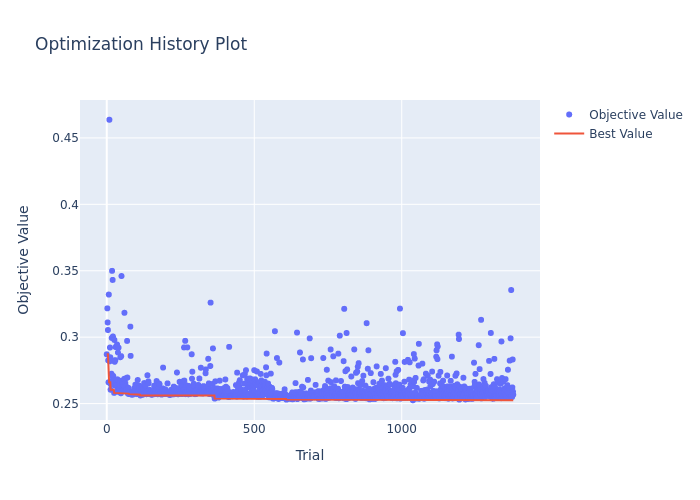

In [11]:
plot_optimization_history(study)

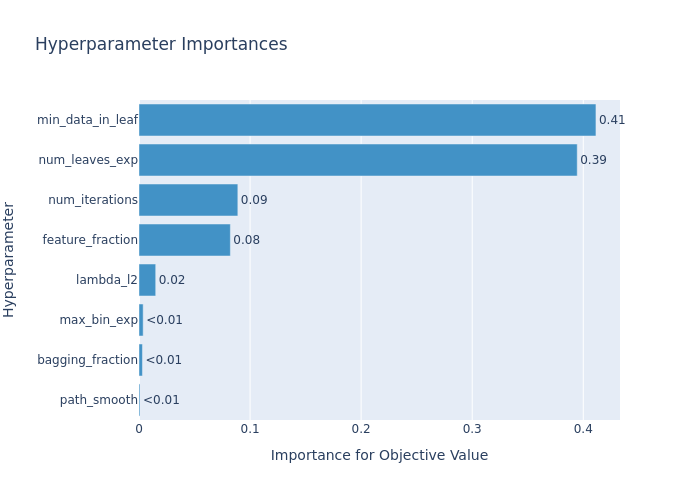

In [12]:
plot_param_importances(study)

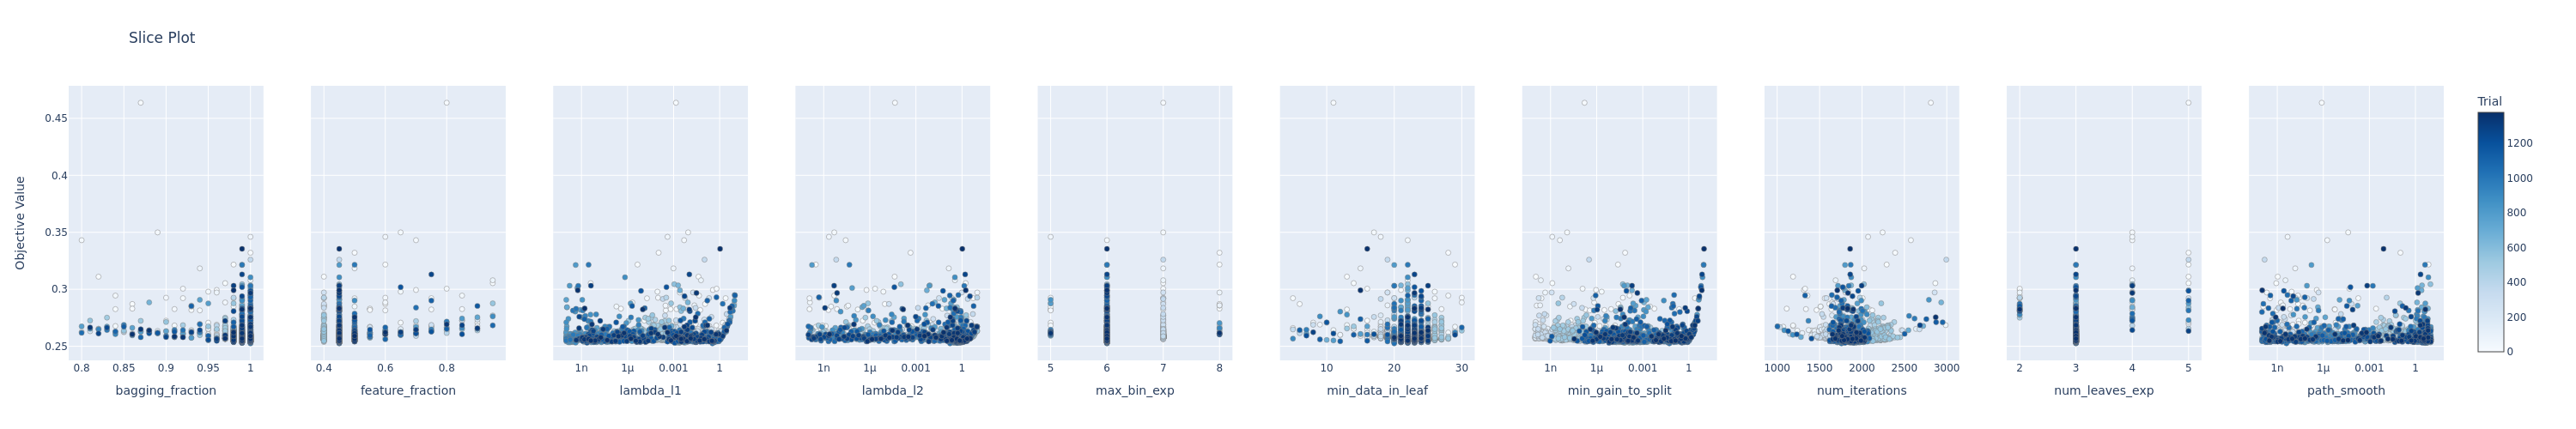

In [13]:
plot_slice(study)

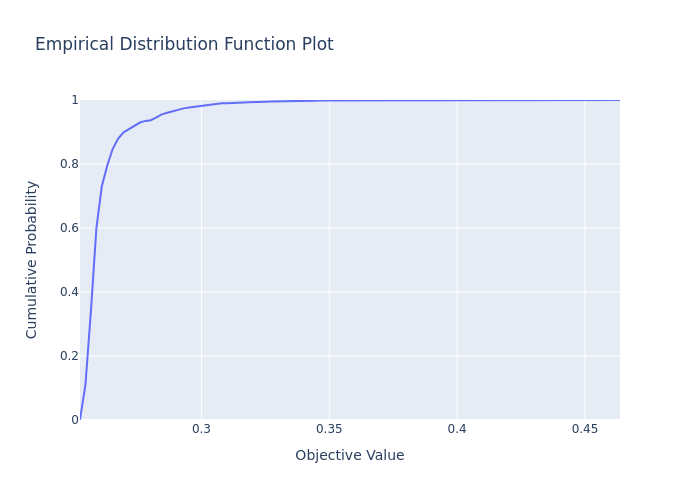

In [14]:
plot_edf(study)

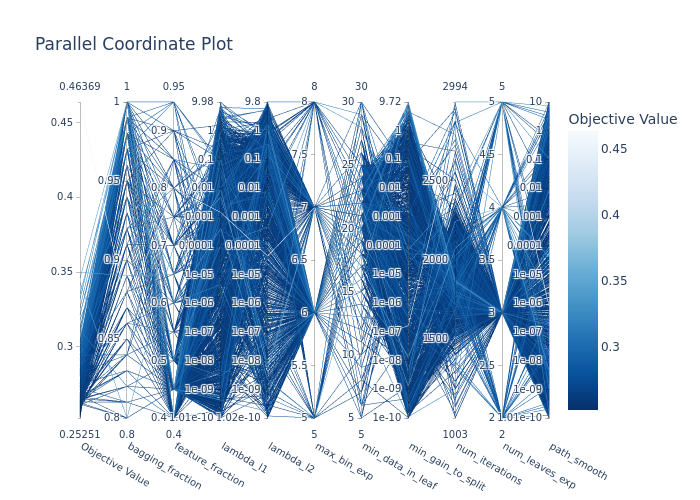

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'scale_pos_weight': 4.712962962962963,
 'bagging_fraction': 1.0,
 'feature_fraction': 0.45,
 'lambda_l1': 0.3389769126762832,
 'lambda_l2': 0.1667386417349815,
 'min_data_in_leaf': 20,
 'min_gain_to_split': 0.05398518912570113,
 'num_iterations': 1758,
 'path_smooth': 3.961234805600714e-09,
 'max_bin': 63,
 'num_leaves': 7}

***